# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Продуктивной и интересной вам работы!

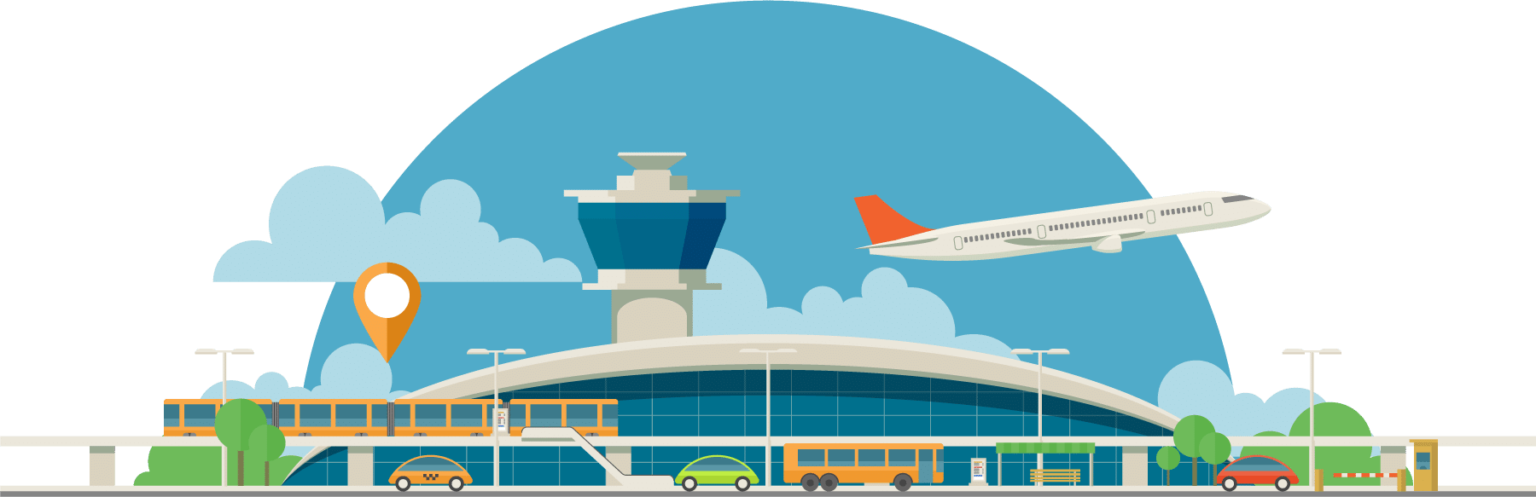

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода. <br/> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [1]:
!pip install catboost > None
!pip install mlxtend --upgrade > None
!pip install optuna > None
!pip install lime > None
!pip install shap > None
!pip install missingno > None
!pip install psycopg2-binary > None
#!pip install xgboost > None
#!brew install cmake libomp > None
#!pip install lightgbm > None
! pip install import_ipynb > None

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras
import pandas.io.sql as sqlio

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    chi2,
    mutual_info_classif,
)
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

import import_ipynb

np.random.seed(42)

# Data Prep & EDA (3 балла)

## Загрузка и предобработка данных (1.75 балла)

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2024-03-11 11:29:24--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2024-03-11 11:29:25 (1.26 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycopg2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно.

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

### Схема БД

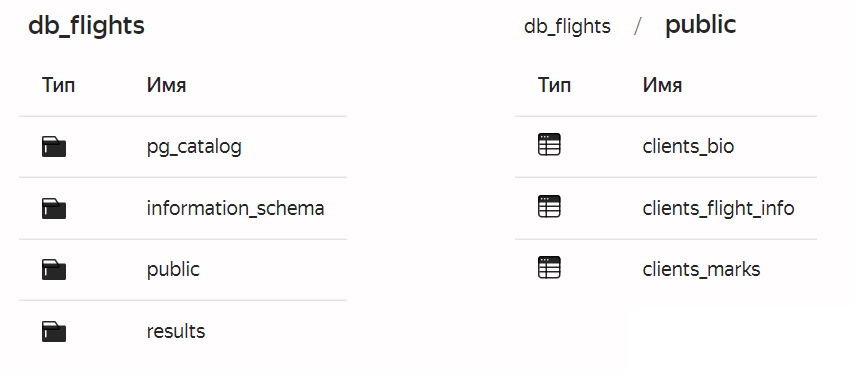

In [4]:
# your code below
# from psycopg2 import connect
# from psycopg2 import sql

# conn = connect(host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
#                port=6432,
#                sslmode='verify-full',
#                dbname='db_flights',
#                user='mlhs_student',
#                password='mlhs_student',
#                target_session_attrs='read-write')

# cur = conn.cursor()

# cur.execute("""SELECT table_name
#                FROM information_schema.tables
#                WHERE table_schema = 'public'""")

# for table in cur.fetchall():
#     print(table)

# columns = []

# cur.execute("""SELECT column_name
#                FROM information_schema.columns
#                WHERE table_schema = 'public' and table_name='clients_bio' """)

# columns.append(cur.fetchall())

# cur.execute("""SELECT column_name
#                FROM information_schema.columns
#                WHERE table_schema = 'public' and table_name='clients_flight_info' """)

# columns.append(cur.fetchall())

# cur.execute("""SELECT column_name
#                FROM information_schema.columns
#                WHERE table_schema = 'public' and table_name='clients_marks' """)

# columns.append(cur.fetchall())

# cur.close()

# df = pd.read_sql_query("""SELECT *
#                           FROM clients_bio, clients_flight_info, clients_marks
#                           WHERE clients_bio.id = clients_flight_info.id
#                           AND clients_bio.id = clients_marks.id """, conn).drop('id', axis=1)

# conn.close()

In [5]:
# # !gdown 1gXwqZYF-GbC6yKjCCqyzQnyoXFsJ2gx-
# # !unzip flights_data.zip
# # !rm flights_data.zip

# df = pd.read_parquet('/content/flights_data.parquet')
# df.head(3)

In [6]:
PATH_DATA = "/content/data"

df = pd.read_parquet(f"{PATH_DATA}/flights_data.parquet")
df.head(3)

gender   age      Customer Type   Type of Travel     class  \
0    Male  43.0     Loyal Customer  Business travel  Business   
1    Male  24.0  disloyal Customer  Business travel       Eco   
2  Female  61.0     Loyal Customer  Personal Travel       Eco   

   Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
0           1963.0                         0.0                       0.0   
1            453.0                        16.0                      30.0   
2            821.0                         0.0                       0.0   

   Inflight wifi service  Departure/Arrival time convenient  ...  \
0                    3.0                                3.0  ...   
1                    2.0                                2.0  ...   
2                    2.0                                5.0  ...   

   Online boarding  Seat comfort  Inflight entertainment  On-board service  \
0              4.0           5.0                     5.0               5.0   
1              2.0           5.0                     5.0               2.0   
2              1.0           5.0                     5.0               5.0   

   Leg room service  Baggage handling  Checkin service  Inflight service  \
0               5.0               5.0              4.0               5.0   
1               4.0               4.0              2.0               4.0   
2               2.0               5.0              5.0               5.0   

   cleanliness             satisfaction  
0          4.0                satisfied  
1          5.0  neutral or dissatisfied  
2          1.0  neutral or dissatisfied  

[3 rows x 23 columns]

In [7]:
assert df.shape == (129_549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

__Числовые переменные__

In [8]:
numerical = df.select_dtypes(include="number").columns.to_list()

print("Всего {} числовых переменных\n".format(len(numerical)))
print("Числовые переменные:", numerical)

Всего 18 числовых переменных

Числовые переменные: ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness']


In [9]:
# Преобразуем числовые столбцы в float
df[numerical] = df[numerical].apply(pd.to_numeric, errors="coerce")

In [10]:
df[numerical].isnull().sum()

age                                  315
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
dtype: int64

In [11]:
def get_numerical_outliers(dataset, cols):
    """
    Для отображения аномальных значений используем диапазон квантилей (0.996) и (0.75 + 1,5xIQR)
    """
    for column in dataset[cols]:
        quantiles = [0.004, 0.25, 0.75, 0.996]
        quantile_labels = [
            "0.004 квантиль",
            "0.25 квантиль",
            "0.75 квантиль",
            "0.996 квантиль",
        ]

        print(f"{column}")

        for quantile, label in zip(quantiles, quantile_labels):
            val = dataset[column].quantile(quantile)
            outliers_size = (
                dataset[column][dataset[column] > val].size
                if quantile > 0.25
                else dataset[column][dataset[column] < val].size
            )
            percent = outliers_size / dataset[column].size

            print(
                f"{label}: значение {val:.1f}, кол-во выбросов: {outliers_size}, доля: {percent:.4f}"
            )

        print()

In [12]:
get_numerical_outliers(df, numerical)

age
0.004 квантиль: значение 7.0, кол-во выбросов: 59, доля: 0.0005
0.25 квантиль: значение 27.0, кол-во выбросов: 30761, доля: 0.2374
0.75 квантиль: значение 51.0, кол-во выбросов: 31190, доля: 0.2408
0.996 квантиль: значение 80.0, кол-во выбросов: 483, доля: 0.0037

Flight Distance
0.004 квантиль: значение 86.0, кол-во выбросов: 507, доля: 0.0039
0.25 квантиль: значение 414.0, кол-во выбросов: 32251, доля: 0.2489
0.75 квантиль: значение 1744.0, кол-во выбросов: 32257, доля: 0.2490
0.996 квантиль: значение 3980.2, кол-во выбросов: 518, доля: 0.0040

Departure Delay in Minutes
0.004 квантиль: значение 0.0, кол-во выбросов: 0, доля: 0.0000
0.25 квантиль: значение 0.0, кол-во выбросов: 0, доля: 0.0000
0.75 квантиль: значение 12.0, кол-во выбросов: 32132, доля: 0.2480
0.996 квантиль: значение 264.0, кол-во выбросов: 512, доля: 0.0040

Arrival Delay in Minutes
0.004 квантиль: значение 0.0, кол-во выбросов: 0, доля: 0.0000
0.25 квантиль: значение 0.0, кол-во выбросов: 0, доля: 0.0000
0.75 к

__Категориальные переменные__

In [13]:
categorical = df.select_dtypes(include="object").columns.to_list()

print("Всего {} категориальных переменных\n".format(len(categorical)))
print("Категориальные переменные:", categorical)

Всего 5 категориальных переменных

Категориальные переменные: ['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction']


In [14]:
df[categorical].isnull().sum()

gender            0
Customer Type     0
Type of Travel    0
class             0
satisfaction      0
dtype: int64

In [15]:
df[categorical].nunique()

gender            2
Customer Type     3
Type of Travel    3
class             4
satisfaction      3
dtype: int64

In [16]:
def get_categorical_outliers(dataset, cols):
    """
    Для анализа аномальных значений категориальных переменных
    """
    for column in dataset[cols]:
        value_counts = dataset[column].value_counts(dropna=False)
        total_count = len(dataset[column])
        unique_count = len(value_counts)

        print(f"{column}")
        print("Уникальных значений:", unique_count)

        for value, count in value_counts.items():
            percentage = count / total_count
            print(f"Значение: {value}, Количество: {count}, Доля: {percentage:.4f}")

        print()

In [17]:
get_categorical_outliers(df, categorical)

gender
Уникальных значений: 2
Значение: Female, Количество: 65726, Доля: 0.5073
Значение: Male, Количество: 63823, Доля: 0.4927

Customer Type
Уникальных значений: 3
Значение: Loyal Customer, Количество: 105763, Доля: 0.8164
Значение: disloyal Customer, Количество: 23709, Доля: 0.1830
Значение: nan, Количество: 77, Доля: 0.0006

Type of Travel
Уникальных значений: 3
Значение: Business travel, Количество: 89405, Доля: 0.6901
Значение: Personal Travel, Количество: 40043, Доля: 0.3091
Значение: nan, Количество: 101, Доля: 0.0008

class
Уникальных значений: 4
Значение: Business, Количество: 61939, Доля: 0.4781
Значение: Eco, Количество: 58115, Доля: 0.4486
Значение: Eco Plus, Количество: 9379, Доля: 0.0724
Значение: nan, Количество: 116, Доля: 0.0009

satisfaction
Уникальных значений: 3
Значение: neutral or dissatisfied, Количество: 58732, Доля: 0.4534
Значение: satisfied, Количество: 44912, Доля: 0.3467
Значение: -, Количество: 25905, Доля: 0.2000



(0.5 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

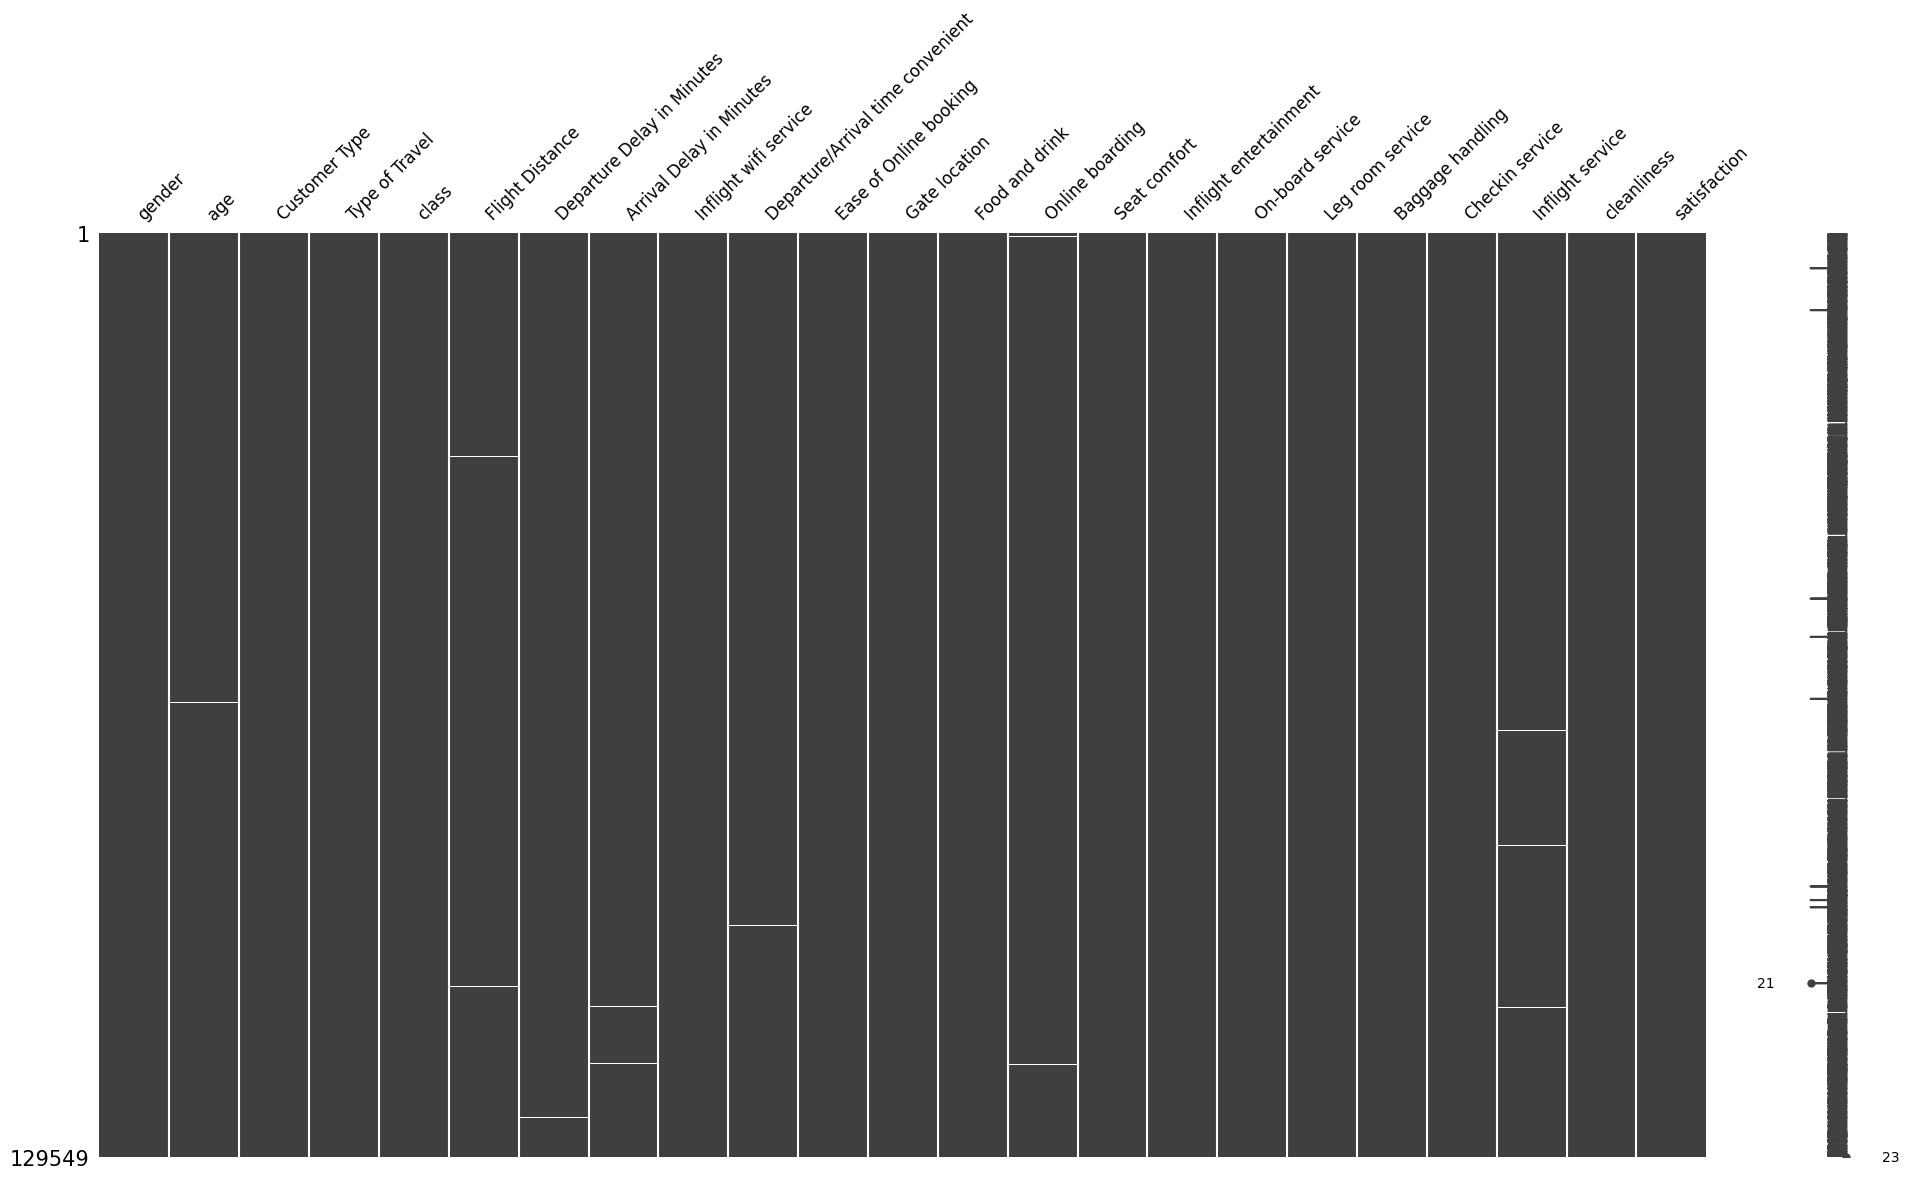

In [18]:
# your code below
missingno.matrix(df, figsize=(23, 12), fontsize=12);

/usr/local/lib/python3.10/dist-packages/missingno/missingno.py:271: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<Axes: >

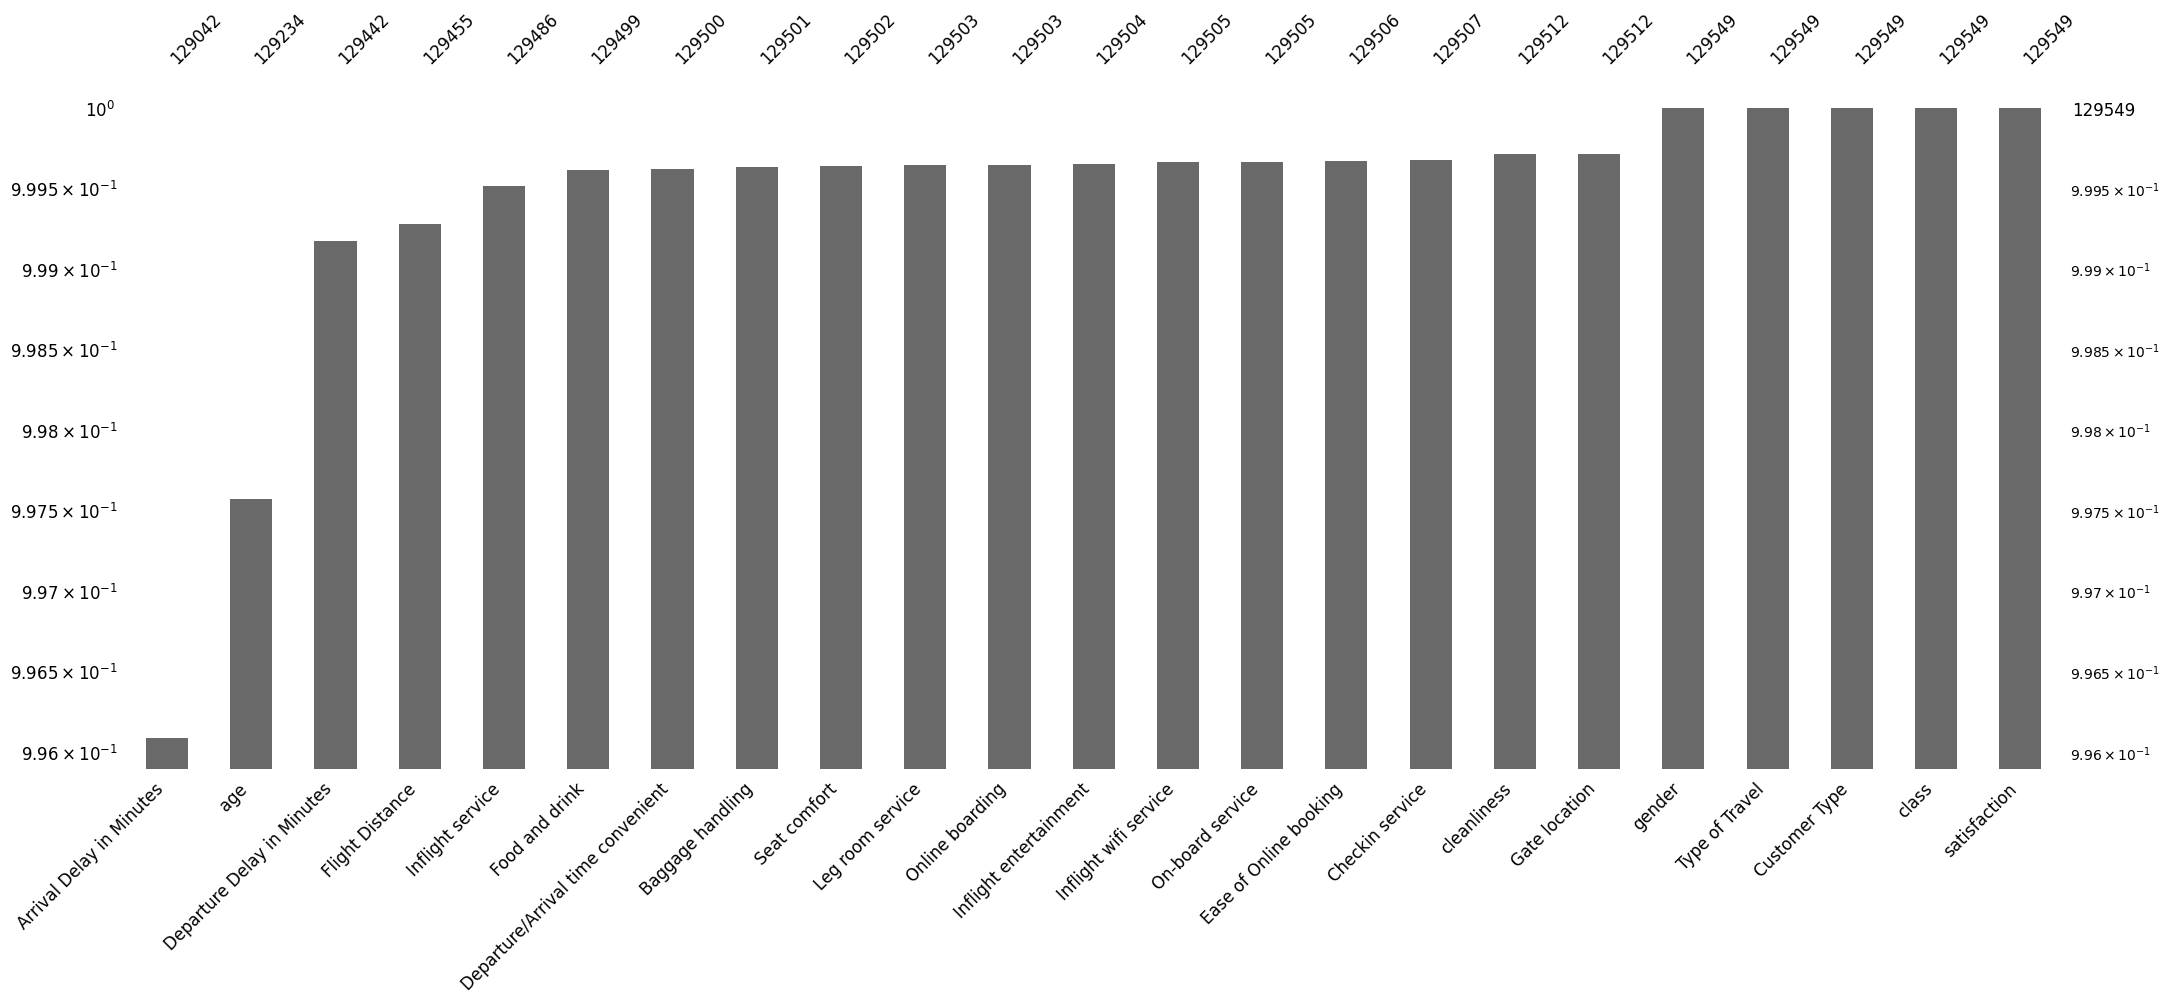

In [19]:
# your code below
missingno.bar(df, sort="ascending", log=True, figsize=(25, 9), fontsize=12)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [20]:
df_train = df[df.satisfaction != "-"]
df_train

gender   age      Customer Type   Type of Travel     class  \
0         Male  43.0     Loyal Customer  Business travel  Business   
1         Male  24.0  disloyal Customer  Business travel       Eco   
2       Female  61.0     Loyal Customer  Personal Travel       Eco   
3         Male  35.0  disloyal Customer  Business travel  Business   
4       Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129542  Female  28.0     Loyal Customer  Personal Travel       Eco   
129543    Male  66.0     Loyal Customer  Personal Travel       Eco   
129544  Female  59.0     Loyal Customer  Personal Travel       Eco   
129545    Male  61.0     Loyal Customer  Personal Travel       Eco   
129546    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
0                1963.0                         0.0                       0.0   
1                 453.0                        16.0                      30.0   
2                 821.0                         0.0                       0.0   
3                 212.0                         0.0                       0.0   
4                  67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129542            447.0                        23.0                      16.0   
129543            337.0                       199.0                     213.0   
129544            308.0                        32.0                      24.0   
129545            337.0                         0.0                       0.0   
129546            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
0                         3.0                                3.0  ...   
1                         2.0                                2.0  ...   
2                         2.0                                5.0  ...   
3                         2.0                                2.0  ...   
4                         3.0                                3.0  ...   
...                       ...                                ...  ...   
129542                    1.0                                3.0  ...   
129543                    2.0                                4.0  ...   
129544                    3.0                                5.0  ...   
129545                    2.0                                4.0  ...   
129546                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
0                   4.0           5.0                     5.0   
1                   2.0           5.0                     5.0   
2                   1.0           5.0                     5.0   
3                   2.0           2.0                     2.0   
4                   5.0           4.0                     4.0   
...                 ...           ...                     ...   
129542              1.0           3.0                     3.0   
129543              5.0           5.0                     5.0   
129544              5.0           5.0                     3.0   
129545              2.0           3.0                     3.0   
129546              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                    5.0               5.0               5.0              4.0   
1                    2.0               4.0               4.0              2.0   
2                    5.0               2.0               5.0              5.0   
3                    4.0               5.0               5.0              5.0   
4                    4.0               4.0               4.0              5.0   
...                  ...               ...        

In [21]:
assert df_train.shape == (103_644, 23)

In [22]:
df_test = df[df.satisfaction == "-"].drop("satisfaction", axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
5         Male  36.0  Loyal Customer  Business travel  Business   
7       Female  70.0  Loyal Customer  Personal Travel       Eco   
12        Male  66.0  Loyal Customer  Personal Travel       Eco   
19      Female  60.0  Loyal Customer  Business travel  Business   
24        Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129531    Male  38.0  Loyal Customer  Business travel       Eco   
129535    Male  16.0  Loyal Customer  Personal Travel       Eco   
129539  Female  43.0  Loyal Customer  Personal Travel       Eco   
129547    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129548    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
5                3655.0                        40.0                      71.0   
7                 108.0                        50.0                      41.0   
12                562.0                        88.0                      84.0   
19               3756.0                        36.0                      24.0   
24                802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129531            337.0                        92.0                      82.0   
129535            308.0                         2.0                       0.0   
129539            308.0                         0.0                       0.0   
129547            447.0                         0.0                       0.0   
129548            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
5                         1.0                                1.0  ...   
7                         5.0                                4.0  ...   
12                        2.0                                5.0  ...   
19                        4.0                                4.0  ...   
24                        1.0                                2.0  ...   
...                       ...                                ...  ...   
129531                    4.0                                3.0  ...   
129535                    3.0                                4.0  ...   
129539                    2.0                                4.0  ...   
129547                    3.0                                4.0  ...   
129548                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
5                  1.0              3.0           3.0                     3.0   
7                  4.0              4.0           4.0                     3.0   
12                 5.0              2.0           5.0                     5.0   
19                 2.0              4.0           5.0                     4.0   
24                 2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129531             4.0              5.0           4.0                     4.0   
129535             1.0              3.0           5.0                     1.0   
129539             3.0              5.0           5.0                     4.0   
129547             4.0              3.0           4.0                     4.0   
129548             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
5                    3.0               3.0               1.0              4.0   
7                    3.0               0.0               3.0              5.0   
12                   3.0               5.0               2.0              5.0   
19                   4.0               4.0              

In [23]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train.drop("satisfaction", axis=1),
    df_train.satisfaction,
    test_size=0.3,
    random_state=42,
)

In [25]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

In [26]:
# df(129_549, 23) -> df_train(103_644, 23) -> X_train(72_550, 22) + y_train(72_550,)
#                                          -> X_val(31_094, 22) + y_val(31_094,)
#                 -> df_test(25_905, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые.

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [27]:
cols_for_replace_nan = ["Customer Type", "Type of Travel", "class"]

In [28]:
def replace_nans(df, cols):
    """
    Замена 'nan' на None
    """
    df[cols] = df[cols].replace("nan", None)
    return df

In [29]:
X_train = replace_nans(X_train, cols_for_replace_nan)
X_val = replace_nans(X_val, cols_for_replace_nan)
df_test = replace_nans(df_test, cols_for_replace_nan)

In [30]:
# your code below
def preprocessing_passes(train, test, dtype="categorical"):
    """
    Замена пропусков в признаках модой
    Мода определяется для столбцов по train
    """
    if dtype == "numerical":
        type_cols = train.select_dtypes(include=np.number).columns

    else:
        type_cols = train.select_dtypes(include="object").columns

    mode_values = train[type_cols].mode().iloc[0]

    train[type_cols] = train[type_cols].fillna(mode_values)
    test[type_cols] = test[type_cols].fillna(mode_values)

    return train, test

In [31]:
X_train, X_val = preprocessing_passes(X_train, X_val, "numerical")
X_train, X_val = preprocessing_passes(X_train, X_val, "categorical")

_, df_test = preprocessing_passes(X_train, df_test, "numerical")
_, df_test = preprocessing_passes(X_train, df_test, "categorical")

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [32]:
# the place for you to code
display(X_train.describe())
display(X_train.describe(include="O"))

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

gender   Customer Type   Type of Travel     class
count    72550           72550            72550     72550
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36816           59406            50054     34793

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

**1 Возраст (Age):**

- Средний возраст пассажиров составляет около 40 лет;
- Минимальный возраст составляет 0 лет, что, вероятно, является ошибкой или выбросом;
- Максимальный возраст достигает 544 лет, что также может быть ошибкой или выбросом;
- Распределение возраста имеет некоторый разброс, так как стандартное отклонение составляет около 20 лет;
- Медианный возраст также около 40 лет, что указывает на примерно равное количество молодых и старших пассажиров в выборке.

**2 Расстояние полета (Flight Distance):**

- Среднее расстояние полета составляет около 1329 миль;
- Минимальное расстояние полета равно 0 милям, что может быть ошибочной записью или выбросом;
- Максимальное расстояние полета достигает 379620 миль, что, вероятно, также является выбросом;
- Распределение расстояния полета имеет большой разброс, что отражается в стандартном отклонении около 4764 миль;
- Медианное расстояние полета составляет около 844 миль.

**3 Задержка при вылете и прибытии (Departure Delay in Minutes, Arrival Delay in Minutes):**

- Средние значения задержек при вылете и прибытии составляют примерно 16 минут;
- Максимальные значения этих задержек впечатляюще высоки (9282 и 11760 минут соответственно), что может быть результатом экстремальных ситуаций или ошибок в данных;
- Распределение задержек имеет большое стандартное отклонение, что указывает на значительный разброс значений.

**4 Оценки сервиса во время полета:**

- Виды услуг (Inflight wifi service, Departure/Arrival time convenient, Ease of Online booking, Gate location, Food and drink, Online boarding, Seat comfort, Inflight entertainment, On-board service, Leg room service, Baggage handling, Checkin service, Inflight service, cleanliness) оцениваются на шкале от 0 до 5.
Средние оценки зачастую выше среднего (ближе к 4), что может указывать на общее удовлетворение пассажиров услугами;
- Минимальные значения зачастую равны 0, что, вероятно, означает отсутствие или недостаточность услуги;
- Максимальные значения также достаточно высоки, но не максимальные для всех аспектов, что может указывать на возможность дальнейшего улучшения качества предоставляемых услуг.

**5 Пол (Gender):**

- В выборке присутствуют два пола, причем чаще всего встречается женский пол (частота примерно 50%).

**Тип клиента (Customer Type):**

- Большинство клиентов - постоянные клиенты (частота примерно 82%).

**6 Тип путешествия (Type of Travel):**

- Большинство путешествий относятся к деловым (частота примерно 69%).

**7 Класс (Class):**

- Большинство путешествий совершается бизнес-классом (частота примерно 48%).

Общий вывод: данные имеют разнообразие значений, но также могут содержать выбросы и ошибки, которые требуют дополнительной проверки и очистки.

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [33]:
# place for you to code
def replace_outliers(train, test):
    """
    Функция для удаления выбросов на границе интервала, определенный квантилем
    """
    numerical = train.select_dtypes(include=np.number).columns

    quantile_upper = 0.996

    upper_bounds = train[numerical].quantile(quantile_upper)

    for col in numerical:
        upper_bound = upper_bounds[col]

        train = train[train[col] <= upper_bound]
        test = test[test[col] <= upper_bound]

        # Замены выбросов верхними гарницами по квантилям
        # train[col] = np.clip(train[col], None, upper_bound)
        # test[col] = np.clip(test[col], None, upper_bound)

    return train, test

In [34]:
X_train, X_val = replace_outliers(X_train, X_val)

In [35]:
# assert X_train.shape == (71_369, 22) эти ассерты у большинства студентов не проходили
# assert X_val.shape == (30_609, 22) и это совершенно не принципиально
assert df_test.shape == (25_905, 22)

In [36]:
ind_train = X_train.index
ind_val = X_val.index

In [37]:
y_train = y_train.loc[ind_train].copy()
y_val = y_val.loc[ind_val].copy()

## EDA (1.25 балла)

Создадим переменные с перечислениями столбцов разного типа

In [38]:
continuous_cols = [
    "age",
    "Flight Distance",
    "Departure Delay in Minutes",
    "Arrival Delay in Minutes",
]
ordinal_cols = list(
    set(df.select_dtypes(include="number").columns) - set(continuous_cols)
)
categorical_cols = list(df.select_dtypes(include="object").columns)[:-1]

In [39]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [40]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in df[cols]:
        fig, ax = plt.subplots(figsize=(9, 5))
        sns.countplot(
            data=df[cols],
            x=col,
            hue=y,
            order=df[col].value_counts().index,
        )
        plt.title(f"{col} distribution")

        # Отображение процентного соотношения
        total = df[col].count()
        ax.bar_label(
            ax.containers[0], fmt=lambda x: f"{(x/total)*100:0.1f}%", rotation=0
        )
        ax.bar_label(
            ax.containers[1], fmt=lambda x: f"{(x/total)*100:0.1f}%", rotation=0
        )
        fig.tight_layout()
        plt.show()

In [41]:
def plot_continuous(cols, df, y):
    """
    Рисует kdeplot и boxplot для всех столбцов в списке 'cols'
    с информативным названием
    """

    for col in df[cols]:
        plt.figure(figsize=(9, 6))

        plt.subplot(1, 2, 1)
        sns.kdeplot(
            data=df[cols],
            x=col,
            hue=y,
        )
        plt.title(f"{col} distribution")

        plt.subplot(1, 2, 2)
        sns.boxplot(
            data=df[cols],
            x=col,
            hue=y,
        )
        plt.title(f"{col} boxplot by target")
        plt.show()

In [42]:
def plot_categorical(cols, df, y):
    """
    Визуализирует распределение столбцов с категориальными признаками
    """
    for col in df[cols]:
        fig, ax = plt.subplots(figsize=(9, 5))
        sns.countplot(
            data=df[cols],
            x=col,
            hue=y,
            order=df[col].value_counts().index,
        )
        plt.title(f"{col} distribution")

        # Отображение процентного соотношения
        total = df[col].count()
        ax.bar_label(
            ax.containers[0], fmt=lambda x: f"{(x/total)*100:0.1f}%", rotation=0
        )
        ax.bar_label(
            ax.containers[1], fmt=lambda x: f"{(x/total)*100:0.1f}%", rotation=0
        )
        fig.tight_layout()
        plt.show()

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

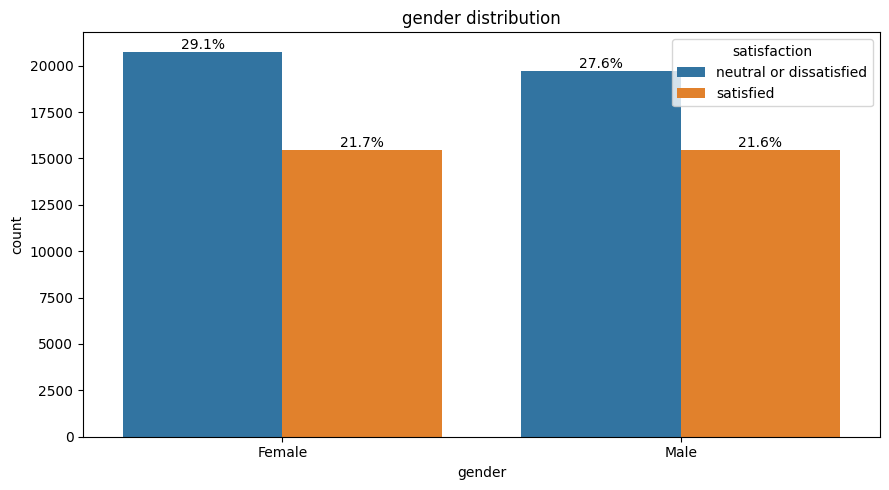

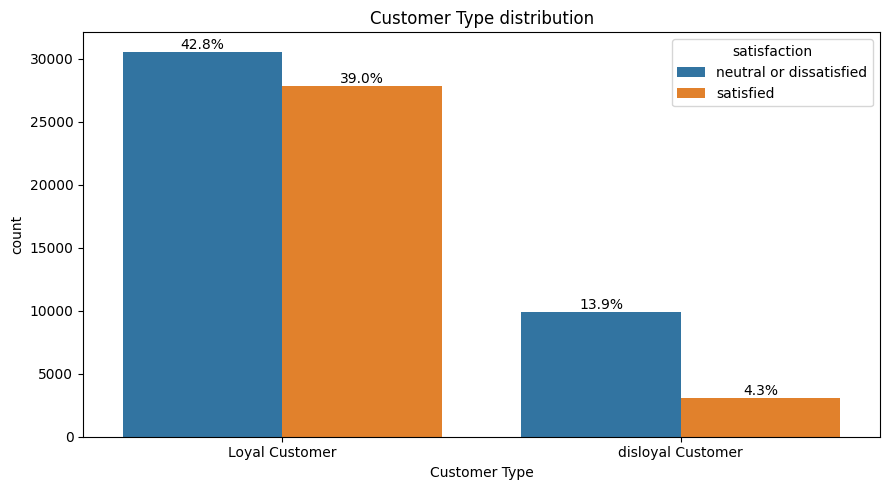

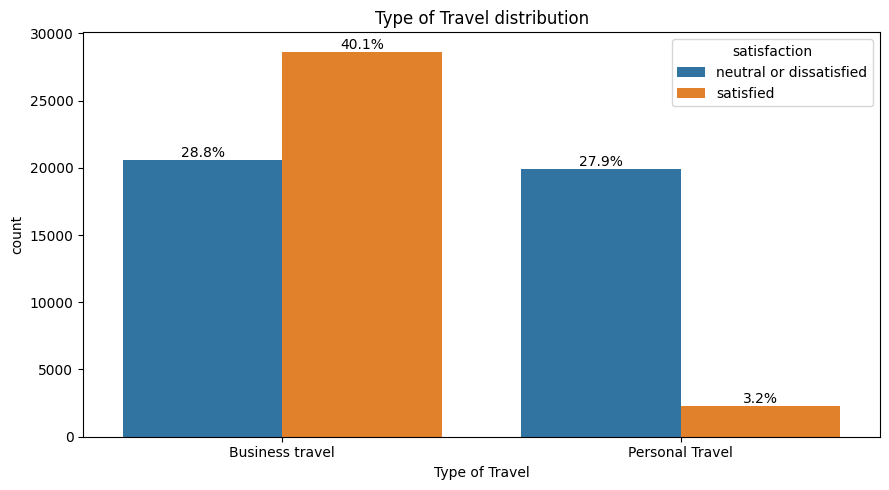

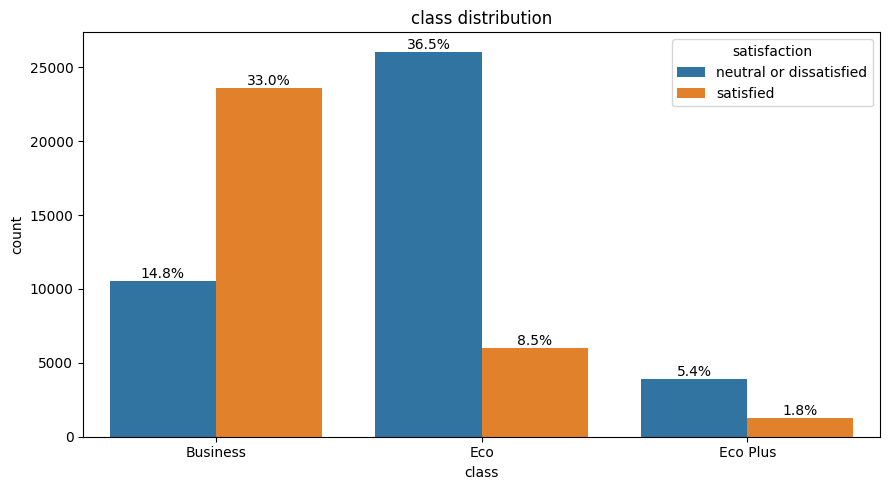

In [43]:
plot_categorical(categorical_cols, X_train, y_train)

**Пол (Gender):**

- Класс "satisfied" распространен среди женщин (50.75%), что указывает на равномерное распределение удовлетворения среди полов.

**Тип клиента (Customer Type):**

- Удовлетворенность ("satisfied") среди лояльных клиентов гораздо выше чем у нелояльных клиентов, что указывает на неравномерное распределение удовлетворения среди типов клиентов.

**Тип путешествия (Type of Travel):**

- Удовлетворенность ("satisfied") выше чем неудовлетворенность, что характерно для деловых поездок по сравнению с личными поездками, где все на оборот. Что также указывает на неравномерное распределение удовлетворения среди типов путешествия.

**Класс (Class):**

- Удовлетворенность ("satisfied") среди пассажиров бизнес-класса преобладает, у пассажиров эконом-класса и эконом-класса "Экстра" на оборот. Неравномерное распределение удовлетворения среди классов.

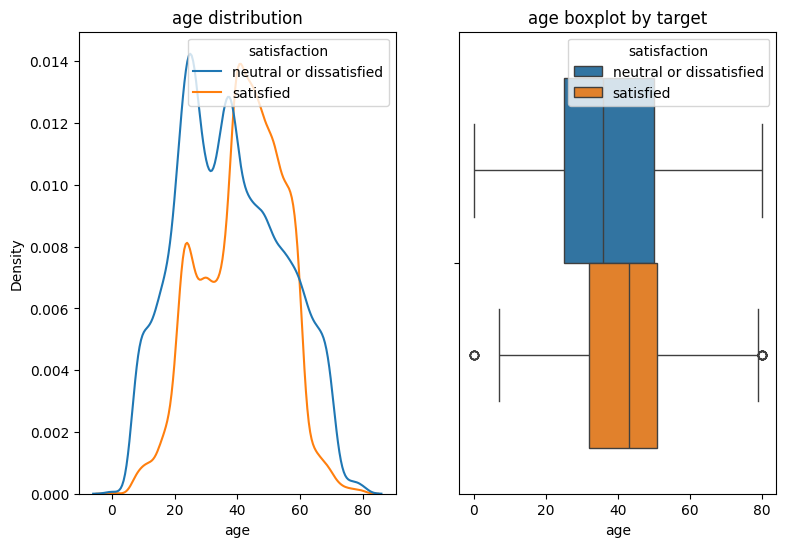

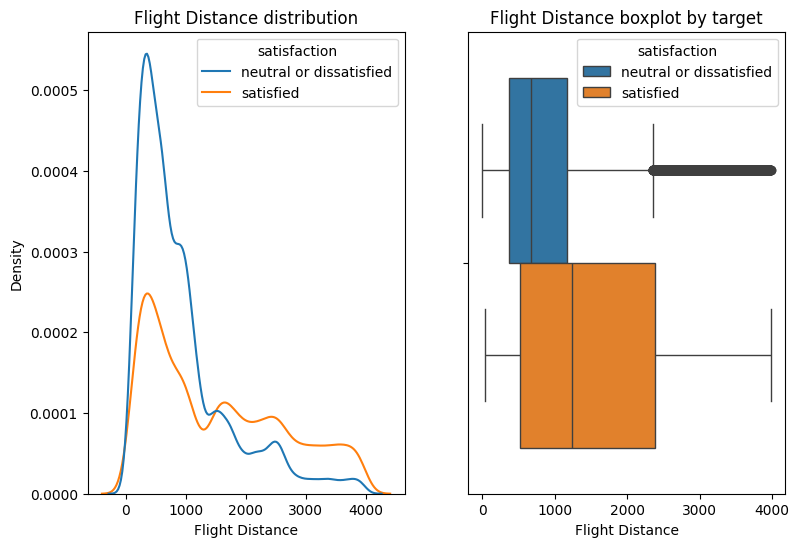

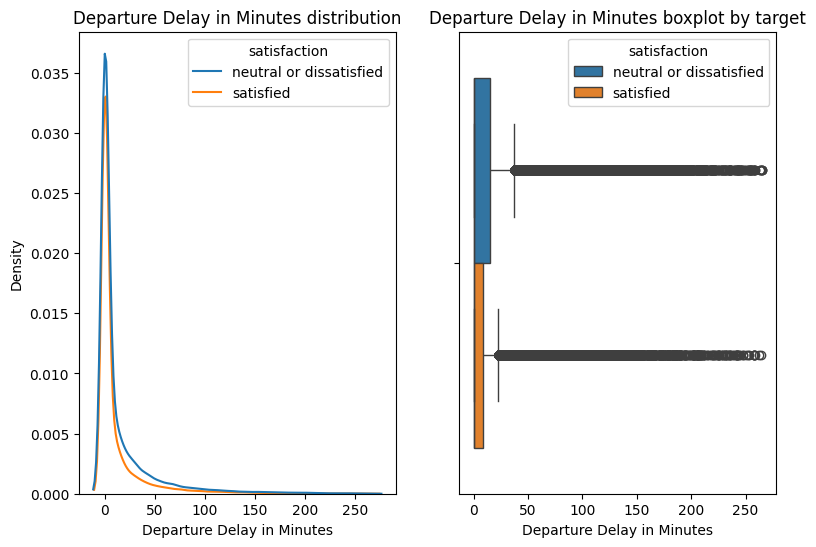

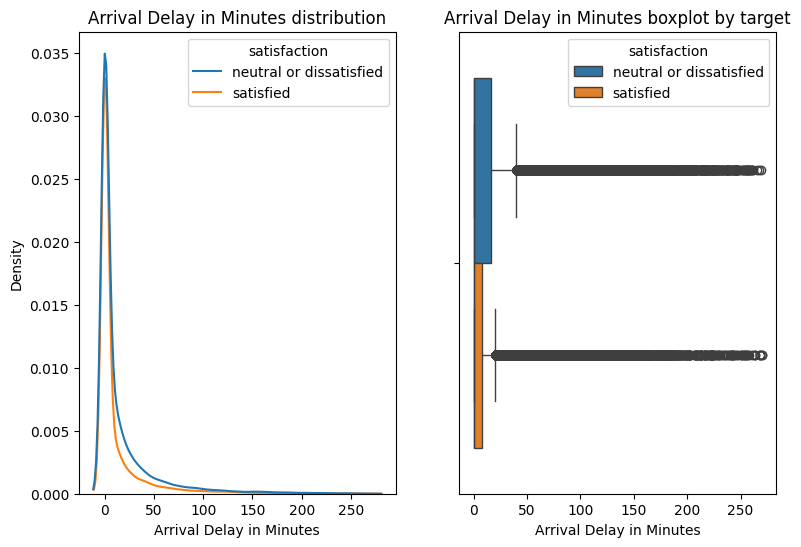

In [44]:
plot_continuous(continuous_cols, X_train, y_train)

**Возраст (age):**

 - В среднем возраст пассажиров, которые были удовлетворены полетом, чуть выше (приблизительно 41.7 лет), чем тех, кто был недоволен (приблизительно 37.6 лет). Однако разброс возраста в обеих группах достаточно большой.

**Расстояние полета (Flight Distance):**

 - Среднее расстояние полета для удовлетворенных пассажиров (приблизительно 1512.1 миль) выше, чем для недовольных (приблизительно 927.0 миль). Это может быть связано с тем, что длительные полеты могут предоставить больше возможностей для удовлетворения пассажиров.

**Задержка при вылете (Departure Delay in Minutes):**

- Cредняя задержка при вылете для недовольных пассажиров (приблизительно 15.1 минут) выше, чем для удовлетворенных (приблизительно 11.5 минут). Это может быть одним из факторов, влияющих на уровень удовлетворенности пассажиров.

**Задержка при прилете (Arrival Delay in Minutes):**

- Средняя задержка при прилете также выше у недовольных пассажиров (приблизительно 15.6 минут по сравнению с приблизительно 11.5 минут у удовлетворенных). Это также может негативно повлиять на уровень удовлетворенности.

**Распределения признаков:**

- Возраст (age), Расстояние полета (Flight Distance), Задержка при вылете (Departure Delay in Minutes) и Задержка при прилете (Arrival Delay in Minutes) имеют неравномерные распределения, с некоторым количеством выбросов и большим разбросом значений.
- Классы не сбалансированы, так как количество недовольных пассажиров (neutral or dissatisfied) превышает количество удовлетворенных (satisfied).

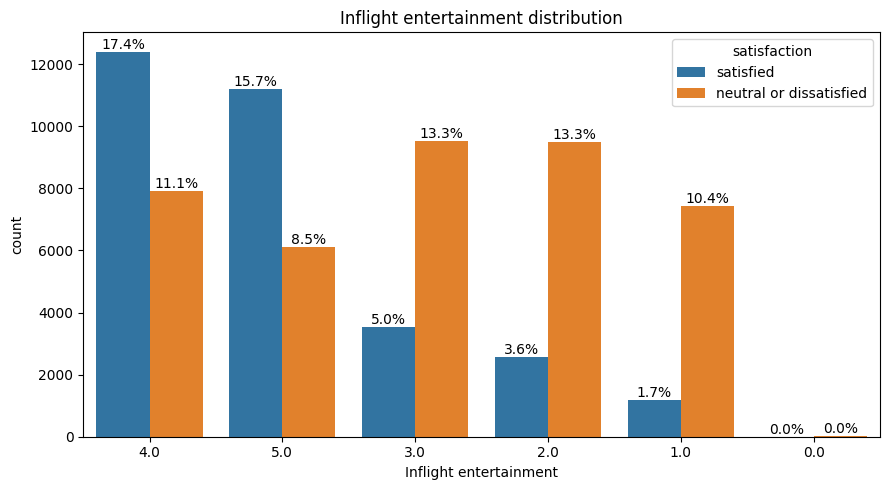

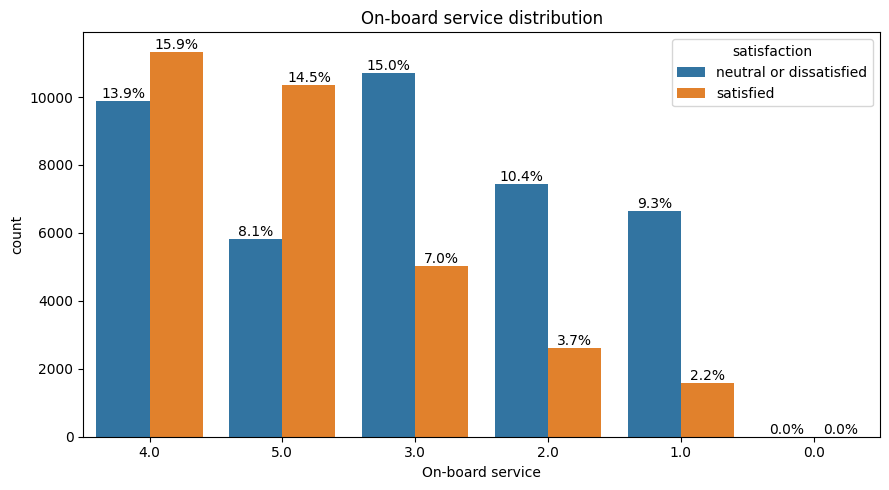

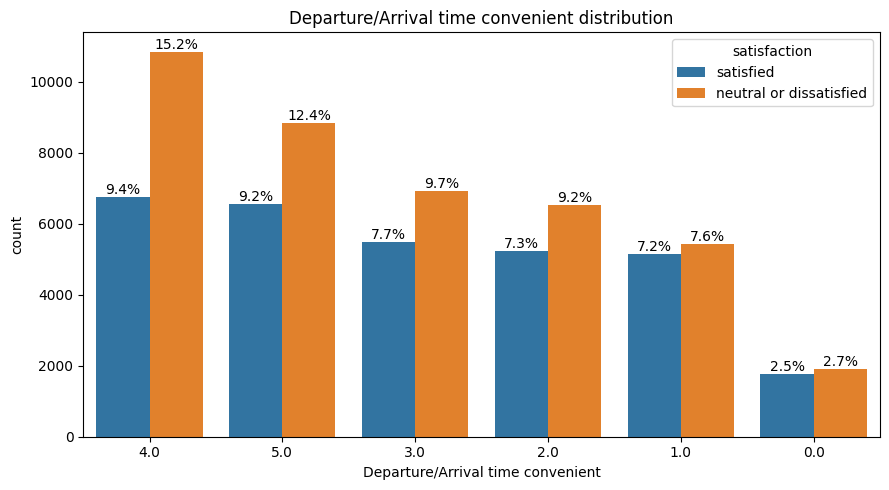

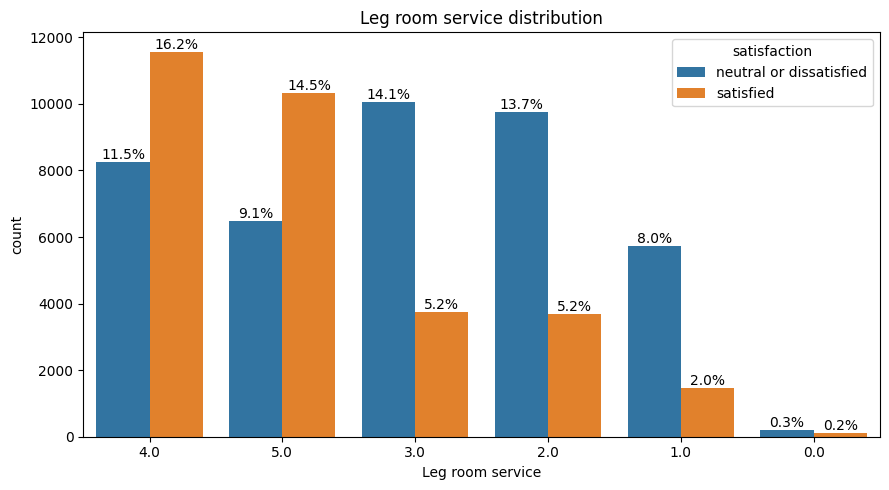

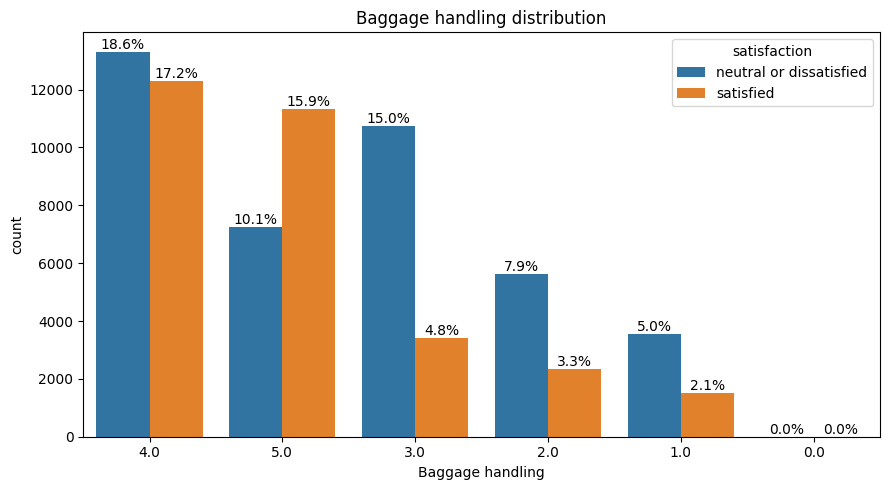

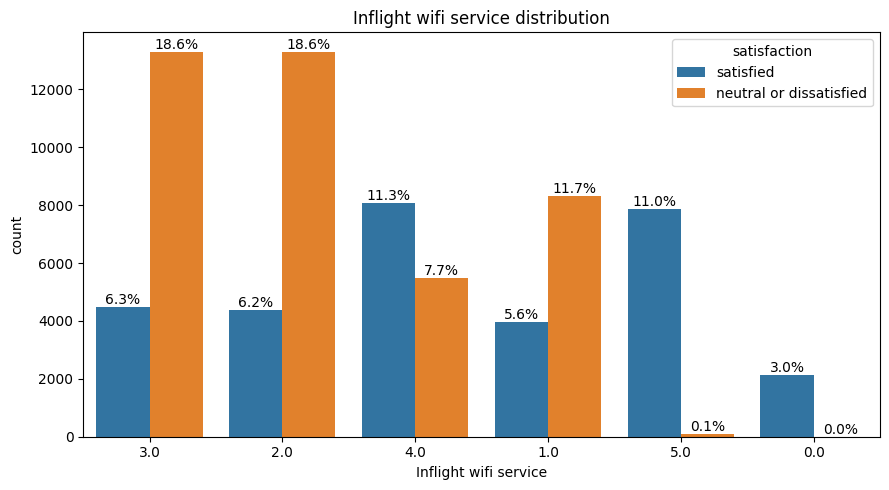

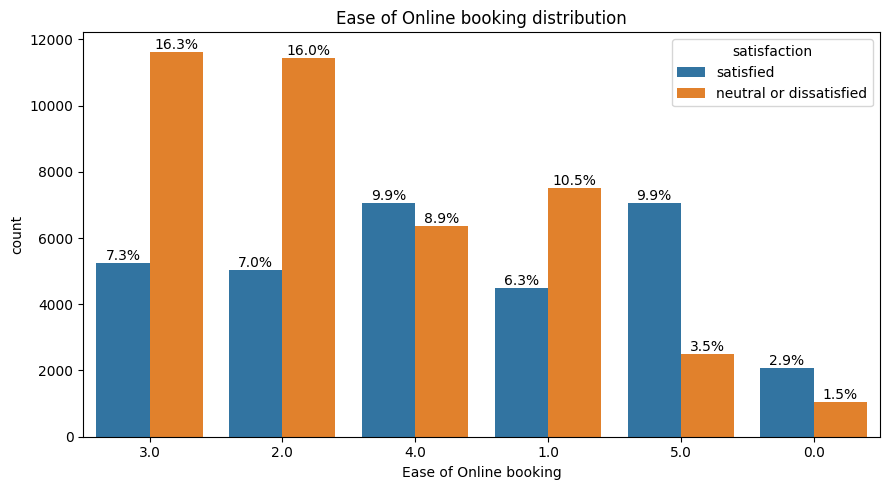

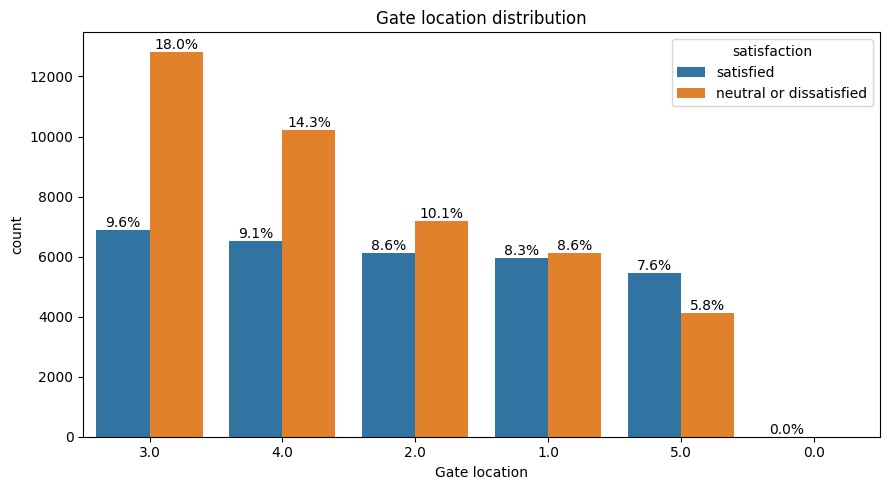

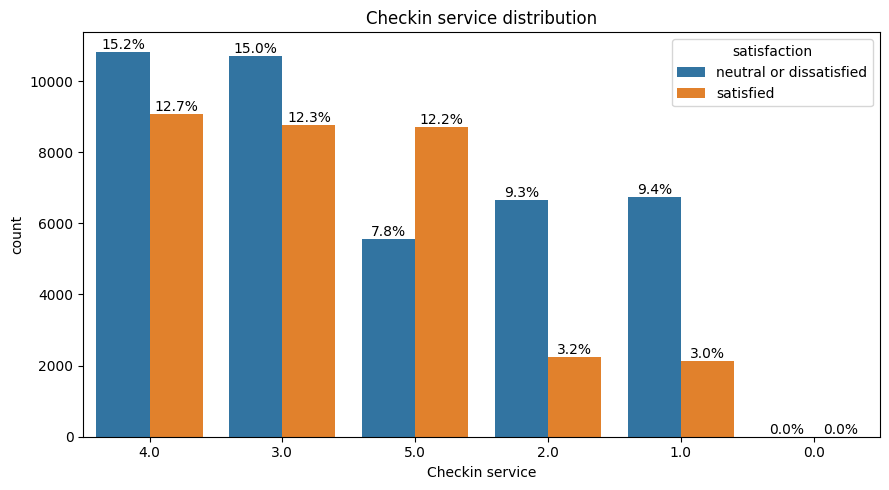

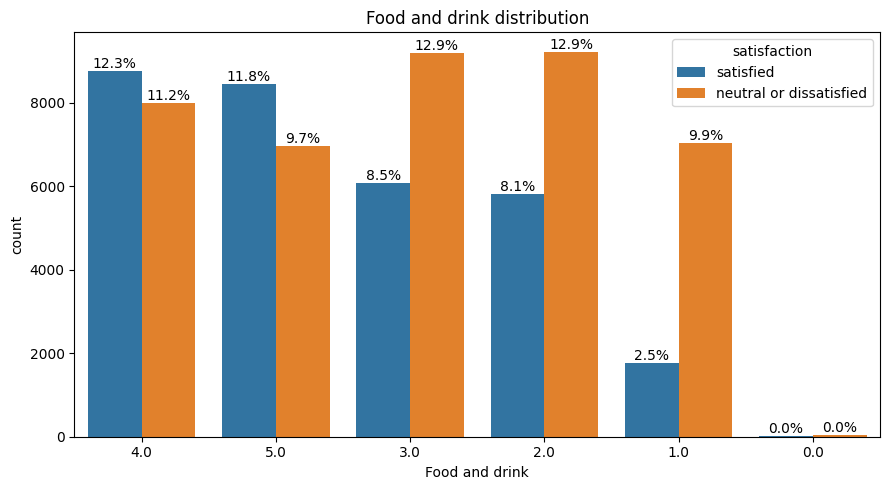

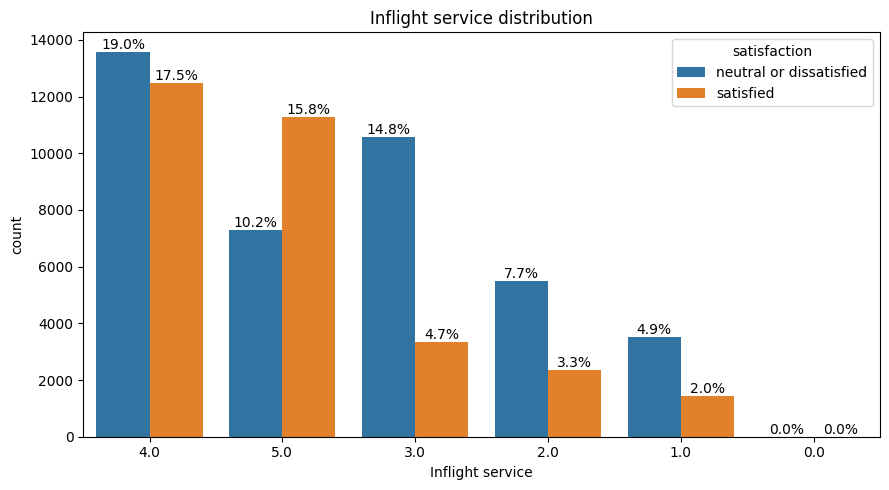

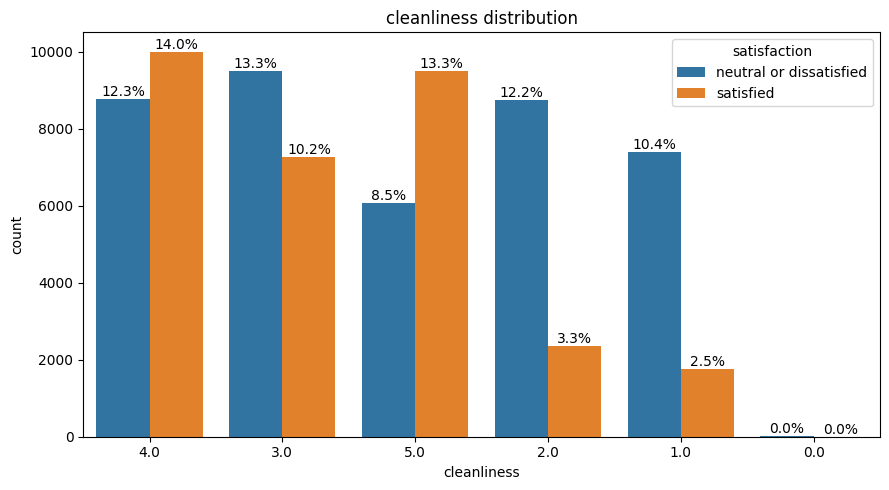

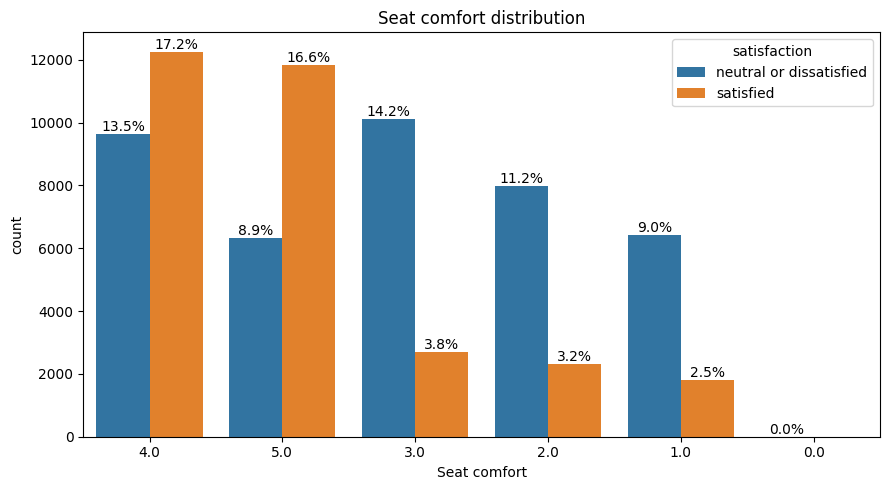

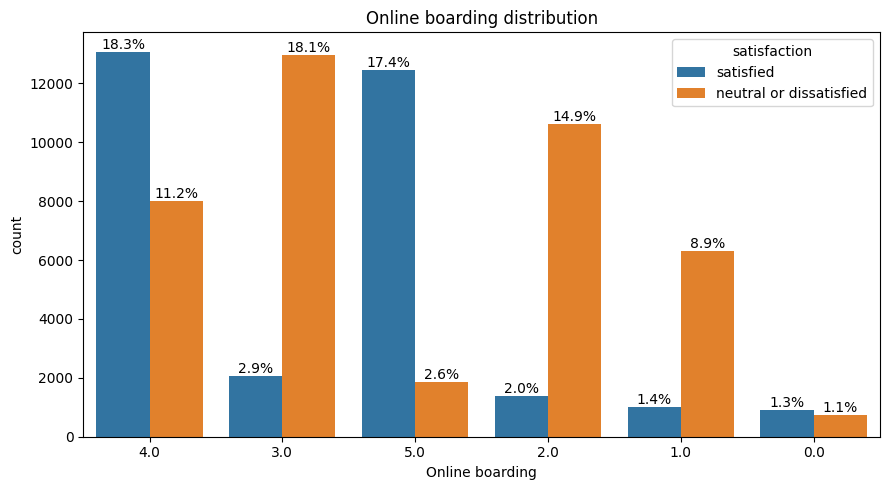

In [45]:
plot_ordinal(ordinal_cols, X_train, y_train)

**Распределение категориальных признаков:**

Некоторые категориальные признаки, такие как `Gate location`, `On-board service`, `Departure/Arrival`, `time convenient`, `Inflight wifi service`, `Seat comfort`, `Food and drink`, имеют неравномерное распределение, где некоторые значения имеют более высокую частоту по сравнению с другими.

**Сбалансированность классов:**

Признаки `Departure/Arrival time convenient`, `Baggage handling`, `Inflight wifi service` имеют несбалансированные классы по целевой переменной, где один из классов имеет гораздо больший процент по сравнению с другим.

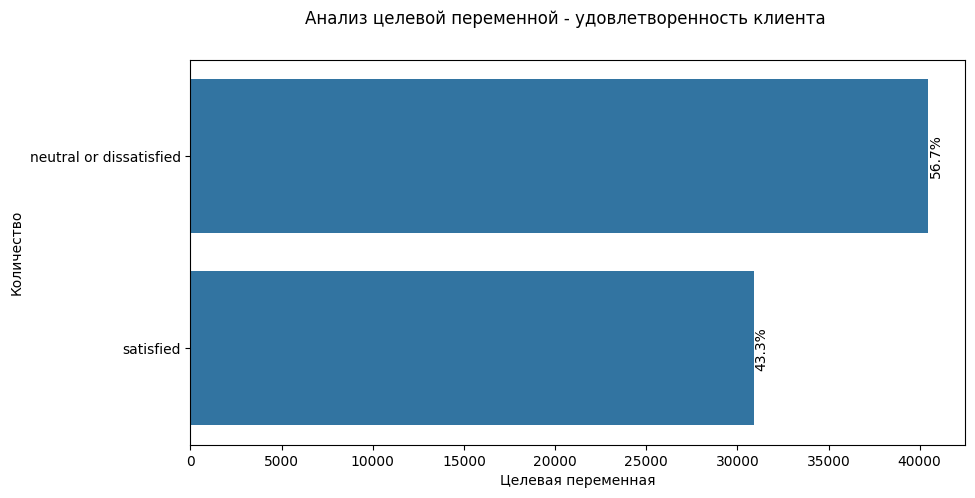

In [46]:
# visualize y_train

fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(data=y_train)

ax.set_ylabel("Количество")
ax.set_xlabel("Целевая переменная")

total = y_train.count()
ax.bar_label(ax.containers[0], fmt=lambda x: f"{(x/total)*100:0.1f}%", rotation=90)

plt.suptitle("Анализ целевой переменной - удовлетворенность клиента")
plt.show()

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

**Выводы:**

- Классы удовлетворения неравномерно распределены по всем рассмотренным категориальным признакам, что может быть важно при анализе зависимости удовлетворенности от других переменных.
- Классы не сбалансированы, что означает, что существует диспропорция между количеством наблюдений в каждом классе. Например, класс "satisfied" часто встречается среди лояльных клиентов, пассажиров бизнес-класса и деловых поездок, в то время как класс "neutral or dissatisfied" преобладает среди нелояльных клиентов, пассажиров эконом-класса и личных поездок.
- Некоторые признаки имеют немного смещенное распределение, например, удовлетворенность среди мужчин несколько ниже, чем среди женщин, и это возможно может быть фактором для анализа удовлетворенности пассажиров в зависимости от их пола.

(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

In [47]:
# Оценим пропорции для y_train и y_val
prop_train = y_train.value_counts().values[0] / y_train.value_counts().values[1]
prop_val = y_val.value_counts().values[0] / y_val.value_counts().values[1]
print(f"Доля положительного значения целевой переменной в y_train: {prop_train:.5f}")
print(f"Доля положительного значения целевой переменной в y_val: {prop_val:.5f}")

Доля положительного значения целевой переменной в y_train: 1.30970
Доля положительного значения целевой переменной в y_val: 1.31625


In [48]:
def plot_distribution(train, val, test):
    features = train.columns

    for feature in features:
        plt.figure(figsize=(10, 6))

        # Если признак числовой
        if train[feature].dtype in ["int64", "float64"]:
            sns.histplot(train[feature], color="blue", label="Train", kde=True)
            sns.histplot(val[feature], color="green", label="Validation", kde=True)
            sns.histplot(test[feature], color="red", label="Test", kde=True)
            plt.title(f"Распределение признака {feature} для Train, Validation, и Test")

        # Если признак категориальный
        else:
            sns.countplot(data=train, x=feature, color="blue", label="Train")
            sns.countplot(data=val, x=feature, color="green", label="Validation")
            sns.countplot(data=test, x=feature, color="red", label="Test")
            plt.title(f"Распределение признака {feature} для Train, Validation, и Test")
            plt.xlabel(feature)
            plt.ylabel("Count")

        plt.legend()
        plt.show()

In [49]:
# plot_distribution(X_train, X_val, df_test)

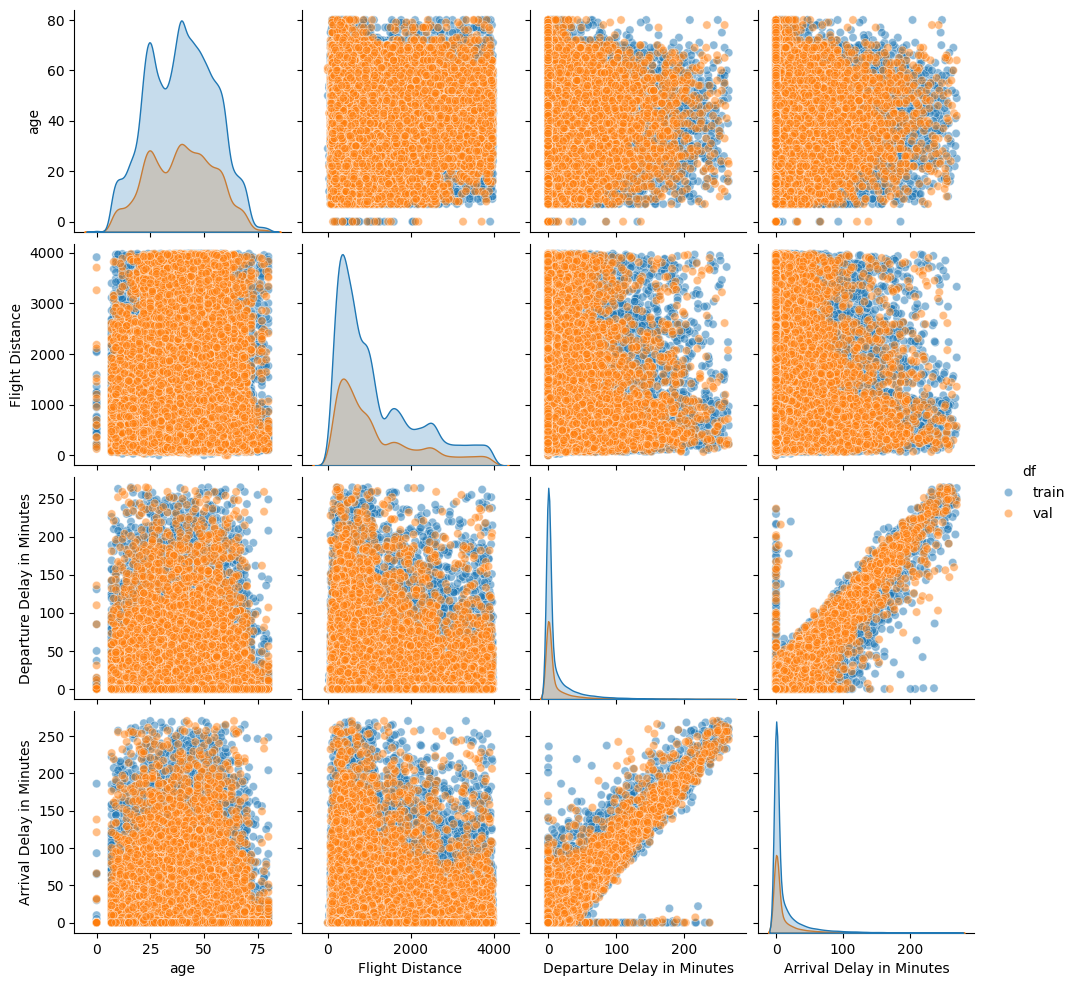

In [50]:
# your code here
# объединение трейна и теста с новым столбцом-индикатором датасета
data = pd.concat(
    [
        X_train[continuous_cols].assign(df="train"),
        X_val[continuous_cols].assign(df="val"),
    ],
    ignore_index=True,
)

# построение графика попарных распределений числовых признаков трейна и теста
sns.pairplot(data=data, hue="df", plot_kws={"alpha": 0.5})
plt.show()

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [51]:
def log1p(dataset, cols):
    """
    Замена нулевых и отрицательных значений 1.0e-10, а затем вычисление натурального логарифма плюс 1.
    """
    dataset[cols] = np.log1p(np.maximum(dataset[cols], 1.0e-10))
    return dataset

In [52]:
cols_for_log = ["Departure Delay in Minutes", "Arrival Delay in Minutes"]

df_train = log1p(df_train.copy(), cols_for_log)
X_train = log1p(X_train.copy(), cols_for_log)
X_val = log1p(X_val.copy(), cols_for_log)

Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

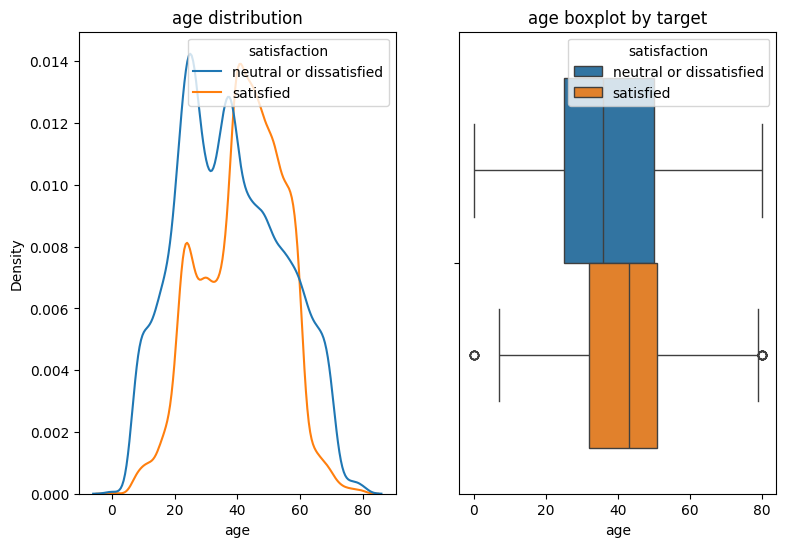

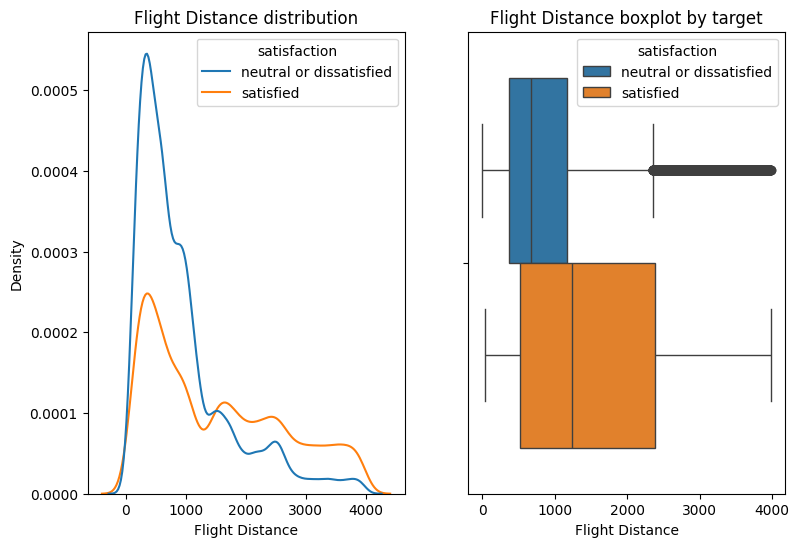

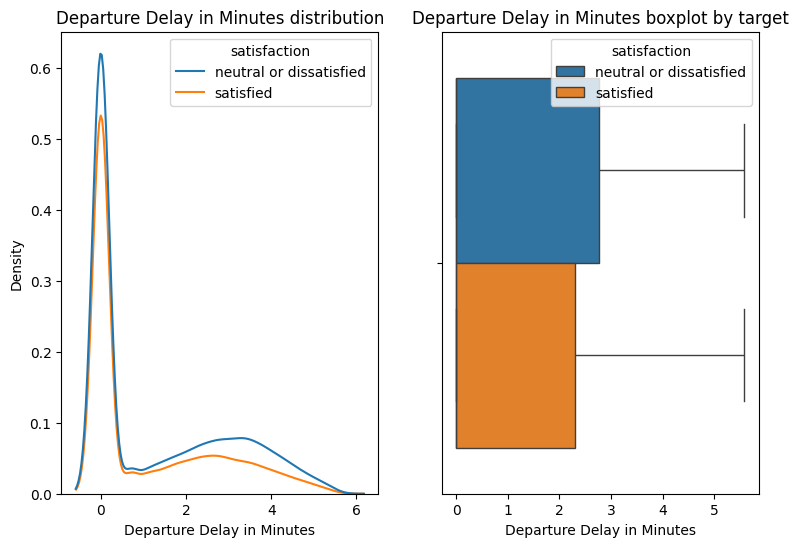

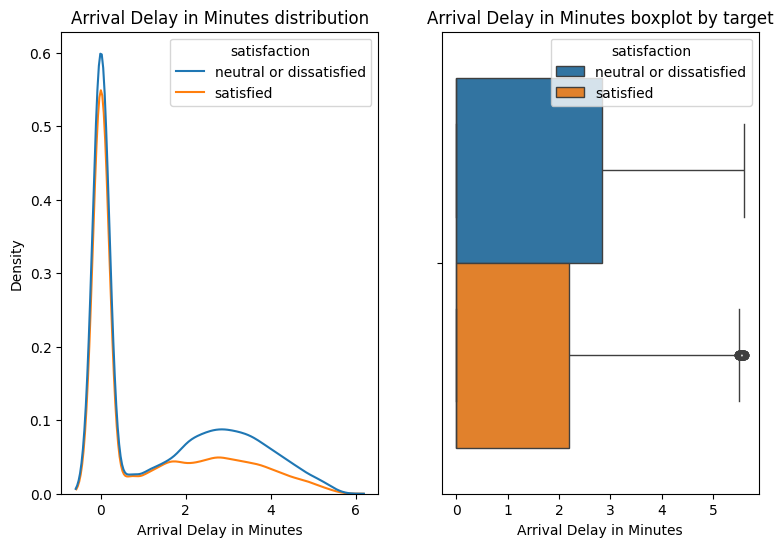

In [53]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [54]:
def replace_target_val(df):
    df = df.replace({"satisfied": 1, "neutral or dissatisfied": 0})
    return df

In [55]:
y_train = replace_target_val(y_train)
y_val = replace_target_val(y_val)

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

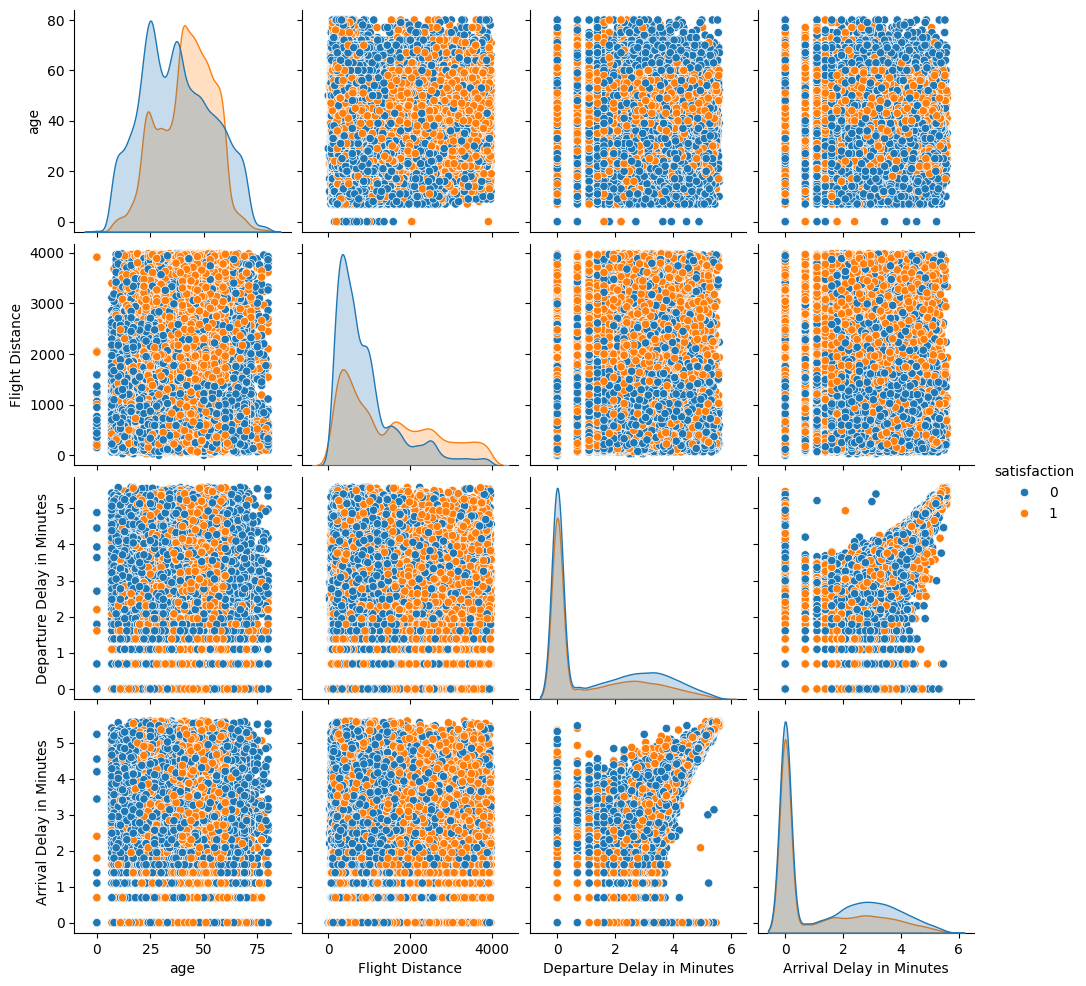

In [56]:
# your code here
cols = [
    "age",
    "Flight Distance",
    "Departure Delay in Minutes",
    "Arrival Delay in Minutes",
]

# объединение трейна и теста с новым столбцом-индикатором датасета
data = pd.concat([X_train[cols].copy(), y_train], join="inner", axis=1)

# построение графика попарных распределений числовых признаков трейна и теста
sns.pairplot(data=data, hue="satisfaction")
plt.show()

# Decision Tree (3 балла)

(0.5 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [57]:
def preprocessing_ohe(train, test):
    """
    Преобразование всех категориальных переменных методом One Hot Encoding
    """
    categorical = train.select_dtypes(include="object").columns

    ohe = OneHotEncoder(drop="first", sparse_output=False).set_output(
        transform="pandas"
    )

    transformed_train = ohe.fit_transform(train[categorical])
    transformed_test = ohe.transform(test[categorical])

    train = pd.concat([train, transformed_train], axis=1)
    train.drop(categorical, axis=1, inplace=True)

    test = pd.concat([test, transformed_test], axis=1)
    test.drop(categorical, axis=1, inplace=True)
    return train, test

In [58]:
X_train_ohe, X_val_ohe = preprocessing_ohe(X_train, X_val)
_, df_test_ohe = preprocessing_ohe(X_train, df_test)

__Utils__

In [59]:
# code here
from datetime import datetime
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import pandas as pd


def get_pred_cls_and_probs(model, X_train, X_val):
    y_pred_train, y_pred_val = model.predict(X_train), model.predict(X_val)

    y_pred_train_proba, y_pred_val_proba = (
        model.predict_proba(X_train)[:, 1],
        model.predict_proba(X_val)[:, 1],
    )

    return y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba


def get_scores(y_true, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    return accuracy, precision, recall, f1, roc_auc


def get_results_dict(
    model_save_name,
    classifier,
    y_train,
    y_val,
    y_pred_train,
    y_pred_val,
    y_pred_train_proba,
    y_pred_val_proba,
):
    date_now = datetime.now().strftime("%Y-%m-%d %H:%M")
    model_type = type(classifier).__name__

    train_metrics = [
        "train_accuracy",
        "train_precision",
        "train_recall",
        "train_f1_score",
        "train_roc_auc",
    ]
    val_metrics = [
        "val_accuracy",
        "val_precision",
        "val_recall",
        "val_f1_score",
        "val_roc_auc",
    ]

    train_scores = get_scores(y_train, y_pred_train, y_pred_train_proba)
    val_scores = get_scores(y_val, y_pred_val, y_pred_val_proba)

    results_data = {
        "Date": date_now,
        "Model Name": model_save_name,
        "Model Type": model_type,
        "Model": classifier,
        **dict(zip(train_metrics, train_scores)),
        **dict(zip(val_metrics, val_scores)),
    }

    return results_data


def get_results_df(results, indx):
    results_df = pd.DataFrame(results, index=[indx])
    results_df["Date"] = pd.to_datetime(results_df["Date"], format="%Y-%m-%d %H:%M")
    return results_df

In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


def evaluate_model_classification(classifier, X_train, y_train, X_val, y_val):
    cm_train = confusion_matrix(y_train, classifier.predict(X_train))
    cm_val = confusion_matrix(y_val, classifier.predict(X_val))

    """            True      False
     Posirtive  [0,0 (TP)  0,1 (FP)]
     Negative   [1,0 (FN)  1,1 (TN)]   """

    TP_train, TP_val = cm_train[0, 0], cm_val[0, 0]
    TN_train, TN_val = cm_train[1, 1], cm_val[1, 1]
    FP_train, FP_val = cm_train[0, 1], cm_val[0, 1]
    FN_train, FN_val = cm_train[1, 0], cm_val[1, 0]

    precision_train, precision_val = TP_train / float(
        TP_train + FP_train
    ), TP_val / float(TP_val + FP_val)

    recall_train, recall_val = TP_train / float(TP_train + FN_train), TP_val / float(
        TP_val + FN_val
    )

    fpr_train, fpr_val = FP_train / float(FP_train + TN_train), FP_val / float(
        FP_val + TN_val
    )

    specificity_train, specificity_val = TN_train / float(
        TN_train + FP_train
    ), TN_val / float(TN_val + FP_val)

    f1_score_train, f1_score_val = 2 * (precision_train * recall_train) / (
        precision_train + recall_train
    ), 2 * (precision_val * recall_val) / (precision_val + recall_val)

    ROC_AUC_train, ROC_AUC_val = roc_auc_score(
        y_train, y_pred_train_proba
    ), roc_auc_score(y_val, y_pred_val_proba)

    print("Train Support : {}".format(dict(y_train.value_counts())))
    print("-" * 50)
    print("Train Confusion Matrix:")
    print(cm_train)
    print("-" * 50)
    print(
        "Train Accuracy : {0:0.4f}".format(
            accuracy_score(y_train, classifier.predict(X_train))
        )
    )
    print("Train Precision : {0:0.4f}".format(precision_train))
    print("Train Recall/Sensitivity/TPR : {0:0.4f}".format(recall_train))
    print("Train FPR (1 - Specificity): {0:0.4f}".format(fpr_train))
    print("Train specificity : {0:0.4f}".format(specificity_train))
    print("Train f1-score : {0:0.4f}".format(f1_score_train))
    print("-" * 50)
    print("Train ROC AUC : {:.4f}".format(ROC_AUC_train))

    print(" " * 50)
    print(" " * 50)

    print("Val Support : {}".format(dict(y_val.value_counts())))
    print("-" * 50)
    print("Val Confusion Matrix:")
    print(cm_val)
    print("-" * 50)
    print(
        "Val Accuracy : {0:0.4f}".format(
            accuracy_score(y_val, classifier.predict(X_val))
        )
    )
    print("Val Precision : {0:0.4f}".format(precision_val))
    print("Val Recall/Sensitivity/TPR : {0:0.4f}".format(recall_val))
    print("Val FPR (1 - Specificity) : {0:0.4f}".format(fpr_val))
    print("Val specificity : {0:0.4f}".format(specificity_val))
    print("Val f1-score : {0:0.4f}".format(f1_score_val))
    print("-" * 50)
    print("Val ROC AUC : {:.4f}".format(ROC_AUC_val))

__Baseline__

In [61]:
null_accuracy = y_val.value_counts().loc[0] / (
    y_val.value_counts().loc[0] + y_val.value_counts().loc[1]
)

print("Null accuracy score: {0:0.4f}".format(null_accuracy))

Null accuracy score: 0.5683


<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для валидационной подвыборки

In [62]:
tree_ohe_def = DecisionTreeClassifier(random_state=0)
tree_ohe_def.fit(X_train_ohe, y_train)

y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(
    tree_ohe_def, X_train_ohe, X_val_ohe
)

In [63]:
evaluate_model_classification(tree_ohe_def, X_train_ohe, y_train, X_val_ohe, y_val)

Train Support : {0: 40484, 1: 30911}
--------------------------------------------------
Train Confusion Matrix:
[[40484     0]
 [    0 30911]]
--------------------------------------------------
Train Accuracy : 1.0000
Train Precision : 1.0000
Train Recall/Sensitivity/TPR : 1.0000
Train FPR (1 - Specificity): 0.0000
Train specificity : 1.0000
Train f1-score : 1.0000
--------------------------------------------------
Train ROC AUC : 1.0000
                                                  
                                                  
Val Support : {0: 17389, 1: 13211}
--------------------------------------------------
Val Confusion Matrix:
[[16441   948]
 [  853 12358]]
--------------------------------------------------
Val Accuracy : 0.9411
Val Precision : 0.9455
Val Recall/Sensitivity/TPR : 0.9507
Val FPR (1 - Specificity) : 0.0712
Val specificity : 0.9288
Val f1-score : 0.9481
--------------------------------------------------
Val ROC AUC : 0.9405


In [64]:
# Сохраним результат в виде df таблицы
results_data = get_results_dict(
    "0_tree_ohe_def.pkl",
    tree_ohe_def,
    y_train,
    y_val,
    y_pred_train,
    y_pred_val,
    y_pred_train_proba,
    y_pred_val_proba,
)
results_df = get_results_df(results_data, 0)

In [65]:
results_df

Date          Model Name              Model Type  \
0 2024-03-11 11:33:00  0_tree_ohe_def.pkl  DecisionTreeClassifier   

                                    Model  train_accuracy  train_precision  \
0  DecisionTreeClassifier(random_state=0)             1.0              1.0   

   train_recall  train_f1_score  train_roc_auc  val_accuracy  val_precision  \
0           1.0             1.0            1.0      0.941144       0.939715   

   val_recall  val_f1_score  val_roc_auc  
0    0.940458      0.940077     0.940458

## Деревья решений. Теоретическая вставка

(0.5 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [66]:
# change *params into what needs to be there by task condition

error_dt, bias_dt, var_dt = bias_variance_decomp(
    tree_ohe_def,
    X_train_ohe.values,
    y_train.values,
    X_val_ohe.values,
    y_val.values,
    loss="0-1_loss",
    random_seed=0,
)
error_dt, bias_dt, var_dt

(0.06192401960784315, 0.04065359477124183, 0.046213235294117645)

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

In [67]:
def plot_feature_importance(importance, names, model_type):
    fi_df = pd.DataFrame({"feature_names": names, "feature_importance": importance})
    fi_df = fi_df.sort_values(by="feature_importance", ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df["feature_importance"], y=fi_df["feature_names"])
    plt.title(model_type + " feature importance")
    plt.xlabel("Score")
    plt.ylabel("Feature Names")

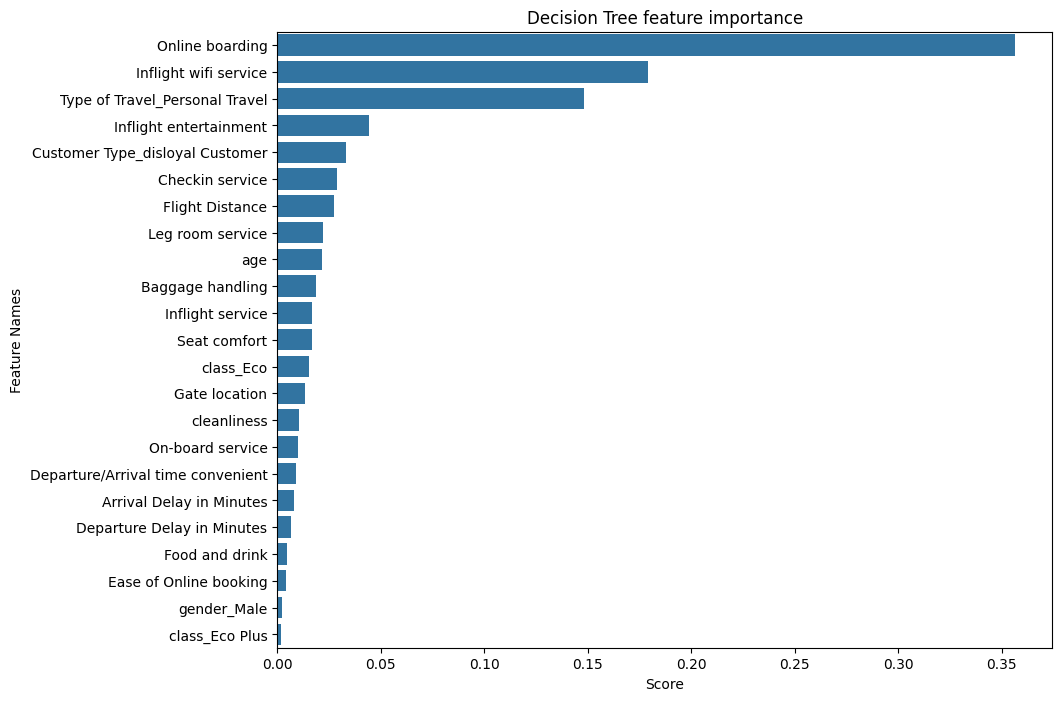

In [68]:
plot_feature_importance(
    tree_ohe_def.feature_importances_, X_train_ohe.columns, "Decision Tree"
)

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

1. Online boarding
2. Inflight wifi service
3. Type of Travel_Personal Travel

<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [69]:
print(
    f"Глубина дерева: {tree_ohe_def.get_depth()}, число листьев: {tree_ohe_def.get_n_leaves()}"
)

Глубина дерева: 33, число листьев: 2096


<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [70]:
features = ["Online boarding", "Inflight wifi service"]

tree_ohe_depth5_two_features = DecisionTreeClassifier(random_state=0, max_depth=5)
tree_ohe_depth5_two_features.fit(X_train_ohe[features], y_train)

y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(
    tree_ohe_depth5_two_features, X_train_ohe[features], X_val_ohe[features]
)

evaluate_model_classification(
    tree_ohe_depth5_two_features,
    X_train_ohe[features],
    y_train,
    X_val_ohe[features],
    y_val,
)

Train Support : {0: 40484, 1: 30911}
--------------------------------------------------
Train Confusion Matrix:
[[30297 10187]
 [ 2622 28289]]
--------------------------------------------------
Train Accuracy : 0.8206
Train Precision : 0.7484
Train Recall/Sensitivity/TPR : 0.9203
Train FPR (1 - Specificity): 0.2648
Train specificity : 0.7352
Train f1-score : 0.8255
--------------------------------------------------
Train ROC AUC : 0.8980
                                                  
                                                  
Val Support : {0: 17389, 1: 13211}
--------------------------------------------------
Val Confusion Matrix:
[[13105  4284]
 [ 1076 12135]]
--------------------------------------------------
Val Accuracy : 0.8248
Val Precision : 0.7536
Val Recall/Sensitivity/TPR : 0.9241
Val FPR (1 - Specificity) : 0.2609
Val specificity : 0.7391
Val f1-score : 0.8302
--------------------------------------------------
Val ROC AUC : 0.9021


In [71]:
results_data = get_results_dict(
    "1_tree_ohe_depth5_two_features.pkl",
    tree_ohe_depth5_two_features,
    y_train,
    y_val,
    y_pred_train,
    y_pred_val,
    y_pred_train_proba,
    y_pred_val_proba,
)
results_df_to_concat = get_results_df(results_data, 1)
results_df = pd.concat([results_df, results_df_to_concat])

In [72]:
results_df

Date                          Model Name  \
0 2024-03-11 11:33:00                  0_tree_ohe_def.pkl   
1 2024-03-11 11:35:00  1_tree_ohe_depth5_two_features.pkl   

               Model Type                                              Model  \
0  DecisionTreeClassifier             DecisionTreeClassifier(random_state=0)   
1  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   

   train_accuracy  train_precision  train_recall  train_f1_score  \
0         1.00000         1.000000      1.000000        1.000000   
1         0.82059         0.827794      0.831773        0.820448   

   train_roc_auc  val_accuracy  val_precision  val_recall  val_f1_score  \
0       1.000000      0.941144       0.939715    0.940458      0.940077   
1       0.897977      0.824837       0.831603    0.836095      0.824660   

   val_roc_auc  
0     0.940458  
1     0.902055

Переобучение снизили, качество упало.

(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

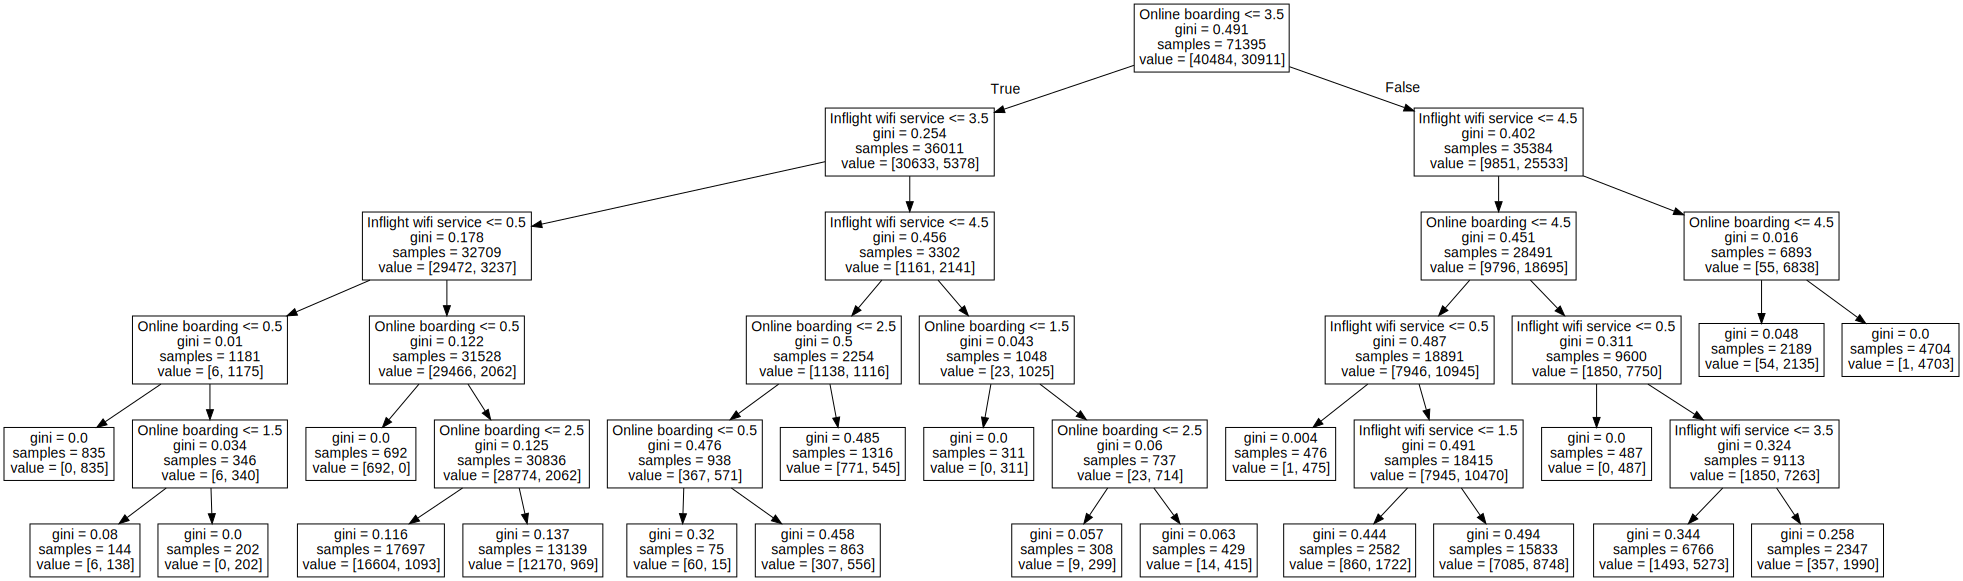

In [73]:
# feel free to google

import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(
    tree_ohe_depth5_two_features,
    out_file=None,
    feature_names=tree_ohe_depth5_two_features.feature_names_in_,
    filled=False,
)
graph = graphviz.Source(dot_data, format="png")
graph

Кратность предикатов 0.5, обусловлена оптимальным разбиением где значение признака ближе к целому числу. К тому же, берутся усредененные отсортированные значения соседних по величине предикатов.

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договорённости) признаков</font>

In [74]:
# your code below
features = ["age", "Flight Distance"]

tree_ohe_depth5_two_features_contin = DecisionTreeClassifier(
    random_state=0, max_depth=5
)
tree_ohe_depth5_two_features_contin.fit(X_train_ohe[features], y_train)

y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(
    tree_ohe_depth5_two_features_contin, X_train_ohe[features], X_val_ohe[features]
)

evaluate_model_classification(
    tree_ohe_depth5_two_features_contin,
    X_train_ohe[features],
    y_train,
    X_val_ohe[features],
    y_val,
)

Train Support : {0: 40484, 1: 30911}
--------------------------------------------------
Train Confusion Matrix:
[[35079  5405]
 [17556 13355]]
--------------------------------------------------
Train Accuracy : 0.6784
Train Precision : 0.8665
Train Recall/Sensitivity/TPR : 0.6665
Train FPR (1 - Specificity): 0.2881
Train specificity : 0.7119
Train f1-score : 0.7534
--------------------------------------------------
Train ROC AUC : 0.7237
                                                  
                                                  
Val Support : {0: 17389, 1: 13211}
--------------------------------------------------
Val Confusion Matrix:
[[15136  2253]
 [ 7427  5784]]
--------------------------------------------------
Val Accuracy : 0.6837
Val Precision : 0.8704
Val Recall/Sensitivity/TPR : 0.6708
Val FPR (1 - Specificity) : 0.2803
Val specificity : 0.7197
Val f1-score : 0.7577
--------------------------------------------------
Val ROC AUC : 0.7284


In [75]:
results_data = get_results_dict(
    "2_tree_ohe_depth5_two_features_contin.pkl",
    tree_ohe_depth5_two_features_contin,
    y_train,
    y_val,
    y_pred_train,
    y_pred_val,
    y_pred_train_proba,
    y_pred_val_proba,
)
results_df_to_concat = get_results_df(results_data, 2)
results_df = pd.concat([results_df, results_df_to_concat])

In [76]:
results_df

Date                                 Model Name  \
0 2024-03-11 11:33:00                         0_tree_ohe_def.pkl   
1 2024-03-11 11:35:00         1_tree_ohe_depth5_two_features.pkl   
2 2024-03-11 11:35:00  2_tree_ohe_depth5_two_features_contin.pkl   

               Model Type                                              Model  \
0  DecisionTreeClassifier             DecisionTreeClassifier(random_state=0)   
1  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
2  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   

   train_accuracy  train_precision  train_recall  train_f1_score  \
0        1.000000         1.000000      1.000000        1.000000   
1        0.820590         0.827794      0.831773        0.820448   
2        0.678395         0.689172      0.649269        0.645581   

   train_roc_auc  val_accuracy  val_precision  val_recall  val_f1_score  \
0       1.000000      0.941144       0.939715    0.940458      0.940077   
1       0.897977      0.824837       0.831603    0.836095      0.824660   
2       0.723717      0.683660       0.695252    0.654126      0.651068   

   val_roc_auc  
0     0.940458  
1     0.902055  
2     0.728443

(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

[Text(0.5, 0.9166666666666666, 'Flight Distance <= 1499.5\ngini = 0.491\nsamples = 100.0%\nvalue = [0.567, 0.433]'),
 Text(0.25, 0.75, 'age <= 37.5\ngini = 0.447\nsamples = 69.9%\nvalue = [0.663, 0.337]'),
 Text(0.125, 0.5833333333333334, 'age <= 19.5\ngini = 0.394\nsamples = 33.9%\nvalue = [0.731, 0.269]'),
 Text(0.0625, 0.4166666666666667, 'age <= 16.5\ngini = 0.265\nsamples = 7.8%\nvalue = [0.843, 0.157]'),
 Text(0.03125, 0.25, 'Flight Distance <= 489.5\ngini = 0.237\nsamples = 5.6%\nvalue = [0.862, 0.138]'),
 Text(0.015625, 0.08333333333333333, 'gini = 0.195\nsamples = 2.1%\nvalue = [0.891, 0.109]'),
 Text(0.046875, 0.08333333333333333, 'gini = 0.262\nsamples = 3.5%\nvalue = [0.845, 0.155]'),
 Text(0.09375, 0.25, 'Flight Distance <= 505.0\ngini = 0.327\nsamples = 2.2%\nvalue = [0.794, 0.206]'),
 Text(0.078125, 0.08333333333333333, 'gini = 0.249\nsamples = 1.0%\nvalue = [0.854, 0.146]'),
 Text(0.109375, 0.08333333333333333, 'gini = 0.376\nsamples = 1.3%\nvalue = [0.749, 0.251]'),
 T

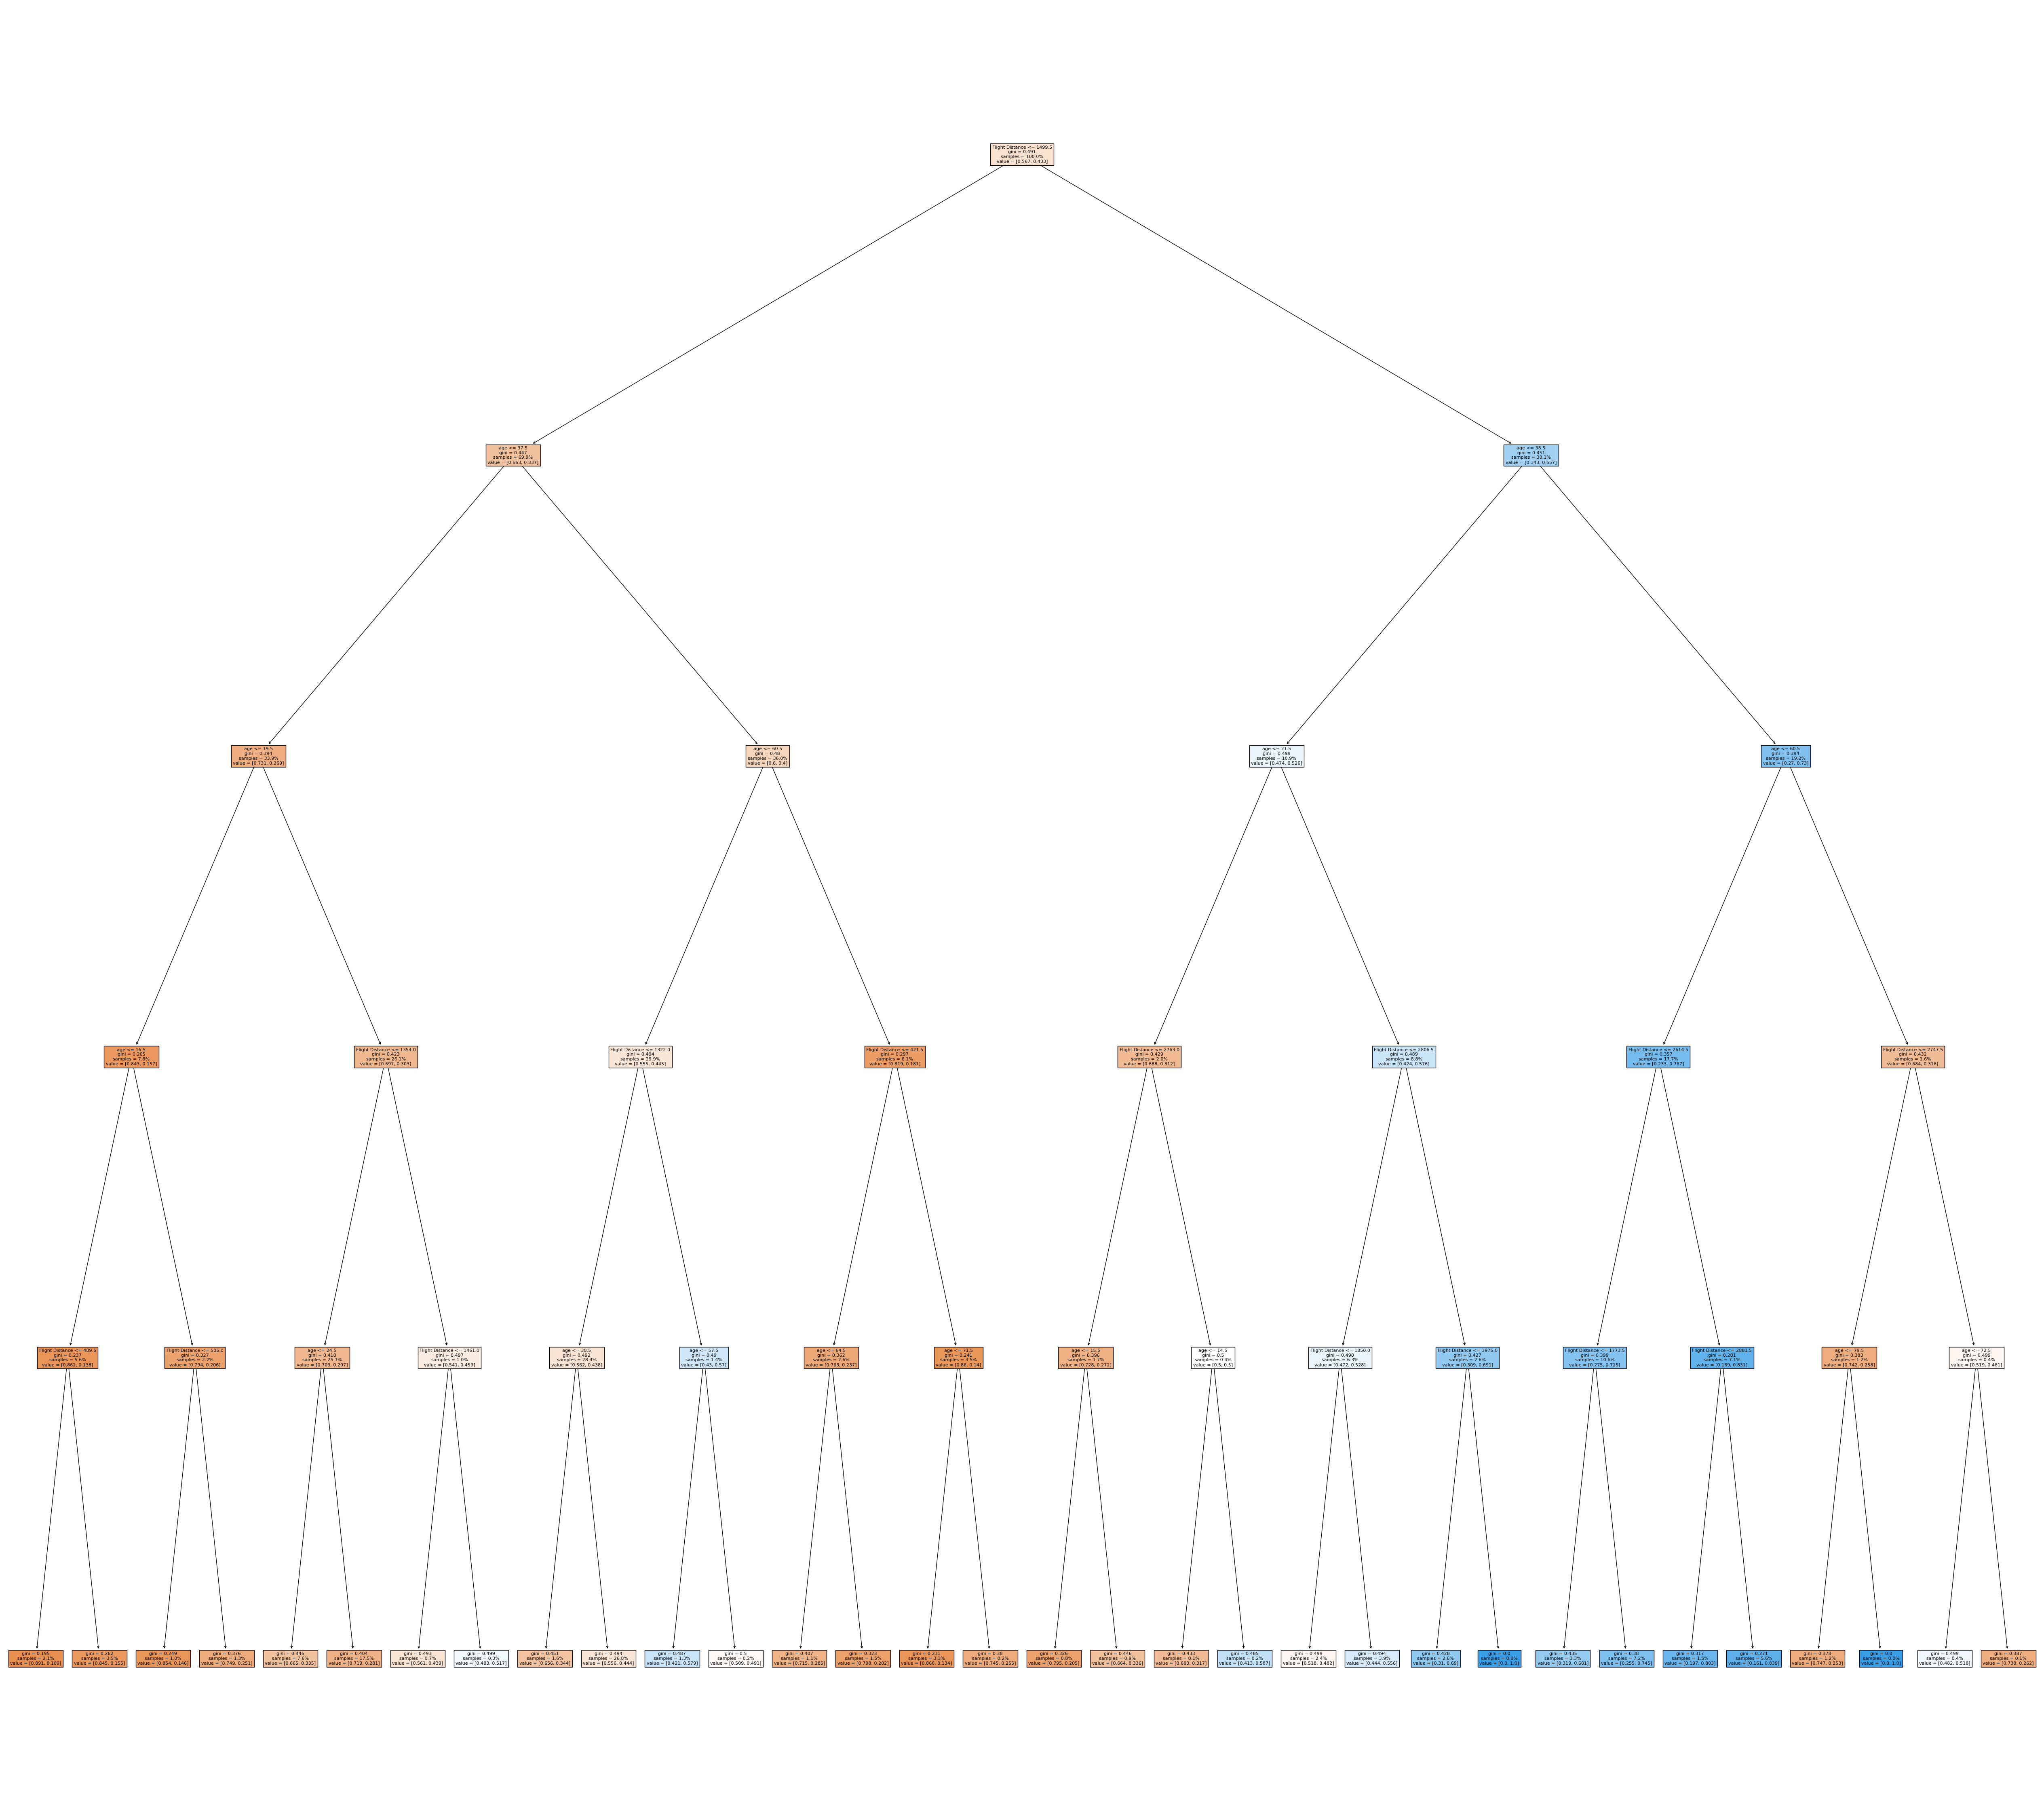

In [77]:
# another place to code a few lines
from sklearn import tree


plt.figure(figsize=(65, 58))
tree.plot_tree(
    tree_ohe_depth5_two_features_contin,
    filled=True,
    proportion=True,
    feature_names=tree_ohe_depth5_two_features_contin.feature_names_in_,
)

Симметричные деревья, могут обучаться быстрее в следствии:

- Более равномерного разделения классов: Сбалансированные деревья стремятся к равномерному разделению классов в каждом узле, что может привести к более эффективному обучению. Это позволяет алгоритму быстрее и эффективнее принимать решения о разделении данных на каждом этапе построения дерева;

- Меньшего перекоса в данных который усложняет процесс обучения. Сбалансированные деревья стараются минимизировать этот перекос;

- Использовании оптимизированных алгоритмов работающих с матрицами.

(0.5 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Axes: >

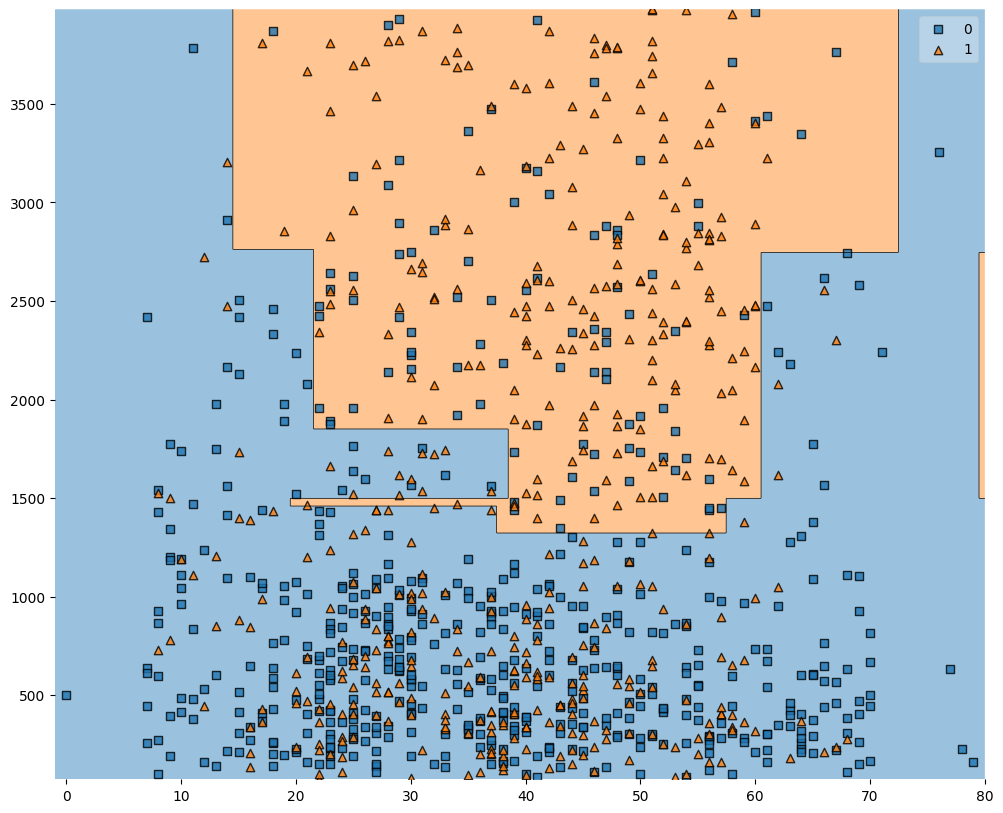

In [78]:
# your line of code
from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(12, 10))
plot_decision_regions(
    clf=tree_ohe_depth5_two_features_contin,
    X=np.array(X_train_ohe[features].iloc[:1000, :]),
    y=np.array(y_train[:1000]),
)

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

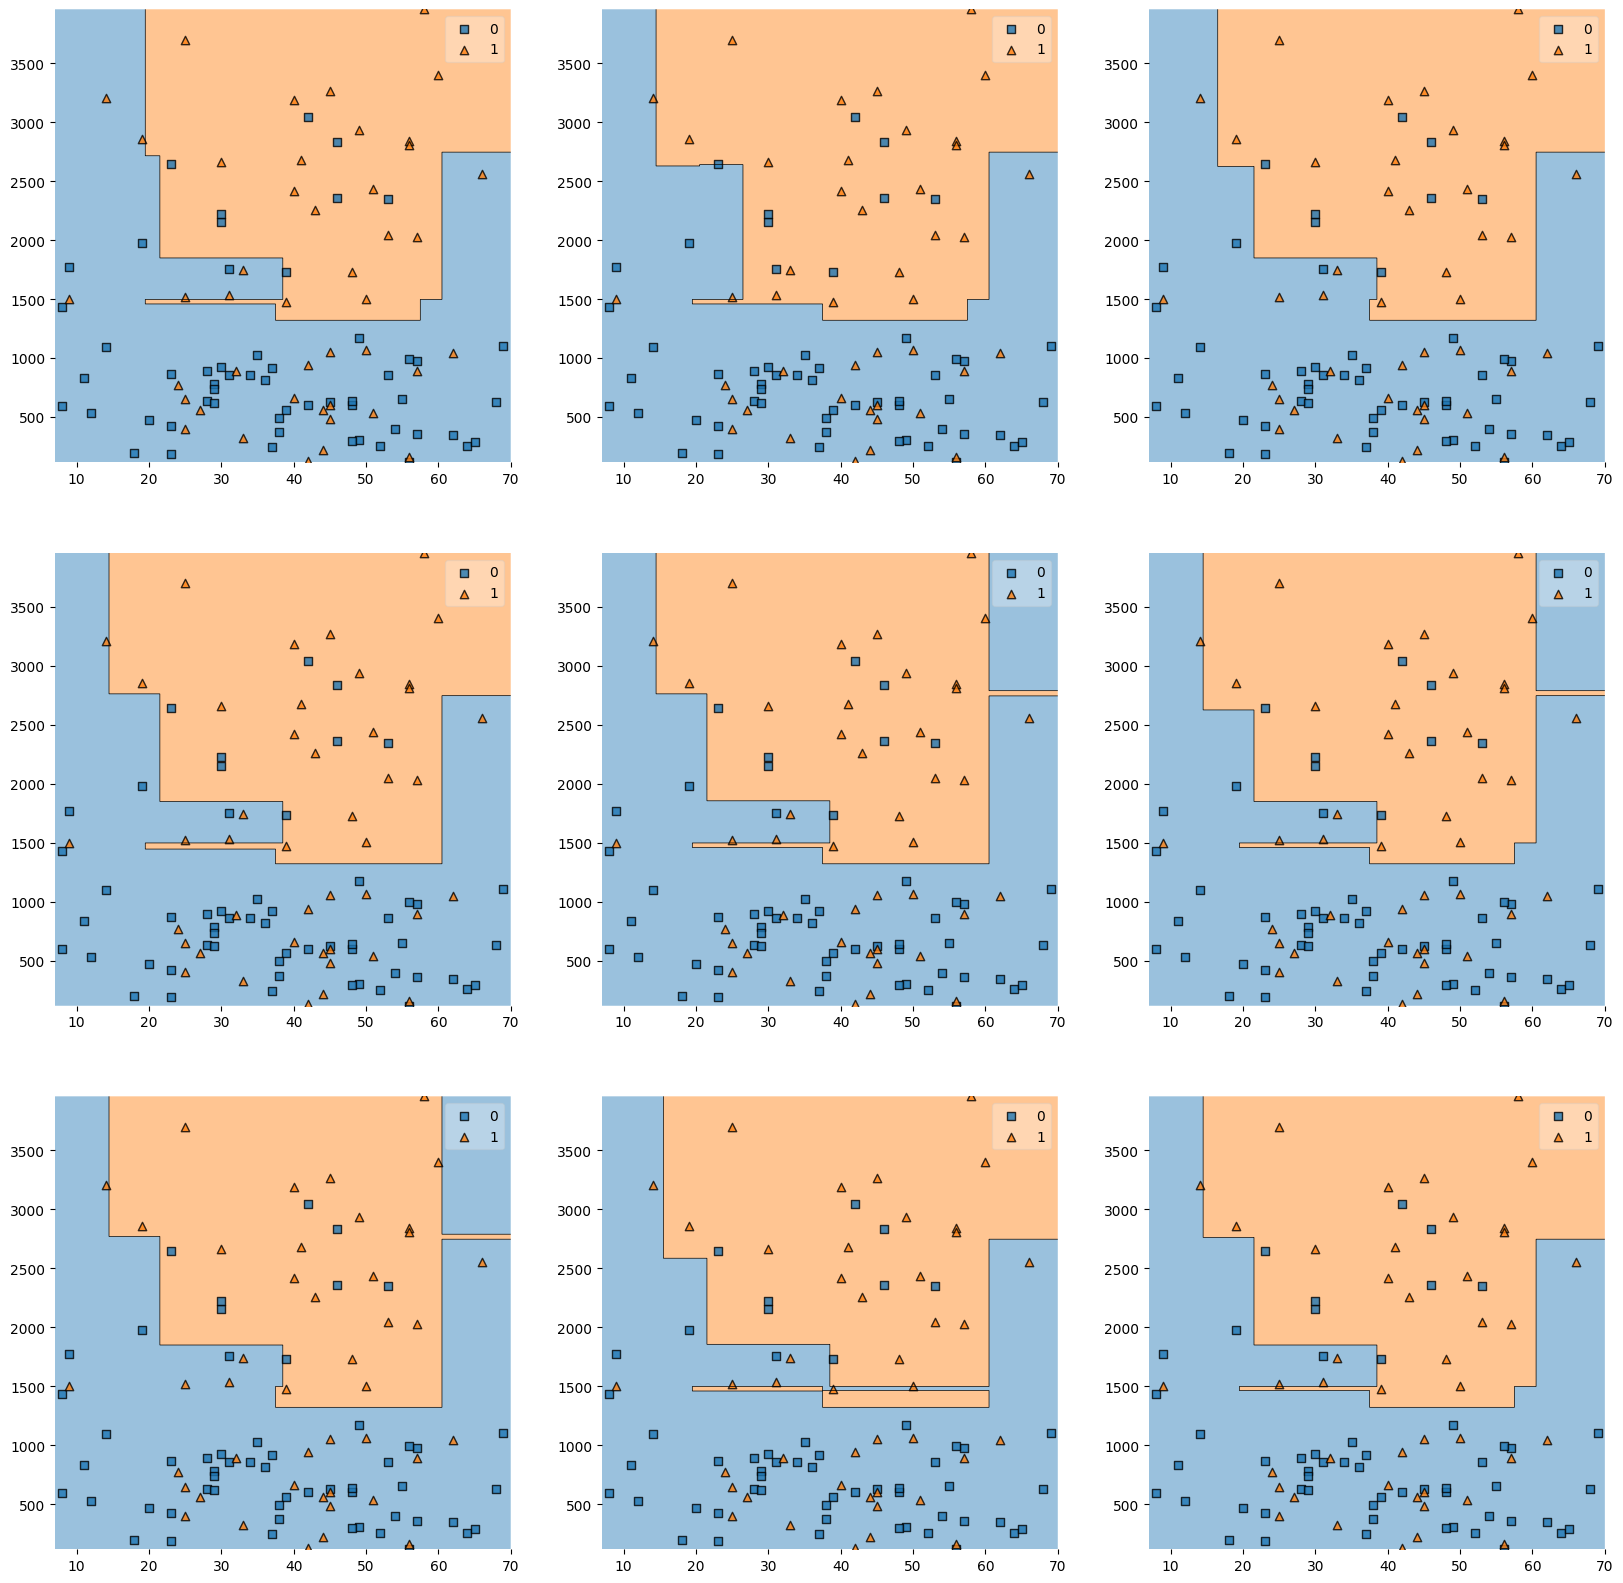

In [79]:
# change X_train_example to your equivalent

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(
            X_train_ohe[features].index,
            size=X_train_ohe[features].shape[0] - 5000,
            replace=False,
        )  # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_ohe[features].loc[inds, :], y_train[inds])

        plot_decision_regions(
            clf=tree_exp,
            X=np.array(X_train_ohe[features].iloc[:100, :]),
            y=np.array(y_train[:100]),
            ax=ax[row][col],
        )

Мы убирали из трейна (а в нем ~80к наблюдений) всего по 5 тысяч случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [80]:
# change X_train_enc into your ohe-encoded train set

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_ohe[features], y_train)
    y_predicted_train = DT.predict(X_train_ohe[features])
    y_predicted_val = DT.predict(X_val_ohe[features])
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 2.74 s, sys: 6.35 ms, total: 2.75 s
Wall time: 2.81 s


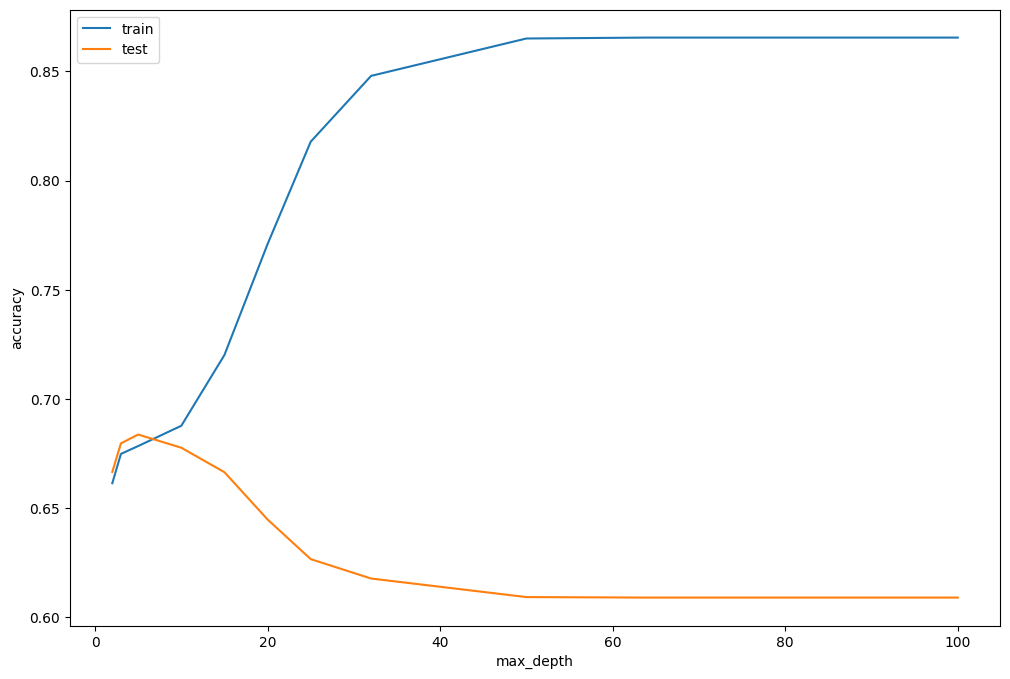

In [81]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(["train", "test"])
plt.ylabel("accuracy")
plt.xlabel("max_depth")
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font> *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

Исследуем дерево на зависимость его качества от гиперпараметров.

In [82]:
# you know what to do
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D


def plt_explore_params(name_xlab, params):
    """
    Составим дерево решений с заданными параметрами по заданному диапазону и построим график результатов обучения и тестирования AUC.
    """
    key, values = list(params.items())[0]

    train_results = []
    test_results = []

    for val in tqdm(values):
        params = {key: val}
        dt = DecisionTreeClassifier(**params, random_state=0)
        dt.fit(X_train_ohe, y_train)
        train_pred = dt.predict(X_train_ohe)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(
            y_train, train_pred
        )
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)

        y_pred = dt.predict(X_val_ohe)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)

    (line1,) = plt.plot(values, train_results, "b", label="Train AUC")
    (line2,) = plt.plot(values, test_results, "r", label="Val AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("AUC score")
    plt.xlabel(f"{name_xlab}")
    plt.show()

100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


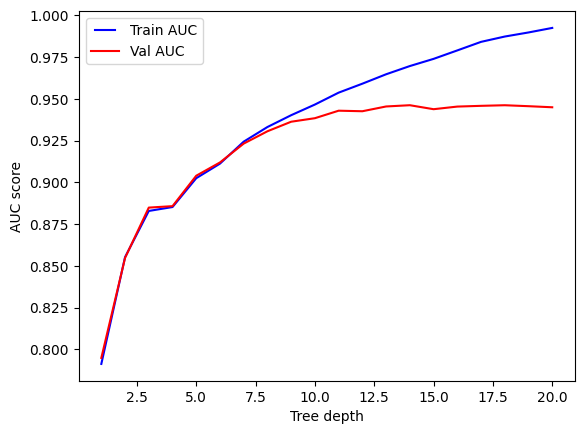

In [83]:
plt_explore_params(
    "Tree depth", {"max_depth": np.linspace(1, 20, 20, endpoint=True, dtype=int)}
)

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


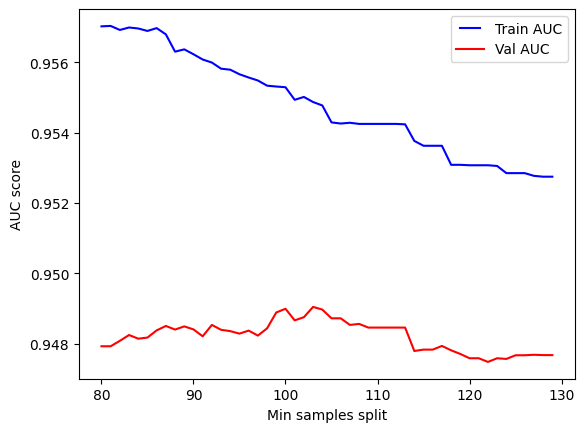

In [84]:
# Минимальное количество объектов, необходимое для разделения предиката (внутреннего узла)
plt_explore_params("Min samples split", {"min_samples_split": np.arange(80, 130)})

100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


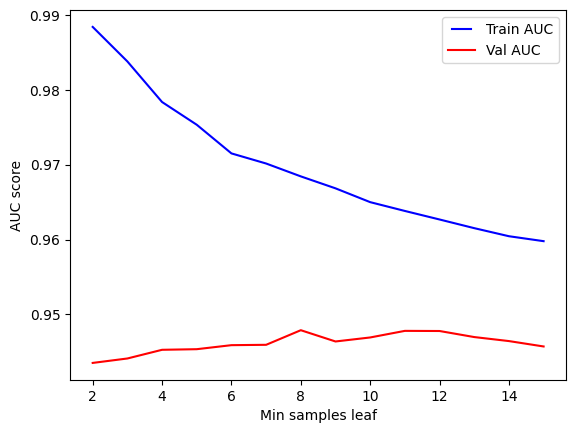

In [85]:
# Минимальное количество объектов, которое должно находиться в листовом узле.
plt_explore_params("Min samples leaf", {"min_samples_leaf": np.arange(2, 16)})

In [86]:
params = {
    "max_depth": np.arange(10, 15),
    "min_samples_split": np.arange(95, 105),
    "min_samples_leaf": np.arange(8, 12),
    "criterion": ["gini", "entropy"],
}

In [87]:
tree_ohe_def

DecisionTreeClassifier(random_state=0)

In [88]:
grid_search = GridSearchCV(
    estimator=tree_ohe_def,
    param_grid=params,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="roc_auc",
)

In [89]:
%%time
grid_search.fit(X_train_ohe, y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
CPU times: user 12.4 s, sys: 2.43 s, total: 14.9 s
Wall time: 4min 54s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 11, 12, 13, 14]),
                         'min_samples_leaf': array([ 8,  9, 10, 11]),
                         'min_samples_split': array([ 95,  96,  97,  98,  99, 100, 101, 102, 103, 104])},
             scoring='roc_auc', verbose=2)

In [90]:
pd.DataFrame(grid_search.cv_results_).nlargest(3, "mean_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
399       0.381654      0.015546         0.020418        0.004590   
397       0.402844      0.016387         0.023187        0.003099   
398       0.404076      0.007892         0.025573        0.004837   

    param_criterion param_max_depth param_min_samples_leaf  \
399         entropy              14                     11   
397         entropy              14                     11   
398         entropy              14                     11   

    param_min_samples_split  \
399                     104   
397                     102   
398                     103   

                                                params  split0_test_score  \
399  {'criterion': 'entropy', 'max_depth': 14, 'min...           0.988765   
397  {'criterion': 'entropy', 'max_depth': 14, 'min...           0.988695   
398  {'criterion': 'entropy', 'max_depth': 14, 'min...           0.988695   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
399           0.989552           0.988163         0.988826        0.000569   
397           0.989552           0.988170         0.988806        0.000570   
398           0.989552           0.988168         0.988805        0.000571   

     rank_test_score  
399                1  
397                2  
398                3

In [91]:
tree_ohe_CV_best = grid_search.best_estimator_
tree_ohe_CV_best_params = grid_search.best_params_

tree_ohe_CV_best

DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=11,
                       min_samples_split=104, random_state=0)

In [92]:
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(
    tree_ohe_CV_best, X_train_ohe, X_val_ohe
)

evaluate_model_classification(tree_ohe_CV_best, X_train_ohe, y_train, X_val_ohe, y_val)

Train Support : {0: 40484, 1: 30911}
--------------------------------------------------
Train Confusion Matrix:
[[39504   980]
 [ 2230 28681]]
--------------------------------------------------
Train Accuracy : 0.9550
Train Precision : 0.9758
Train Recall/Sensitivity/TPR : 0.9466
Train FPR (1 - Specificity): 0.0330
Train specificity : 0.9670
Train f1-score : 0.9610
--------------------------------------------------
Train ROC AUC : 0.9929
                                                  
                                                  
Val Support : {0: 17389, 1: 13211}
--------------------------------------------------
Val Confusion Matrix:
[[16936   453]
 [ 1050 12161]]
--------------------------------------------------
Val Accuracy : 0.9509
Val Precision : 0.9739
Val Recall/Sensitivity/TPR : 0.9416
Val FPR (1 - Specificity) : 0.0359
Val specificity : 0.9641
Val f1-score : 0.9575
--------------------------------------------------
Val ROC AUC : 0.9907


In [93]:
results_data = get_results_dict(
    "3_tree_ohe_CV_best.pkl",
    tree_ohe_CV_best,
    y_train,
    y_val,
    y_pred_train,
    y_pred_val,
    y_pred_train_proba,
    y_pred_val_proba,
)
results_df_to_concat = get_results_df(results_data, 3)
results_df = pd.concat([results_df, results_df_to_concat])

In [94]:
results_df

Date                                 Model Name  \
0 2024-03-11 11:33:00                         0_tree_ohe_def.pkl   
1 2024-03-11 11:35:00         1_tree_ohe_depth5_two_features.pkl   
2 2024-03-11 11:35:00  2_tree_ohe_depth5_two_features_contin.pkl   
3 2024-03-11 11:41:00                     3_tree_ohe_CV_best.pkl   

               Model Type                                              Model  \
0  DecisionTreeClassifier             DecisionTreeClassifier(random_state=0)   
1  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
2  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
3  DecisionTreeClassifier  DecisionTreeClassifier(criterion='entropy', ma...   

   train_accuracy  train_precision  train_recall  train_f1_score  \
0        1.000000         1.000000      1.000000        1.000000   
1        0.820590         0.827794      0.831773        0.820448   
2        0.678395         0.689172      0.649269        0.645581   
3        0.955039         0.956763      0.951825        0.953981   

   train_roc_auc  val_accuracy  val_precision  val_recall  val_f1_score  \
0       1.000000      0.941144       0.939715    0.940458      0.940077   
1       0.897977      0.824837       0.831603    0.836095      0.824660   
2       0.723717      0.683660       0.695252    0.654126      0.651068   
3       0.992945      0.950882       0.952854    0.947235      0.949656   

   val_roc_auc  
0     0.940458  
1     0.902055  
2     0.728443  
3     0.990708

__Прунинг дерева__

In [95]:
# Визуализируем последнюю модель дерева
def get_dt_graph(dt_classifier):
    fig = plt.figure(figsize=(25, 20))
    _ = tree.plot_tree(
        dt_classifier,
        feature_names=X_train_ohe.columns,
        class_names=["1", "0"],
        filled=True,
    )

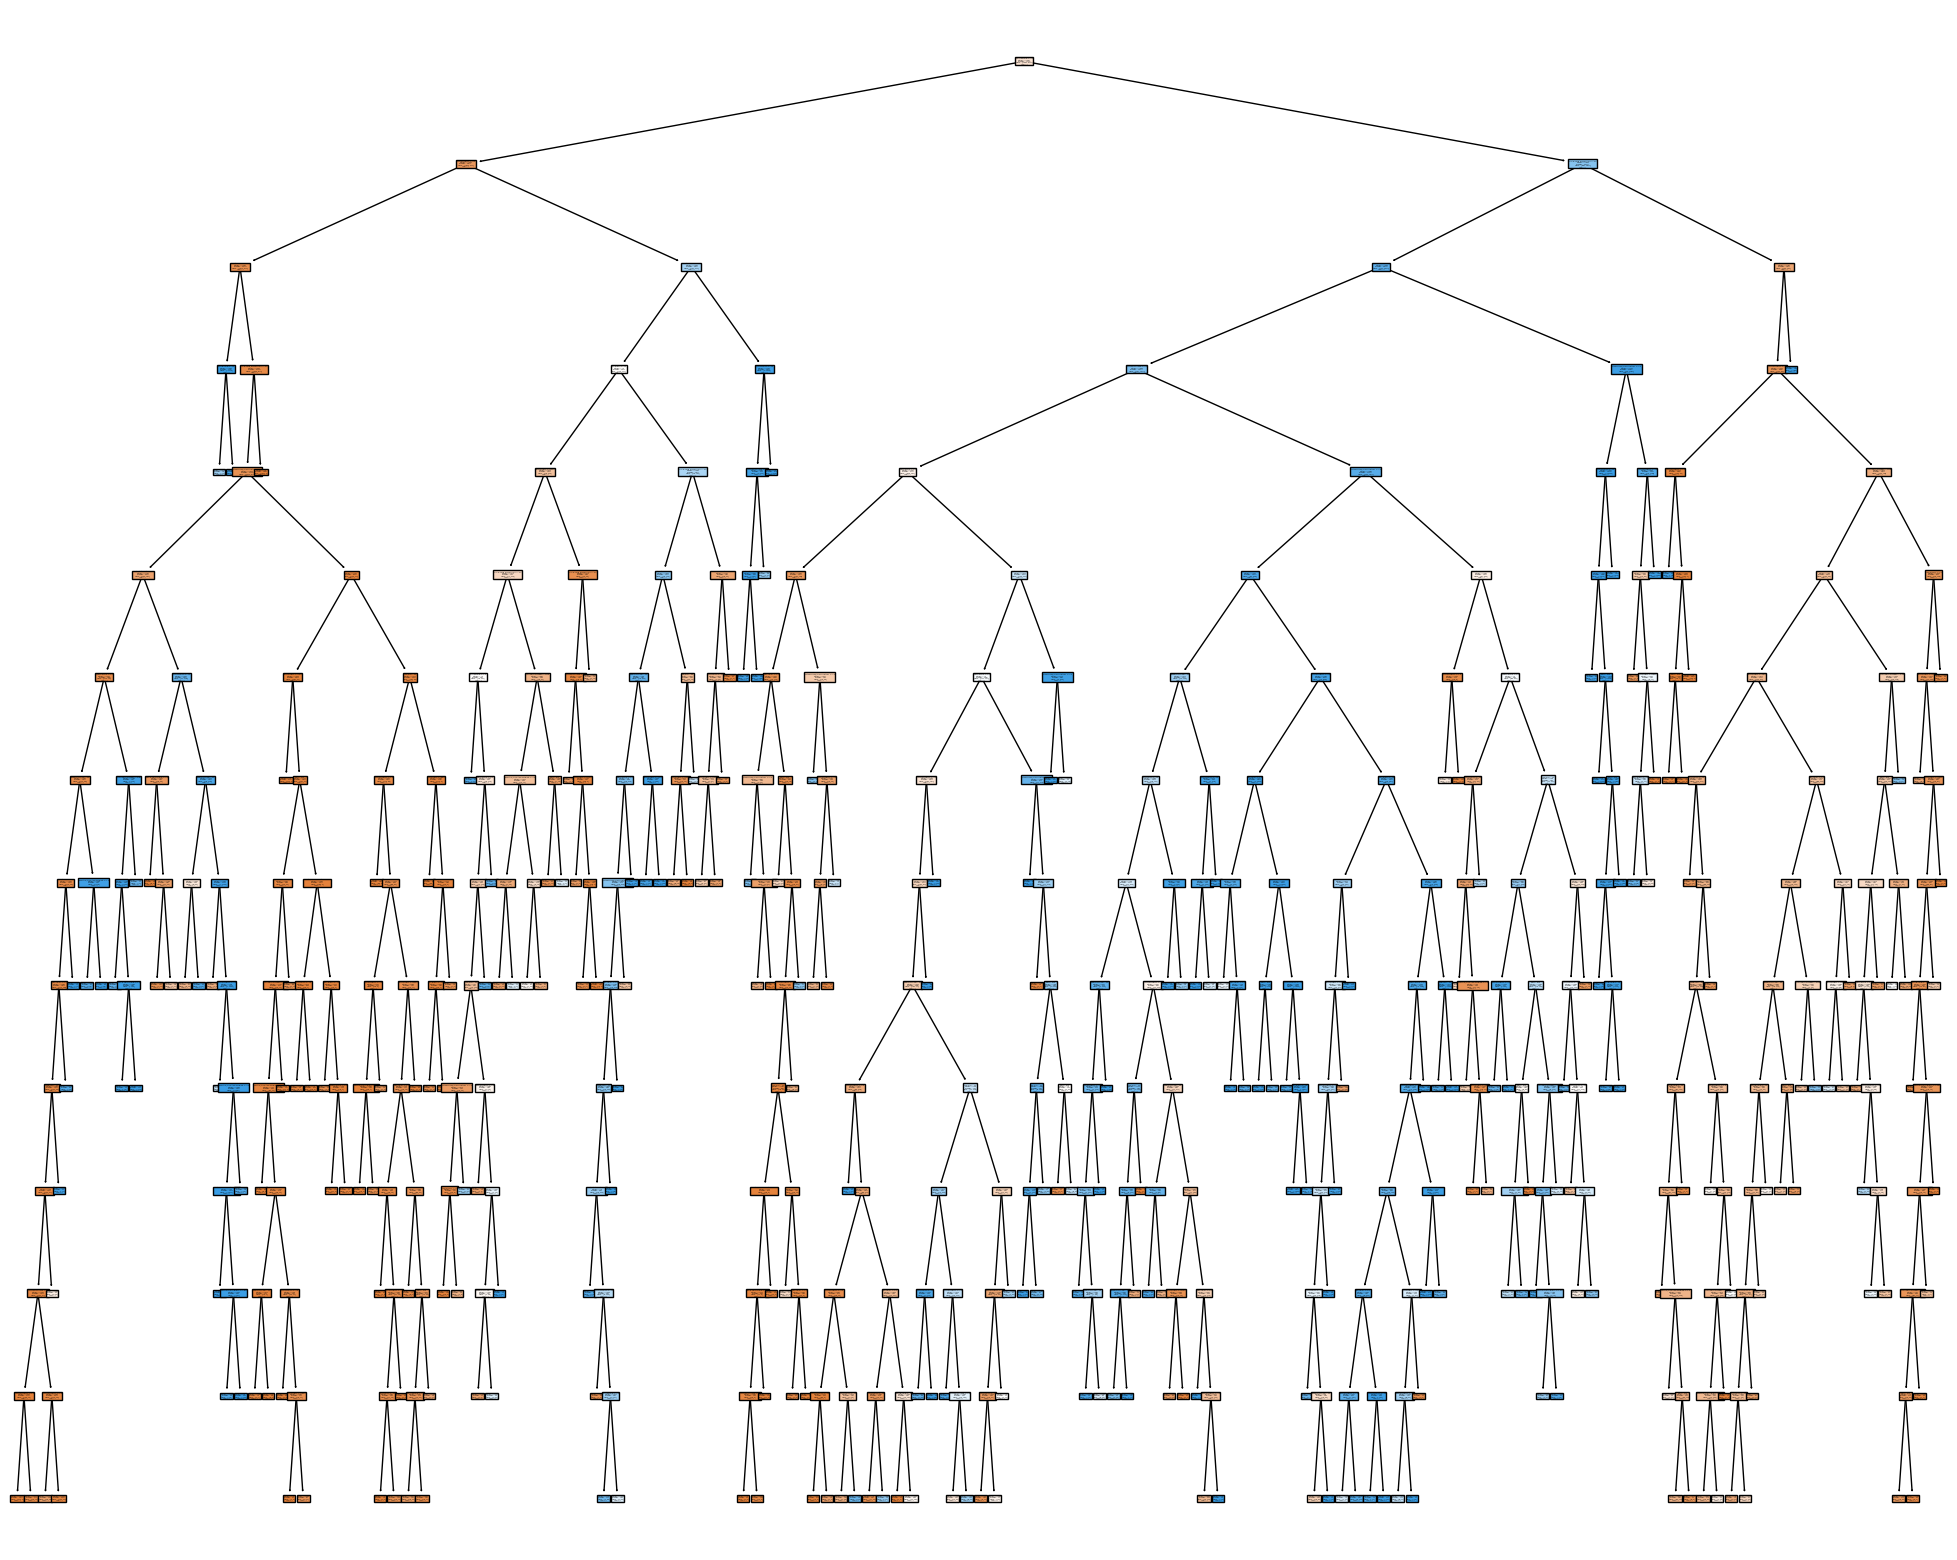

In [96]:
get_dt_graph(tree_ohe_CV_best)

In [97]:
path = tree_ohe_CV_best.cost_complexity_pruning_path(X_train_ohe, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [98]:
ccp_alphas_cut = ccp_alphas[:150]

clfs = []

for ccp_alpha in tqdm(ccp_alphas_cut):
    clf = DecisionTreeClassifier(**tree_ohe_CV_best_params, ccp_alpha=ccp_alpha)
    clf.fit(X_train_ohe, y_train)
    clfs.append(clf)

100%|██████████| 150/150 [01:00<00:00,  2.47it/s]


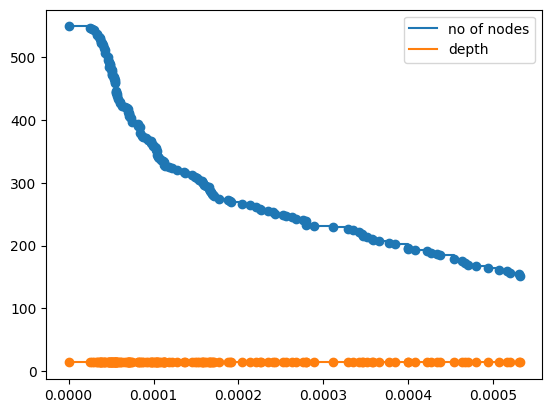

In [99]:
# Удалим последний элемент в clfs и ccp_alphas, поскольку это тривиальное дерево только с одним узлом.
# По  мере увеличения альфа количество узлов и глубина уменьшаются.
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

plt.scatter(ccp_alphas_cut, node_counts)
plt.scatter(ccp_alphas_cut, depth)
plt.plot(ccp_alphas_cut, node_counts, label="no of nodes", drawstyle="steps-post")
plt.plot(ccp_alphas_cut, depth, label="depth", drawstyle="steps-post")
plt.legend()
plt.show()

100%|██████████| 150/150 [00:08<00:00, 18.09it/s]


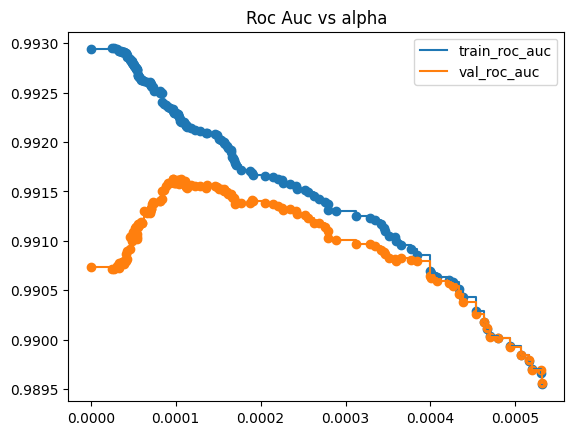

In [100]:
train_roc_auc = []
val_roc_auc = []

for c in tqdm(clfs):
    y_train_pred = c.predict_proba(X_train_ohe)[:, 1]
    y_test_pred = c.predict_proba(X_val_ohe)[:, 1]
    train_roc_auc.append(roc_auc_score(y_train, y_train_pred))
    val_roc_auc.append(roc_auc_score(y_val, y_test_pred))

plt.scatter(ccp_alphas_cut, train_roc_auc)
plt.scatter(ccp_alphas_cut, val_roc_auc)

plt.plot(ccp_alphas_cut, train_roc_auc, label="train_roc_auc", drawstyle="steps-post")
plt.plot(ccp_alphas_cut, val_roc_auc, label="val_roc_auc", drawstyle="steps-post")
plt.legend()
plt.title("Roc Auc vs alpha")
plt.show()

Выберем наилучшее **alpha=0.00011**

In [101]:
ccp_alpha = 0.00011

tree_ohe_CV_best_pruning = DecisionTreeClassifier(
    **tree_ohe_CV_best_params, random_state=0, ccp_alpha=ccp_alpha
)
tree_ohe_CV_best_pruning.fit(X_train_ohe, y_train)

y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(
    tree_ohe_CV_best_pruning, X_train_ohe, X_val_ohe
)

evaluate_model_classification(
    tree_ohe_CV_best_pruning, X_train_ohe, y_train, X_val_ohe, y_val
)

Train Support : {0: 40484, 1: 30911}
--------------------------------------------------
Train Confusion Matrix:
[[39544   940]
 [ 2345 28566]]
--------------------------------------------------
Train Accuracy : 0.9540
Train Precision : 0.9768
Train Recall/Sensitivity/TPR : 0.9440
Train FPR (1 - Specificity): 0.0319
Train specificity : 0.9681
Train f1-score : 0.9601
--------------------------------------------------
Train ROC AUC : 0.9922
                                                  
                                                  
Val Support : {0: 17389, 1: 13211}
--------------------------------------------------
Val Confusion Matrix:
[[16985   404]
 [ 1061 12150]]
--------------------------------------------------
Val Accuracy : 0.9521
Val Precision : 0.9768
Val Recall/Sensitivity/TPR : 0.9412
Val FPR (1 - Specificity) : 0.0322
Val specificity : 0.9678
Val f1-score : 0.9587
--------------------------------------------------
Val ROC AUC : 0.9916


In [102]:
results_data = get_results_dict(
    "4_tree_ohe_CV_best_pruning.pkl",
    tree_ohe_CV_best_pruning,
    y_train,
    y_val,
    y_pred_train,
    y_pred_val,
    y_pred_train_proba,
    y_pred_val_proba,
)
results_df_to_concat = get_results_df(results_data, 4)
results_df = pd.concat([results_df, results_df_to_concat])

In [103]:
results_df

Date                                 Model Name  \
0 2024-03-11 11:33:00                         0_tree_ohe_def.pkl   
1 2024-03-11 11:35:00         1_tree_ohe_depth5_two_features.pkl   
2 2024-03-11 11:35:00  2_tree_ohe_depth5_two_features_contin.pkl   
3 2024-03-11 11:41:00                     3_tree_ohe_CV_best.pkl   
4 2024-03-11 11:43:00             4_tree_ohe_CV_best_pruning.pkl   

               Model Type                                              Model  \
0  DecisionTreeClassifier             DecisionTreeClassifier(random_state=0)   
1  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
2  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
3  DecisionTreeClassifier  DecisionTreeClassifier(criterion='entropy', ma...   
4  DecisionTreeClassifier  DecisionTreeClassifier(ccp_alpha=0.00011, crit...   

   train_accuracy  train_precision  train_recall  train_f1_score  \
0        1.000000         1.000000      1.000000        1.000000   
1        0.820590         0.827794      0.831773        0.820448   
2        0.678395         0.689172      0.649269        0.645581   
3        0.955039         0.956763      0.951825        0.953981   
4        0.953988         0.956080      0.950459        0.952874   

   train_roc_auc  val_accuracy  val_precision  val_recall  val_f1_score  \
0       1.000000      0.941144       0.939715    0.940458      0.940077   
1       0.897977      0.824837       0.831603    0.836095      0.824660   
2       0.723717      0.683660       0.695252    0.654126      0.651068   
3       0.992945      0.950882       0.952854    0.947235      0.949656   
4       0.992199      0.952124       0.954512    0.948228      0.950898   

   val_roc_auc  
0     0.940458  
1     0.902055  
2     0.728443  
3     0.990708  
4     0.991574

In [104]:
print(
    f"Число листьев до прунинга: {tree_ohe_CV_best.get_n_leaves()}. Число листьев после прунинга: {tree_ohe_CV_best_pruning.get_n_leaves()}"
)
print(
    f"Глубина дерева до прунинга: {tree_ohe_CV_best.get_depth()}. Глубина дерева после прунинга: {tree_ohe_CV_best_pruning.get_depth()}"
)

Число листьев до прунинга: 275. Число листьев после прунинга: 169
Глубина дерева до прунинга: 14. Глубина дерева после прунинга: 14


Удалось значительно улучшить качество модели. Прунинг так же добавил результат, при этом не плохо сократив количество листьев в дереве, а так же немного снизив переобучение.

<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [109]:
import _pickle as cPickle

# from google.colab import drive
# drive.mount('/content/drive')

PATH_MODELS = "/content/models"
PATH_RESULTS = "/content/results"


def save_model(model_save_name, model):
    """
    Функция для сохранения модели
    """
    path = f"{PATH_MODELS}/{model_save_name}"

    with open(path, "wb") as output_file:
        cPickle.dump(model, output_file)


def open_model(model_name):
    """
    Функция для загрузки модели
    """
    path = f"{PATH_MODELS}/{model_name}"

    with open(path, "rb") as input_file:
        model = cPickle.load(input_file)

    return model

In [110]:
# Сохраним модель
save_model("4_tree_ohe_CV_best_pruning.pkl", tree_ohe_CV_best_pruning)

In [111]:
# Сохраним промежуточные результаты исследования
date_now = datetime.now().strftime("%Y-%m-%d %H:%M")
results_df.to_csv(f"{PATH_RESULTS}/{date_now}_results.csv", index=False)

# # Загрузить результаты исследования
# pd.read_csv(f"{PATH_RESULTS}/.csv")

# Random Forest (4 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [112]:
# your code below
random_forest_default = RandomForestClassifier(random_state=0)
random_forest_default.fit(X_train_ohe, y_train)

y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(
    random_forest_default, X_train_ohe, X_val_ohe
)

evaluate_model_classification(
    random_forest_default, X_train_ohe, y_train, X_val_ohe, y_val
)

Train Support : {0: 40484, 1: 30911}
--------------------------------------------------
Train Confusion Matrix:
[[40484     0]
 [    0 30911]]
--------------------------------------------------
Train Accuracy : 1.0000
Train Precision : 1.0000
Train Recall/Sensitivity/TPR : 1.0000
Train FPR (1 - Specificity): 0.0000
Train specificity : 1.0000
Train f1-score : 1.0000
--------------------------------------------------
Train ROC AUC : 1.0000
                                                  
                                                  
Val Support : {0: 17389, 1: 13211}
--------------------------------------------------
Val Confusion Matrix:
[[17023   366]
 [  852 12359]]
--------------------------------------------------
Val Accuracy : 0.9602
Val Precision : 0.9790
Val Recall/Sensitivity/TPR : 0.9523
Val FPR (1 - Specificity) : 0.0288
Val specificity : 0.9712
Val f1-score : 0.9655
--------------------------------------------------
Val ROC AUC : 0.9935


In [113]:
results_data = get_results_dict(
    "5_random_forest_default.pkl",
    random_forest_default,
    y_train,
    y_val,
    y_pred_train,
    y_pred_val,
    y_pred_train_proba,
    y_pred_val_proba,
).copy()

results_df_to_concat = pd.DataFrame(results_data).loc[5:5]
results_df_to_concat["Date"] = pd.to_datetime(
    results_df_to_concat["Date"], format="%Y-%m-%d %H:%M"
)

results_df = pd.concat([results_df, results_df_to_concat])

In [114]:
results_df

Date                                 Model Name  \
0 2024-03-11 11:33:00                         0_tree_ohe_def.pkl   
1 2024-03-11 11:35:00         1_tree_ohe_depth5_two_features.pkl   
2 2024-03-11 11:35:00  2_tree_ohe_depth5_two_features_contin.pkl   
3 2024-03-11 11:41:00                     3_tree_ohe_CV_best.pkl   
4 2024-03-11 11:43:00             4_tree_ohe_CV_best_pruning.pkl   
5 2024-03-11 12:01:00                5_random_forest_default.pkl   

               Model Type                                              Model  \
0  DecisionTreeClassifier             DecisionTreeClassifier(random_state=0)   
1  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
2  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
3  DecisionTreeClassifier  DecisionTreeClassifier(criterion='entropy', ma...   
4  DecisionTreeClassifier  DecisionTreeClassifier(ccp_alpha=0.00011, crit...   
5  RandomForestClassifier  DecisionTreeClassifier(max_features='sqrt', ra...   

   train_accuracy  train_precision  train_recall  train_f1_score  \
0        1.000000         1.000000      1.000000        1.000000   
1        0.820590         0.827794      0.831773        0.820448   
2        0.678395         0.689172      0.649269        0.645581   
3        0.955039         0.956763      0.951825        0.953981   
4        0.953988         0.956080      0.950459        0.952874   
5        1.000000         1.000000      1.000000        1.000000   

   train_roc_auc  val_accuracy  val_precision  val_recall  val_f1_score  \
0       1.000000      0.941144       0.939715    0.940458      0.940077   
1       0.897977      0.824837       0.831603    0.836095      0.824660   
2       0.723717      0.683660       0.695252    0.654126      0.651068   
3       0.992945      0.950882       0.952854    0.947235      0.949656   
4       0.992199      0.952124       0.954512    0.948228      0.950898   
5       1.000000      0.960196       0.961787    0.957230      0.959249   

   val_roc_auc  
0     0.940458  
1     0.902055  
2     0.728443  
3     0.990708  
4     0.991574  
5     0.993494

(0.75 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

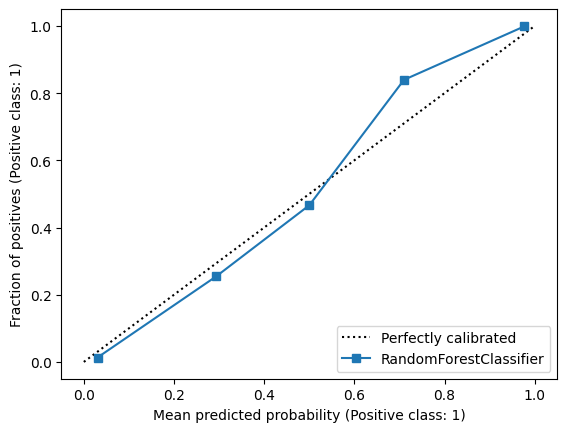

In [115]:
# some lines of your code
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.calibration import CalibrationDisplay


disp = CalibrationDisplay.from_estimator(random_forest_default, X_val_ohe, y_val)

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

В общем случае деревья не предсказывают вероятности, так как их прогнозы основаны на пороговых значениях в узлах дерева. Они предсказывают классы, к которым относится каждый экземпляр данных.

Так же, у случайного леса возникают ошибки с прогнозами, близкими к 0 или 1 из-за наличия дисперсии в базовых моделях, поэтому кривые вероятности имеют вид сигмоиды. До 0.5 недооценивают вероятности, а после 0.5 переоценивают.

<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

UPD: не с параметрами по умолчанию, а так, чтоб сошлась

__Отнормируем данные__

In [116]:
def preprocessing_standard_scaler(train, test):
    """
    Сандартизация всех стобцов данных
    """
    scaler = StandardScaler()

    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)

    train_indexes = train.index
    test_indexes = test.index

    train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns).set_index(
        train_indexes
    )
    test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns).set_index(
        test_indexes
    )

    return train_scaled_df, test_scaled_df

In [117]:
X_train_ohe_scaler, X_val_ohe_scaler = preprocessing_standard_scaler(
    X_train_ohe, X_val_ohe
)

In [195]:
logreg = LogisticRegression(random_state=0)

parameters = [
    {"solver": ["newton-cg", "lbfgs", "liblinear"], "C": [0.001, 0.1, 1, 10, 100, 1000]}
]

grid_search_lr = GridSearchCV(
    estimator=logreg, param_grid=parameters, scoring="accuracy", cv=5, verbose=0
)

grid_search_lr.fit(X_train_ohe_scaler, y_train)

print("GridSearch CV лучший accuracy: {:.4f}".format(grid_search_lr.best_score_))
print("Лучшие параметры:", (grid_search_lr.best_params_))
print("Лучшая модель:", (grid_search_lr.best_estimator_))

evaluate_model_classification(
    grid_search_lr.best_estimator_, X_train_ohe_scaler, y_train, X_val_ohe_scaler, y_val
)

GridSearch CV лучший accuracy: 0.8755
Лучшие параметры: {'C': 1, 'solver': 'newton-cg'}
Лучшая модель: LogisticRegression(C=1, random_state=0, solver='newton-cg')
Train Support : {0: 40484, 1: 30911}
--------------------------------------------------
Train Confusion Matrix:
[[36676  3808]
 [ 5071 25840]]
--------------------------------------------------
Train Accuracy : 0.8756
Train Precision : 0.9059
Train Recall/Sensitivity/TPR : 0.8785
Train FPR (1 - Specificity): 0.1284
Train specificity : 0.8716
Train f1-score : 0.8920
--------------------------------------------------
Train ROC AUC : 0.9907
                                                  
                                                  
Val Support : {0: 17389, 1: 13211}
--------------------------------------------------
Val Confusion Matrix:
[[15751  1638]
 [ 2167 11044]]
--------------------------------------------------
Val Accuracy : 0.8757
Val Precision : 0.9058
Val Recall/Sensitivity/TPR : 0.8791
Val FPR (1 - Specifici

In [156]:
results_data = get_results_dict(
    "6_logreg_ohe_scaler_CV.pkl",
    grid_search.best_estimator_,
    y_train,
    y_val,
    y_pred_train,
    y_pred_val,
    y_pred_train_proba,
    y_pred_val_proba,
)
results_df_to_concat = get_results_df(results_data, 6)
results_df = pd.concat([results_df, results_df_to_concat])

In [166]:
results_df

Date                                 Model Name  \
0 2024-03-11 11:33:00                         0_tree_ohe_def.pkl   
1 2024-03-11 11:35:00         1_tree_ohe_depth5_two_features.pkl   
2 2024-03-11 11:35:00  2_tree_ohe_depth5_two_features_contin.pkl   
3 2024-03-11 11:41:00                     3_tree_ohe_CV_best.pkl   
4 2024-03-11 11:43:00             4_tree_ohe_CV_best_pruning.pkl   
5 2024-03-11 12:01:00                5_random_forest_default.pkl   
6 2024-03-11 12:56:00                 6_logreg_ohe_scaler_CV.pkl   

               Model Type                                              Model  \
0  DecisionTreeClassifier             DecisionTreeClassifier(random_state=0)   
1  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
2  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
3  DecisionTreeClassifier  DecisionTreeClassifier(criterion='entropy', ma...   
4  DecisionTreeClassifier  DecisionTreeClassifier(ccp_alpha=0.00011, crit...   
5  RandomForestClassifier  DecisionTreeClassifier(max_features='sqrt', ra...   
6      LogisticRegression  LogisticRegression(C=1, random_state=0, solver...   

   train_accuracy  train_precision  train_recall  train_f1_score  \
0        1.000000         1.000000      1.000000        1.000000   
1        0.820590         0.827794      0.831773        0.820448   
2        0.678395         0.689172      0.649269        0.645581   
3        0.955039         0.956763      0.951825        0.953981   
4        0.953988         0.956080      0.950459        0.952874   
5        1.000000         1.000000      1.000000        1.000000   
6        0.951607         0.952188      0.949193        0.950564   

   train_roc_auc  val_accuracy  val_precision  val_recall  val_f1_score  \
0       1.000000      0.941144       0.939715    0.940458      0.940077   
1       0.897977      0.824837       0.831603    0.836095      0.824660   
2       0.723717      0.683660       0.695252    0.654126      0.651068   
3       0.992945      0.950882       0.952854    0.947235      0.949656   
4       0.992199      0.952124       0.954512    0.948228      0.950898   
5       1.000000      0.960196       0.961787    0.957230      0.959249   
6       0.991675      0.948889       0.949570    0.946199      0.947730   

   val_roc_auc  
0     0.940458  
1     0.902055  
2     0.728443  
3     0.990708  
4     0.991574  
5     0.993494  
6     0.990510

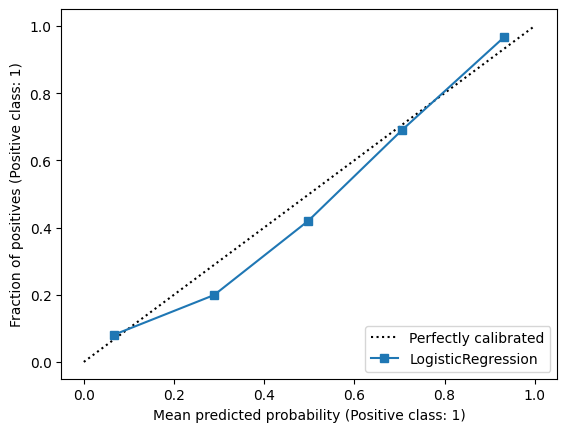

In [121]:
displ_logreg = CalibrationDisplay.from_estimator(
    grid_search.best_estimator_, X_val_ohe_scaler, y_val
)

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

Лосс:
$$ L(y,p\hat{})= p\cdot ln(p)+(1-p)\cdot ln(1-p\hat{}) -> min\, p\hat{} $$

Продифференцируем по p с крышечкой (вероятность с оценкой, которую выдает модель):

$$\frac{\partial (p\cdot ln(p)+(1-p)\cdot ln(1-p\hat{})) }{\partial p\hat{}} = \frac{p}{p\hat{}} + \frac{1-p}{1-p\hat{}} $$

$$ p-p\cdot p\hat{} = p\hat{}-p\cdot \hat{}p\\ $$

$$ p=p\hat{} $$

Следовательно, вероятность с оценкой равна реальной вероятности и логистическая функция потерь корректно прогнозирует вероятности.

(0.75 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

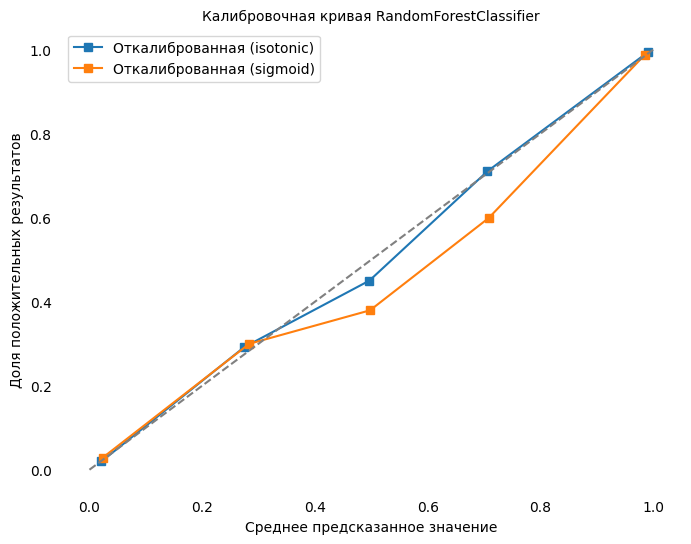

In [122]:
methods = ["isotonic", "sigmoid"]
calibrated_classifiers = []

for method in methods:
    clf = CalibratedClassifierCV(random_forest_default, cv=3, method=method)
    clf.fit(X_train_ohe, y_train)
    calibrated_classifiers.append(clf)

plt.figure(figsize=(8, 6))

for clf, method in zip(calibrated_classifiers, methods):
    prob_pos = clf.predict_proba(X_val_ohe)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_val, prob_pos, n_bins=5
    )
    plt.plot(
        mean_predicted_value,
        fraction_of_positives,
        "s-",
        label=f"Откалиброванная ({method})",
    )

plt.plot([0, 1], [0, 1], "--", color="gray")
plt.legend()
plt.title("Калибровочная кривая RandomForestClassifier", fontsize=10)
plt.xlabel("Среднее предсказанное значение")
plt.ylabel("Доля положительных результатов")
sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position("none")
plt.gca().yaxis.set_ticks_position("none")
plt.show()

Обучаем случайный лес, а затем калибрируем вероятности с использованием изотонической регрессии и логистической регрессии. Затем он отображает калибровочные кривые для обеих методов калибровки.

Интерпретация результатов:

- Идеальная калибровочная кривая должна следовать диагонали (линия y=x). Чем ближе кривая к диагонали, тем лучше калибровка.
- Если калибровочная кривая выходит за пределы диагонали, это указывает на недооценку или переоценку вероятностей.
- Логистическая регрессия и изотоническая регрессия используют различные методы для калибровки вероятностей. В данном случае изотоническая регрессия работает заметно лучше.

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

- Гистограммная калибровка – это процесс калибровки вероятностей в задачах бинарной классификации. В этом методе отрезок значений, выдаваемых моделью для каждого объекта (например, оценка вероятности принадлежности к классу "1"), разбивается на равные по ширине интервалы, называемые бинами. Затем на каждом бине прогнозируется одна и та же вероятность, которая является средним значением меток классов объектов, попавших в данный бин. Это позволяет лучше приблизить средние метки классов на соответствующих бинах. Ссылка:  https://academy.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti


- Деревья калибровки вероятностей используют алгоритм, аналогичный алгоритму построения деревьев логистических моделей. Они работают с двумя входными наборами данных: исходными обучающими данными и связанными выходными оценками из базового классификатора, которые требуется откалибровать (например, вероятностные оценки). Исходные обучающие данные используются для построения базовой древовидной структуры, а выходные оценки – для обучения логистических моделей с помощью алгоритма LogitBoost. Таким образом, дерево калибровки вероятностей выполняет калибровку Платта в различных областях входного пространства, одновременно используя глобальную модель калибровки Платта, если это обеспечивает лучшую оценку. Ссылка: https://proceedings.mlr.press/v77/leathart17a/leathart17a.pdf

(1 балл) <font color='#9933CC'>Посчитайте разброс и смещение полученного случайного леса (до калибровки).</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [123]:
SAMPLE_SIZE = 20000

index_samp_train = X_train_ohe.sample(SAMPLE_SIZE).index
index_samp_val = X_val_ohe.sample(SAMPLE_SIZE).index

In [124]:
tree_ohe_def = DecisionTreeClassifier(random_state=0)

error_dt, bias_dt, var_dt = bias_variance_decomp(
    tree_ohe_def,
    X_train_ohe.loc[index_samp_train].values,
    y_train.loc[index_samp_train].values,
    X_val_ohe.loc[index_samp_val].values,
    y_val.loc[index_samp_val].values,
    loss="0-1_loss",
    random_seed=0,
)
print(
    f"Для дерева:\n- ошибка: {error_dt};\n- смещение: {bias_dt};\n- разброс: {var_dt}."
)

Для дерева:
- ошибка: 0.07452450000000001;
- смещение: 0.04585;
- разброс: 0.056258.


In [125]:
# one more place for your code
%%time
error_rf, bias_rf, var_rf = bias_variance_decomp(
    random_forest_default,
    X_train_ohe.loc[index_samp_train].values,
    y_train.loc[index_samp_train].values,
    X_val_ohe.loc[index_samp_val].values,
    y_val.loc[index_samp_val].values,
    loss="0-1_loss",
    random_seed=0,
)
print(f"Для леса:\n- ошибка: {error_rf};\n- смещение: {bias_rf};\n- разброс: {var_rf}.")

Для леса:
- ошибка: 0.04945625;
- смещение: 0.0472;
- разброс: 0.012444750000000001.
CPU times: user 8min 40s, sys: 842 ms, total: 8min 41s
Wall time: 8min 44s


- Для экономии времени я использовал выборку из 20000 наблюдений.
- Исходя из предоставленных данных, видно, что для модели случайного леса смещение немного больше, чем для модели дерева решений, тогда как разброс гораздо меньше. Это соответствует ожиданиям из-за того, что модель случайного леса использует несколько деревьев решений и усредняет их предсказания, что уменьшает разброс, но может увеличить смещение. Хотя в теории смещение должно иметь такое же значение как у одного дерева. В данном случае сыграла специфика и погрешность обучения.
- На реальных данных это может отражаться в том, что модель случайного леса может быть более устойчива к шуму и переобучению, но при этом может иметь небольшое увеличение смещения, что может привести к небольшому ухудшению в точности предсказаний по сравнению с моделью дерева решений.

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии (ванильной, не той, что использовали для калибровки).</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [126]:
# (•_•)
%%time
error_lr, bias_lr, var_lr = bias_variance_decomp(
    logreg,
    X_train_ohe_scaler.loc[index_samp_train].values,
    y_train.loc[index_samp_train].values,
    X_val_ohe_scaler.loc[index_samp_val].values,
    y_val.loc[index_samp_val].values,
    loss="0-1_loss",
    random_seed=0,
)
print(
    f"Для логистической регрессии:\n- ошибка: {error_lr};\n- смещение: {bias_lr};\n- разброс: {var_lr}."
)

Для логистической регрессии:
- ошибка: 0.1219385;
- смещение: 0.12215;
- разброс: 0.007217500000000001.
CPU times: user 16.8 s, sys: 9.7 s, total: 26.5 s
Wall time: 15.1 s


- Ошибка для логистической регрессии значительно выше, чем для моделей дерева решений и случайного леса. Это может указывать на то, что логистическая регрессия хуже справляется с предсказанием на этих данных.
- Смещение для логистической регрессии также выше, чем у случайного леса и дерева решений. Это говорит о том, что она склонна к более смещенным прогнозам по сравнению с 'деревянными' моделями.
- Разброс для логистической регрессии намного ниже, чем у модели случайного леса и дерева решений. Это говорит о более устойчивых, но менее точных предсказаниях, произведенные логистической регрессией. (По теории, смещение у логистической регрессии должно быть выше чем у дерева, однако разброс ниже - все сходится.)

- На реальных данных логистическая регрессия проявляет себя хуже по сравнению с моделями дерева решений и случайного леса, что говорит о неспособности линейной модели точно описать нелинейные зависимости в данных.

(1 балл) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [127]:
from tqdm import tqdm

100%|██████████| 99/99 [10:16<00:00,  6.22s/it]


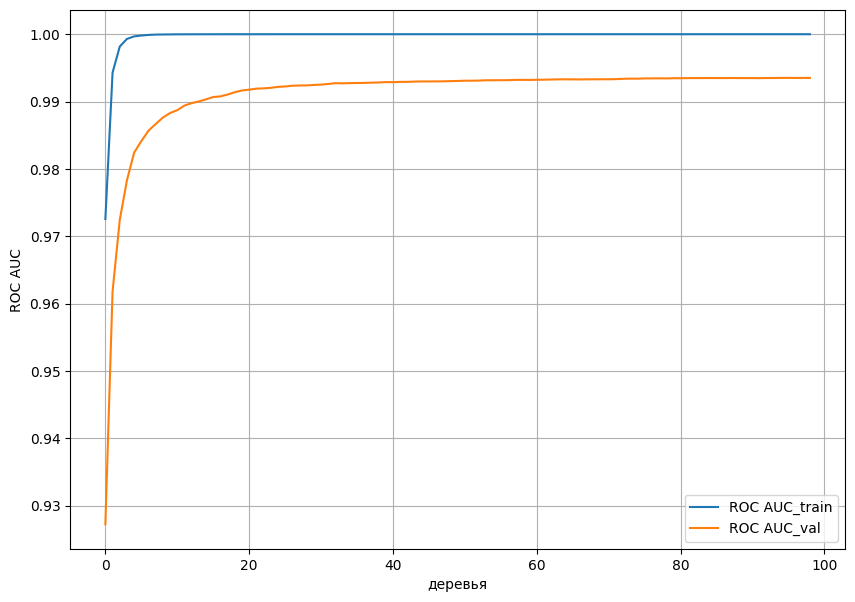

In [128]:
n_trees = 100

train_roc_auc_score = []
val_roc_auc_score = []

for i in tqdm(range(1, n_trees)):
    bagging_clf = RandomForestClassifier(n_estimators=i, random_state=0)
    bagging_clf.fit(X_train_ohe, y_train)

    y_train_pred = bagging_clf.predict_proba(X_train_ohe)[:, 1]
    y_val_pred = bagging_clf.predict_proba(X_val_ohe)[:, 1]
    train_score = roc_auc_score(y_train, y_train_pred)
    val_score = roc_auc_score(y_val, y_val_pred)

    train_roc_auc_score.append(train_score)
    val_roc_auc_score.append(val_score)

plt.figure(figsize=(10, 7))
plt.grid()
plt.plot(train_roc_auc_score, label="ROC AUC_train")
plt.plot(val_roc_auc_score, label="ROC AUC_val")
plt.ylabel("ROC AUC")
plt.xlabel("деревья")
plt.legend();

In [162]:
from scipy.stats import uniform

random_forest_CV = RandomForestClassifier(random_state=0)

parameters = {
    "n_estimators": [100],
    "min_samples_split": np.arange(103, 106),
    "min_samples_leaf": np.arange(10, 12),
    "criterion": ["entropy"],
    "ccp_alpha": [0.00011],
    "max_depth": uniform.rvs(loc=4, scale=18, size=6, random_state=0).astype(int),
}

In [163]:
%%time
grid_search = GridSearchCV(
    estimator=random_forest_CV,
    param_grid=parameters,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="roc_auc",
)

grid_search.fit(X_train_ohe, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
CPU times: user 14.4 s, sys: 1.28 s, total: 15.6 s
Wall time: 8min 1s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': [0.00011], 'criterion': ['entropy'],
                         'max_depth': array([13, 16, 14, 13, 11, 15]),
                         'min_samples_leaf': array([10, 11]),
                         'min_samples_split': array([103, 104, 105]),
                         'n_estimators': [100]},
             scoring='roc_auc', verbose=2)

In [164]:
random_forest_CV_best = grid_search.best_estimator_
random_forest_CV_best_params = grid_search.best_params_

random_forest_CV_best

RandomForestClassifier(ccp_alpha=0.00011, criterion='entropy', max_depth=16,
                       min_samples_leaf=10, min_samples_split=103,
                       random_state=0)

In [ ]:
print("GridSearch CV лучший accuracy: {:.4f}".format(grid_search.best_score_))
print("Лучшие параметры:", (grid_search.best_params_))
print("Лучшая модель:", (grid_search.best_estimator_))

In [171]:
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(
    random_forest_CV_best, X_train_ohe, X_val_ohe
)

evaluate_model_classification(
    random_forest_CV_best, X_train_ohe, y_train, X_val_ohe, y_val
)

Train Support : {0: 40484, 1: 30911}
--------------------------------------------------
Train Confusion Matrix:
[[39156  1328]
 [ 2127 28784]]
--------------------------------------------------
Train Accuracy : 0.9516
Train Precision : 0.9672
Train Recall/Sensitivity/TPR : 0.9485
Train FPR (1 - Specificity): 0.0441
Train specificity : 0.9559
Train f1-score : 0.9577
--------------------------------------------------
Train ROC AUC : 0.9917
                                                  
                                                  
Val Support : {0: 17389, 1: 13211}
--------------------------------------------------
Val Confusion Matrix:
[[16796   593]
 [  971 12240]]
--------------------------------------------------
Val Accuracy : 0.9489
Val Precision : 0.9659
Val Recall/Sensitivity/TPR : 0.9453
Val FPR (1 - Specificity) : 0.0462
Val specificity : 0.9538
Val f1-score : 0.9555
--------------------------------------------------
Val ROC AUC : 0.9905


In [186]:
results_data = get_results_dict(
    "7_random_forest_CV_best.pkl",
    random_forest_CV_best,
    y_train,
    y_val,
    y_pred_train,
    y_pred_val,
    y_pred_train_proba,
    y_pred_val_proba,
)
results_df_to_concat = pd.DataFrame(results_data).loc[7:7]
results_df_to_concat["Date"] = pd.to_datetime(
    results_df_to_concat["Date"], format="%Y-%m-%d %H:%M"
)

results_df = pd.concat([results_df, results_df_to_concat])

In [187]:
results_df

Date                                 Model Name  \
0 2024-03-11 11:33:00                         0_tree_ohe_def.pkl   
1 2024-03-11 11:35:00         1_tree_ohe_depth5_two_features.pkl   
2 2024-03-11 11:35:00  2_tree_ohe_depth5_two_features_contin.pkl   
3 2024-03-11 11:41:00                     3_tree_ohe_CV_best.pkl   
4 2024-03-11 11:43:00             4_tree_ohe_CV_best_pruning.pkl   
5 2024-03-11 12:01:00                5_random_forest_default.pkl   
6 2024-03-11 12:56:00                 6_logreg_ohe_scaler_CV.pkl   
7 2024-03-11 13:23:00                7_random_forest_CV_best.pkl   

               Model Type                                              Model  \
0  DecisionTreeClassifier             DecisionTreeClassifier(random_state=0)   
1  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
2  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
3  DecisionTreeClassifier  DecisionTreeClassifier(criterion='entropy', ma...   
4  DecisionTreeClassifier  DecisionTreeClassifier(ccp_alpha=0.00011, crit...   
5  RandomForestClassifier  DecisionTreeClassifier(max_features='sqrt', ra...   
6      LogisticRegression  LogisticRegression(C=1, random_state=0, solver...   
7  RandomForestClassifier  DecisionTreeClassifier(ccp_alpha=0.00011, crit...   

   train_accuracy  train_precision  train_recall  train_f1_score  \
0        1.000000         1.000000      1.000000        1.000000   
1        0.820590         0.827794      0.831773        0.820448   
2        0.678395         0.689172      0.649269        0.645581   
3        0.955039         0.956763      0.951825        0.953981   
4        0.953988         0.956080      0.950459        0.952874   
5        1.000000         1.000000      1.000000        1.000000   
6        0.951607         0.952188      0.949193        0.950564   
7        0.951607         0.952188      0.949193        0.950564   

   train_roc_auc  val_accuracy  val_precision  val_recall  val_f1_score  \
0       1.000000      0.941144       0.939715    0.940458      0.940077   
1       0.897977      0.824837       0.831603    0.836095      0.824660   
2       0.723717      0.683660       0.695252    0.654126      0.651068   
3       0.992945      0.950882       0.952854    0.947235      0.949656   
4       0.992199      0.952124       0.954512    0.948228      0.950898   
5       1.000000      0.960196       0.961787    0.957230      0.959249   
6       0.991675      0.948889       0.949570    0.946199      0.947730   
7       0.991675      0.948889       0.949570    0.946199      0.947730   

   val_roc_auc  
0     0.940458  
1     0.902055  
2     0.728443  
3     0.990708  
4     0.991574  
5     0.993494  
6     0.990510  
7     0.990510

## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [135]:
# change X_train_enc into you equivalent

cols_for_RF = ["age", "Flight Distance", "Online boarding", "Inflight wifi service"]
X_train_RF = X_train_ohe[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too fe

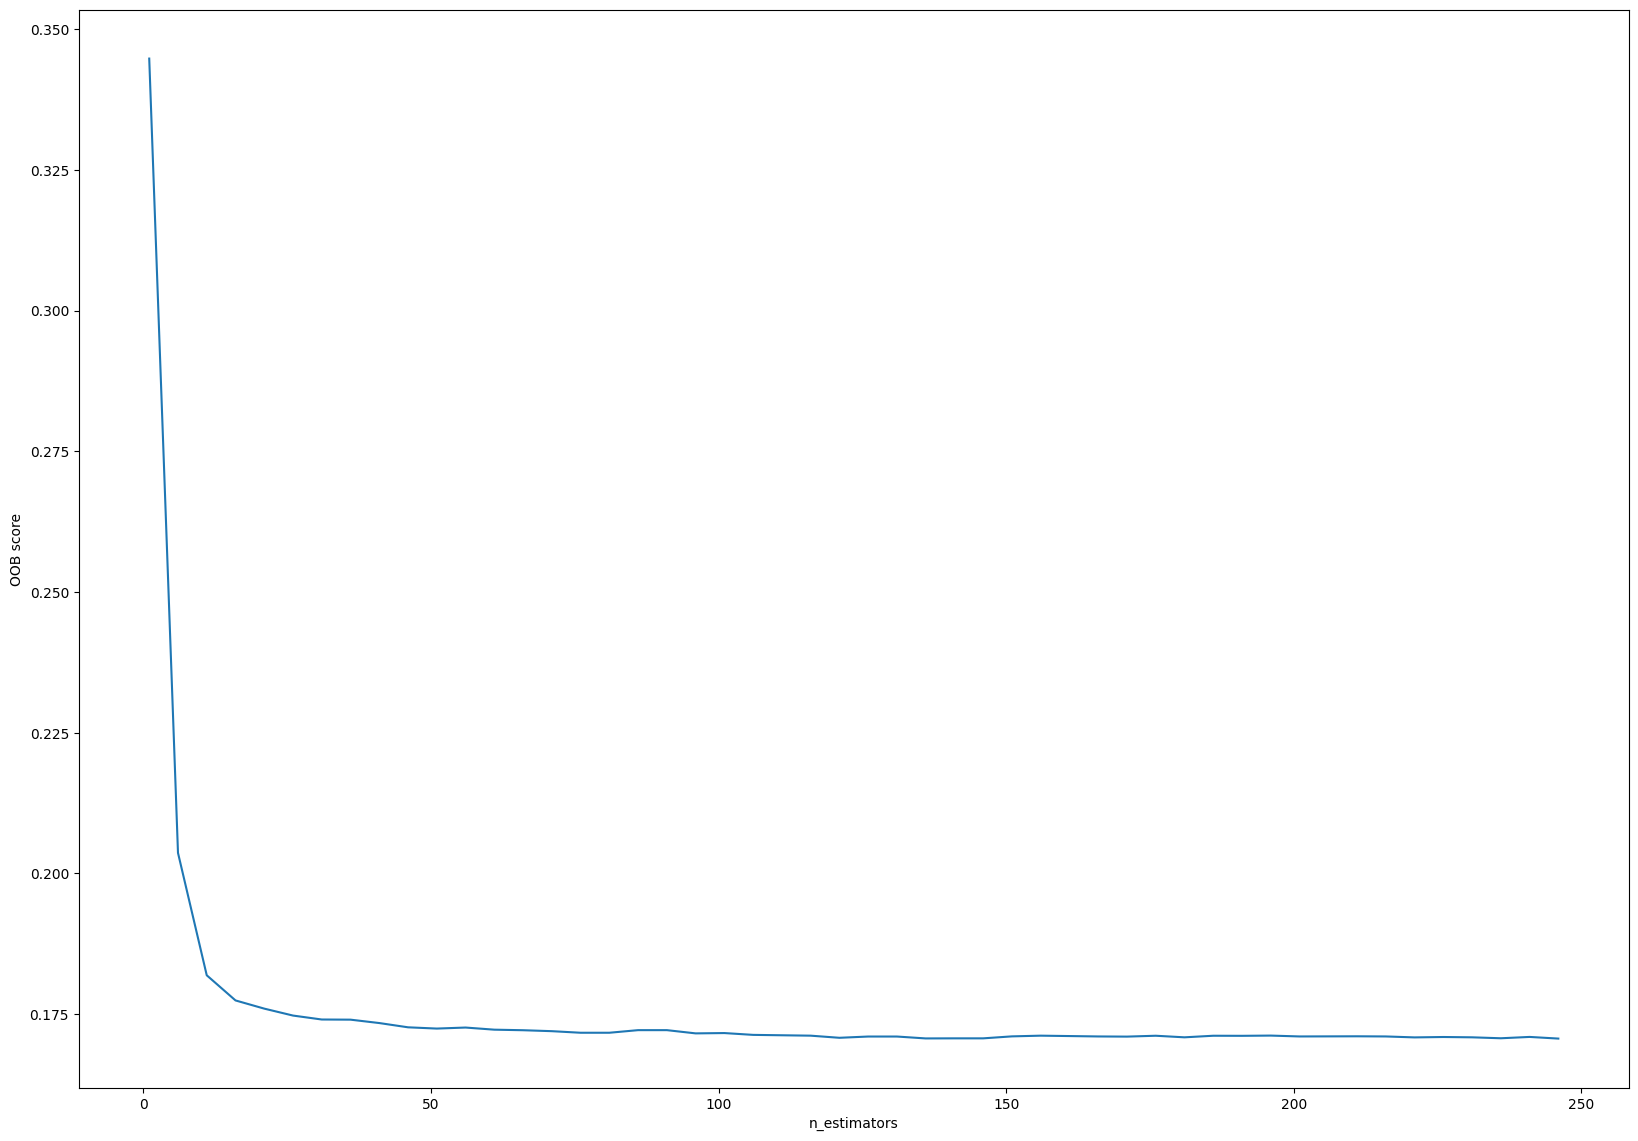

In [136]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel("n_estimators")
plt.ylabel("OOB score")
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

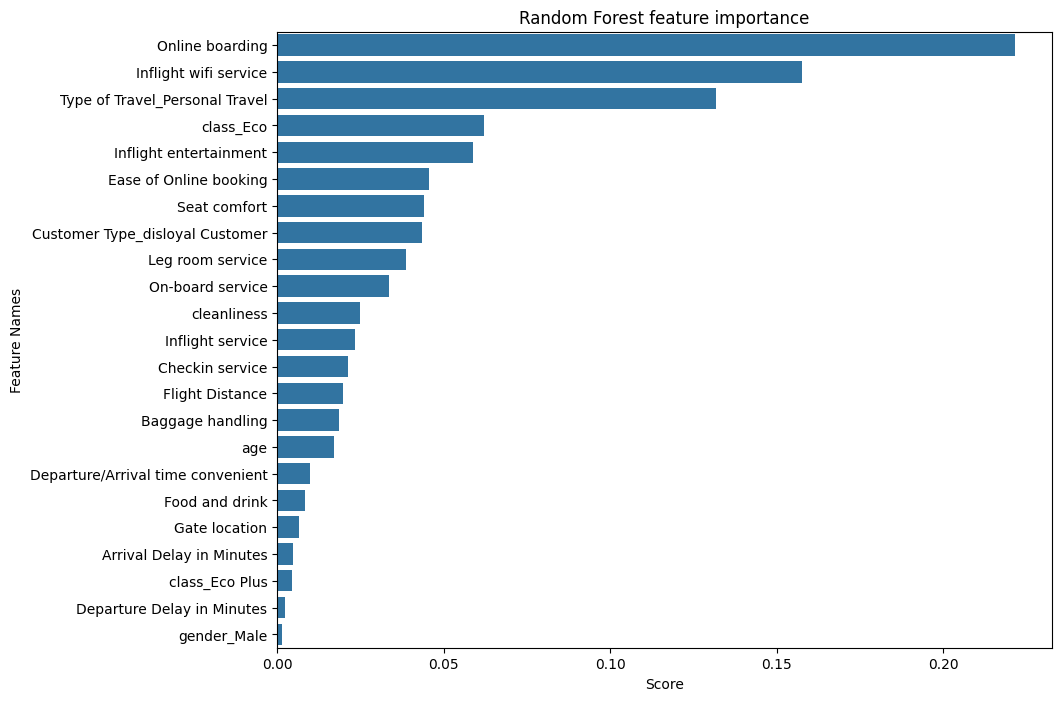

In [137]:
# (•_•)
plot_feature_importance(
    random_forest_CV_best.feature_importances_, X_train_ohe.columns, "Random Forest"
)

(0.5 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

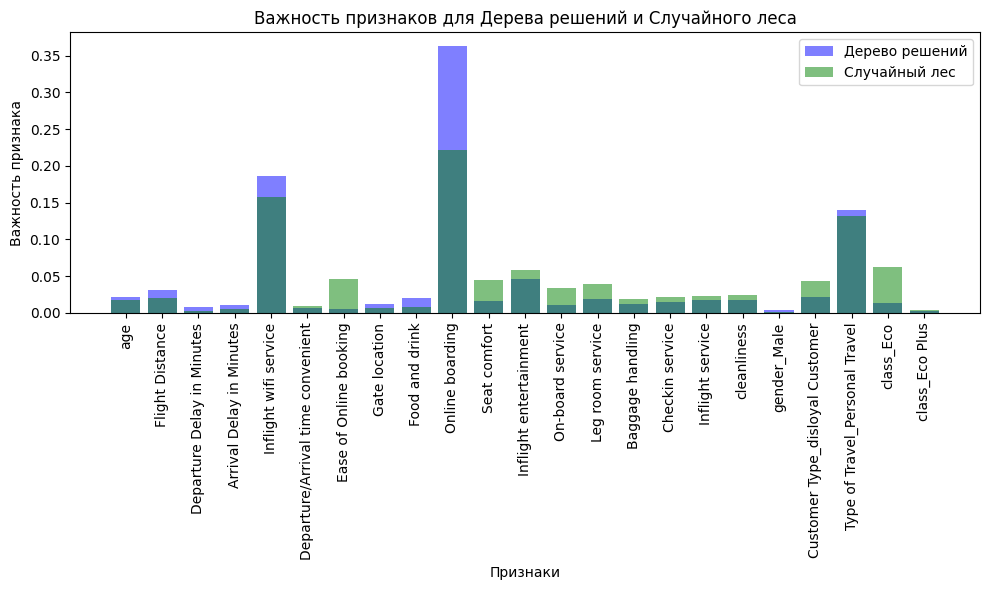

In [138]:
# -__-
feature_names = X_train_ohe.columns.tolist()

dt_feature_importances = tree_ohe_def.feature_importances_
rf_feature_importances = np.mean(
    [tree.feature_importances_ for tree in random_forest_CV_best.estimators_], axis=0
)

plt.figure(figsize=(10, 6))

plt.bar(
    feature_names,
    dt_feature_importances,
    color="blue",
    alpha=0.5,
    label="Дерево решений",
)
plt.bar(
    feature_names,
    rf_feature_importances,
    color="green",
    alpha=0.5,
    label="Случайный лес",
)

plt.title("Важность признаков для Дерева решений и Случайного леса")
plt.xlabel("Признаки")
plt.ylabel("Важность признака")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [139]:
SAMPLE_SIZE = 100

index_samp_train = X_train_ohe.sample(SAMPLE_SIZE).index
index_samp_val = X_val_ohe.sample(SAMPLE_SIZE).index

In [140]:
tree_ohe_def = DecisionTreeClassifier(random_state=0)

error_dt, bias_dt, var_dt = bias_variance_decomp(
    tree_ohe_def,
    X_train_ohe.loc[index_samp_train].values,
    y_train.loc[index_samp_train].values,
    X_val_ohe.loc[index_samp_val].values,
    y_val.loc[index_samp_val].values,
    loss="0-1_loss",
    random_seed=0,
)
print(
    f"Для дерева:\n- ошибка: {error_dt};\n- смещение: {bias_dt};\n- разброс: {var_dt}."
)

Для дерева:
- ошибка: 0.1936;
- смещение: 0.15;
- разброс: 0.1484.


PermutationExplainer explainer: 1001it [08:52,  1.86it/s]


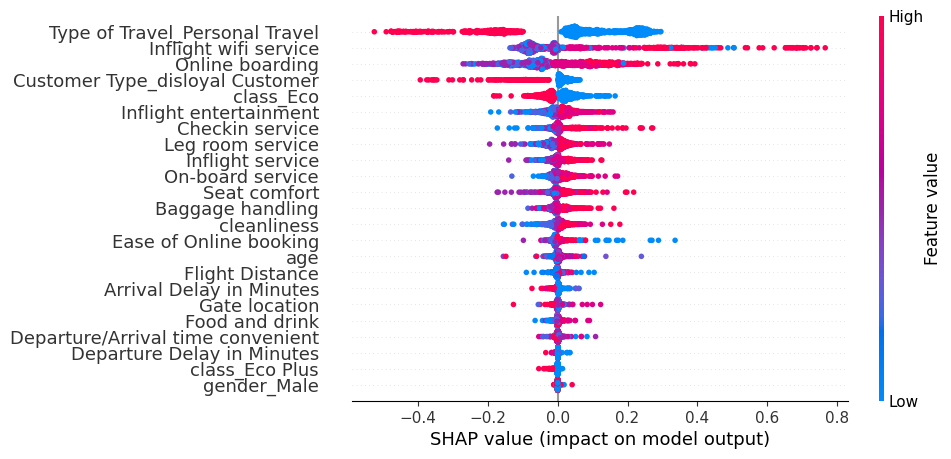

In [141]:
SAMPLE_SIZE = 1000
index_samp_val = X_val_ohe.sample(SAMPLE_SIZE).index

explainer = shap.Explainer(random_forest_CV_best.predict, X_val_ohe.loc[index_samp_val])
shap_values = explainer(X_val_ohe.loc[index_samp_val])

shap.plots.beeswarm(shap_values, max_display=30, color_bar=True, plot_size=(8, 5))

<font color='#FF6600'>Опишите полученый график</font>

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точки на графике, тем выше значения фичи в ней

- Для интерпретации важности признаков с использованием SHAP было использовано 1000 случайных объектов для расчета, чтобы уменьшить время выполнения.

- График, полученный с использованием SHAP, отображает влияние каждого признака на прогноз модели. Верхние признаки на графике, такие как "Type of Travel Personal Travel" и "inflight_wifi_service", оказывают наибольшее влияние на прогноз, в то время как признаки внизу, например "class_Eco Plus" и "gender Female/Male", оказывают наименьшее влияние. Вертикальная ось показывает величину вклада признаков в модель для больших по величине прогнозов (красная линия) и для меньших по величине прогнозов (синяя линия). Это позволяет оценить, как различные признаки влияют на прогноз модели в зависимости от их значений.

<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

1. SHAP Values - представляет метод объяснения модели, который дает вклад каждого признака в прогноз модели для каждого конкретного наблюдения. Это позволяет понять, какие признаки вносят наибольший вклад в каждый конкретный прогноз;

2. Tree SHAP - это алгоритм, разработанный специально для моделей на основе деревьев решений, таких как решающие деревья и случайные леса. Он позволяет эффективно и точно вычислять значения SHAP для этих моделей;

3. Kernel SHAP - это алгоритм, который может использоваться для вычисления значений SHAP для любой модели машинного обучения. Он основан на идее аппроксимации значений SHAP с помощью ядерных методов и предоставляет более общий и гибкий подход к интерпретации моделей;

4. Дополнительные методы SHAP - также предоставляет дополнительные методы объяснения, такие как LIME (Local Interpretable Model-agnostic Explanations) и Deep SHAP, которые могут быть полезны для интерпретации моделей с использованием локальных методов объяснения и глубоких нейронных сетей соответственно;

5. Интеграция SHAP с различными библиотеками машинного обучения, такими как scikit-learn, XGBoost и LightGBM.


- В SHAP можно посмотреть влияние фичей на все классы и на каждый класс в отдельности. Можно посмотреть влияние отдельной фичи на конкретный класс с помощью `dependence_plot`.
- Одна из самых крутых фишек баблиотеки SHAP, это возможность посмотреть как модель опрделяет к какому классу относится тот или иной объект, и какие признаки на это влияют.

  В этом помогут `force_plot` и вид графика `waterfall_plot`.
  Можно посмотреть на вклад каждого признака в то, что модель не отнесла к классу 0 и отнесла к классу 1.

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [142]:
# please type your solution below
from lime import lime_tabular
import random
from random import randint

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_ohe.values,
    mode="classification",
    training_labels=y_train,
    feature_names=X_train_ohe.columns.values.tolist(),
)

idx = 0
explanation = explainer.explain_instance(
    X_val_ohe.values[idx], random_forest_CV_best.predict_proba
)
explanation.show_in_notebook(show_table=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


<font color='#FF6600'>Опишите полученый график</font>

1. Результаты интерпретации с использованием LIME позволяют определить ключевые признаки, влияющие на прогноз модели для конкретного наблюдения. В представленных данных отражены вероятности предсказания модели для классов 0 и 1, а также важность каждого признака, оцененная на основе LIME.

2. Предсказание вероятности:

  Вероятность класса 0 составляет 0.19, а вероятность класса 1 - 0.81.
  Наиболее важные признаки, оказывающие влияние на прогноз модели:

  - Тип путешествия: Личное (Personal Travel)
  - Тип клиента: Нелояльный (Disloyal Customer)
  - Качество Wi-Fi на борту: Оценка признака составляет 3.00
  - Онлайн-посадка: Оценка признака составляет 4.00
  - Класс: Эконом (Eco)
  - Сервис регистрации: Оценка признака составляет 2.00
  - Удобство онлайн-бронирования: Оценка признака составляет 3.00
  - Класс Эконом Плюс: Оценка признака составляет 0.00
  - Комфорт в сиденьях: Оценка признака составляет 1.00
  - Качество питания и напитков: Оценка признака составляет 1.00
  
  Эти результаты помогают определить, какие аспекты обслуживания и услуг - наиболее значимы для модели при принятии решения о прогнозировании класса для конкретного наблюдения.

<font color='#9933CC'>Случайное лес, дающий лучший скор, сохраните в pickle</font>

In [143]:
X_ohe_train_val_concat = pd.concat([X_train_ohe, X_val_ohe]).copy()
y_ohe_train_val_concat = pd.concat([y_train, y_val]).copy()

In [144]:
from sklearn.model_selection import KFold, cross_validate

In [145]:
def objective(trial, X, y, cv, scoring):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 90, 150, log=True),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 3, 100, log=True),
        "max_features": trial.suggest_categorical(
            "max_features", ["sqrt", "log2", None]
        ),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0001, 1.0, log=True),
        "random_state": 0,
        # "n_iter_no_change": 50,  # early stopping
        # "validation_fraction": 0.05,
    }

    if param["bootstrap"] is True:
        param["max_samples"] = trial.suggest_float("max_samples", 0.01, 1.0, log=True)

    estimator = RandomForestClassifier(**param)
    scores = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)

    return scores["test_score"].mean()


study = optuna.create_study(direction="maximize")

# pruner = optuna.pruners.MedianPruner()

# study.optimize(objective, n_trials=100, pruner=pruner)

kf = KFold(n_splits=3, shuffle=True, random_state=0)

func = lambda trial: objective(
    trial, X_ohe_train_val_concat, y_ohe_train_val_concat, cv=kf, scoring="roc_auc"
)

# study.optimize(func, n_trials=100)
# print(study.best_trial)

[I 2024-03-11 12:41:42,562] A new study created in memory with name: no-name-30718e11-0722-4dde-aa2b-1b6b6737e4a4


In [202]:
# FrozenTrial(number=16, state=TrialState.COMPLETE, values=[0.9896511589122209], datetime_start=datetime.datetime(2024, 3, 11, 8, 19, 25, 519447), datetime_complete=datetime.datetime(2024, 3, 11, 8, 20, 10, 689996),
# params={'n_estimators': 101,
# 'max_depth': 18,
# 'min_samples_split': 128,
# 'min_samples_leaf': 6,
# 'max_features': 'log2',
# 'bootstrap': False,
# 'ccp_alpha': 0.00010014327797542403},
# user_attrs={}, system_attrs={}, intermediate_values={},
# distributions={'n_estimators': IntDistribution(high=150, log=False, low=100, step=1),
#  'max_depth': IntDistribution(high=20, log=False, low=4, step=1),
#  'min_samples_split': IntDistribution(high=150, log=True, low=90, step=1),
#  'min_samples_leaf': IntDistribution(high=100, log=True, low=3, step=1),
#  'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None)),
#  'bootstrap': CategoricalDistribution(choices=(True, False)),
#  'ccp_alpha': FloatDistribution(high=1.0, log=True, low=0.0001, step=None)},
#  trial_id=16, value=None)

In [148]:
# best params
# best_params = study.best_params

In [199]:
best_params = {
    "n_estimators": 101,
    "max_depth": 18,
    "min_samples_split": 128,
    "min_samples_leaf": 6,
    "max_features": "log2",
    "bootstrap": False,
    "ccp_alpha": 0.00010014327797542403,
}

In [200]:
random_forest_Optuna = RandomForestClassifier(**best_params)
random_forest_Optuna.fit(X_train_ohe, y_train)

y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(
    random_forest_Optuna, X_train_ohe, X_val_ohe
)

In [201]:
evaluate_model_classification(
    random_forest_Optuna, X_train_ohe, y_train, X_val_ohe, y_val
)

Train Support : {0: 40484, 1: 30911}
--------------------------------------------------
Train Confusion Matrix:
[[39162  1322]
 [ 2069 28842]]
--------------------------------------------------
Train Accuracy : 0.9525
Train Precision : 0.9673
Train Recall/Sensitivity/TPR : 0.9498
Train FPR (1 - Specificity): 0.0438
Train specificity : 0.9562
Train f1-score : 0.9585
--------------------------------------------------
Train ROC AUC : 0.9910
                                                  
                                                  
Val Support : {0: 17389, 1: 13211}
--------------------------------------------------
Val Confusion Matrix:
[[16815   574]
 [  920 12291]]
--------------------------------------------------
Val Accuracy : 0.9512
Val Precision : 0.9670
Val Recall/Sensitivity/TPR : 0.9481
Val FPR (1 - Specificity) : 0.0446
Val specificity : 0.9554
Val f1-score : 0.9575
--------------------------------------------------
Val ROC AUC : 0.9904


In [203]:
results_data = get_results_dict(
    "8_random_forest_Optuna.pkl",
    random_forest_Optuna,
    y_train,
    y_val,
    y_pred_train,
    y_pred_val,
    y_pred_train_proba,
    y_pred_val_proba,
).copy()
results_df_to_concat = pd.DataFrame(results_data).loc[8:8]
results_df_to_concat["Date"] = pd.to_datetime(
    results_df_to_concat["Date"], format="%Y-%m-%d %H:%M"
)

results_df = pd.concat([results_df, results_df_to_concat])

In [205]:
results_df

Date                                 Model Name  \
0 2024-03-11 11:33:00                         0_tree_ohe_def.pkl   
1 2024-03-11 11:35:00         1_tree_ohe_depth5_two_features.pkl   
2 2024-03-11 11:35:00  2_tree_ohe_depth5_two_features_contin.pkl   
3 2024-03-11 11:41:00                     3_tree_ohe_CV_best.pkl   
4 2024-03-11 11:43:00             4_tree_ohe_CV_best_pruning.pkl   
5 2024-03-11 12:01:00                5_random_forest_default.pkl   
6 2024-03-11 12:56:00                 6_logreg_ohe_scaler_CV.pkl   
7 2024-03-11 13:23:00                7_random_forest_CV_best.pkl   
8 2024-03-11 13:43:00                 8_random_forest_Optuna.pkl   

               Model Type                                              Model  \
0  DecisionTreeClassifier             DecisionTreeClassifier(random_state=0)   
1  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
2  DecisionTreeClassifier  DecisionTreeClassifier(max_depth=5, random_sta...   
3  DecisionTreeClassifier  DecisionTreeClassifier(criterion='entropy', ma...   
4  DecisionTreeClassifier  DecisionTreeClassifier(ccp_alpha=0.00011, crit...   
5  RandomForestClassifier  DecisionTreeClassifier(max_features='sqrt', ra...   
6      LogisticRegression  LogisticRegression(C=1, random_state=0, solver...   
7  RandomForestClassifier  DecisionTreeClassifier(ccp_alpha=0.00011, crit...   
8  RandomForestClassifier  DecisionTreeClassifier(ccp_alpha=0.00010014327...   

   train_accuracy  train_precision  train_recall  train_f1_score  \
0        1.000000         1.000000      1.000000        1.000000   
1        0.820590         0.827794      0.831773        0.820448   
2        0.678395         0.689172      0.649269        0.645581   
3        0.955039         0.956763      0.951825        0.953981   
4        0.953988         0.956080      0.950459        0.952874   
5        1.000000         1.000000      1.000000        1.000000   
6        0.951607         0.952188      0.949193        0.950564   
7        0.951607         0.952188      0.949193        0.950564   
8        0.952504         0.952996      0.950206        0.951490   

   train_roc_auc  val_accuracy  val_precision  val_recall  val_f1_score  \
0       1.000000      0.941144       0.939715    0.940458      0.940077   
1       0.897977      0.824837       0.831603    0.836095      0.824660   
2       0.723717      0.683660       0.695252    0.654126      0.651068   
3       0.992945      0.950882       0.952854    0.947235      0.949656   
4       0.992199      0.952124       0.954512    0.948228      0.950898   
5       1.000000      0.960196       0.961787    0.957230      0.959249   
6       0.991675      0.948889       0.949570    0.946199      0.947730   
7       0.991675      0.948889       0.949570    0.946199      0.947730   
8       0.991037      0.951176       0.951754    0.948676      0.950085   

   val_roc_auc  
0     0.940458  
1     0.902055  
2     0.728443  
3     0.990708  
4     0.991574  
5     0.993494  
6     0.990510  
7     0.990510  
8     0.990439

In [206]:
# Сохраним модель
save_model("4_tree_ohe_CV_best_pruning.pkl", tree_ohe_CV_best_pruning)

In [207]:
# Сохраним промежуточные результаты исследования
date_now = datetime.now().strftime("%Y-%m-%d %H:%M")
results_df.to_csv(f"{PATH_RESULTS}/{date_now}_results.csv", index=False)

# # Загрузить результаты исследования
# pd.read_csv(f"{PATH_RESULTS}/.csv")

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Задание интересное, узнал много чего нового, во многом пришлось разобраться более детально. Задание немного охватывает и разведовательный анализ данных с дальнейшей их предобработкой, и построение деревьев и их комбинаций с визуализацией важностей признаков, ошибок моделей и калибровкой вероятностей.

Хотелось бы зацепить такие темы как:
- Бустинги и их тюнинг;
- Optuna;
- Генерация новых признаков в том числе и автоматическая;
- Фильтрация признаков(Catboost: feature importance, selection, permutation; Boruta);
- Блэндинг;
- Стекинг;
- Работа с пайплайном;
- Логирование экспериментов используя платформы.
